# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [1]:
from utils import *
from MSVR import MSVR
from experiment_setup import ExpSetup, GroupedAssessor, OptunaStudy

/home/pbsl/pog/proj-mtr/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [2]:
DIR = 'covid'

seed = 3380435598#randint(0, 4294967295)
print(seed)

3380435598


In [3]:
setup = ExpSetup(DIR, seed, 0)

Xa_train, Xa_train_norm, Xa_test, Xa_test_norm, ya_train, ya_test, pred_corrls, pred_corrls2, performs = setup.assessorData()

Nº de instâncias: 660
[REGISTERED: DTREE]
[Training]

Accuracy:         0.7778
Recall:           0.8545
Precision:        0.7344
F1:               0.7899
AUROC:            0.8626
AUPR:             0.8420
1-maxProb média:  0.2222
1-maxProb dp:     0.1586

[Testing]

Accuracy:         0.6327
Recall:           0.7345
Precision:        0.6103
F1:               0.6667
AUROC:            0.6758
AUPR:             0.6548
1-maxProb média:  0.2291
1-maxProb dp:     0.1495

[REGISTERED: SGD]
[Training]

Accuracy:         0.7378
Recall:           0.6909
Precision:        0.7525
F1:               0.7204
AUROC:            0.8069
AUPR:             0.8066
1-maxProb média:  0.2900
1-maxProb dp:     0.1336

[Testing]

Accuracy:         0.6593
Recall:           0.5841
Precision:        0.6875
F1:               0.6316
AUROC:            0.7276
AUPR:             0.7152
1-maxProb média:  0.2888
1-maxProb dp:     0.1263

[REGISTERED: LR]
[Training]

Accuracy:         0.7378
Recall:           0.6909
Precision: 

In [9]:
ya_train_copy = ya_train.copy()
ya_test_copy = ya_test.copy()
pred_corrls_copy = pred_corrls.copy()
pred_corrls2_copy = pred_corrls2.copy()

# Assessors

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

In [16]:
groups = {}
model_names = ['svm_linear', 'sgd', 'lr', 'mlp'] # ['dtree', 'xgb', 'knn'] #list(performs.keys())

ya_train = ya_train_copy[model_names]
ya_test = ya_test_copy[model_names]
pred_corrls = pred_corrls_copy.loc[model_names, model_names]
pred_corrls2 = pred_corrls2_copy.loc[model_names, model_names]

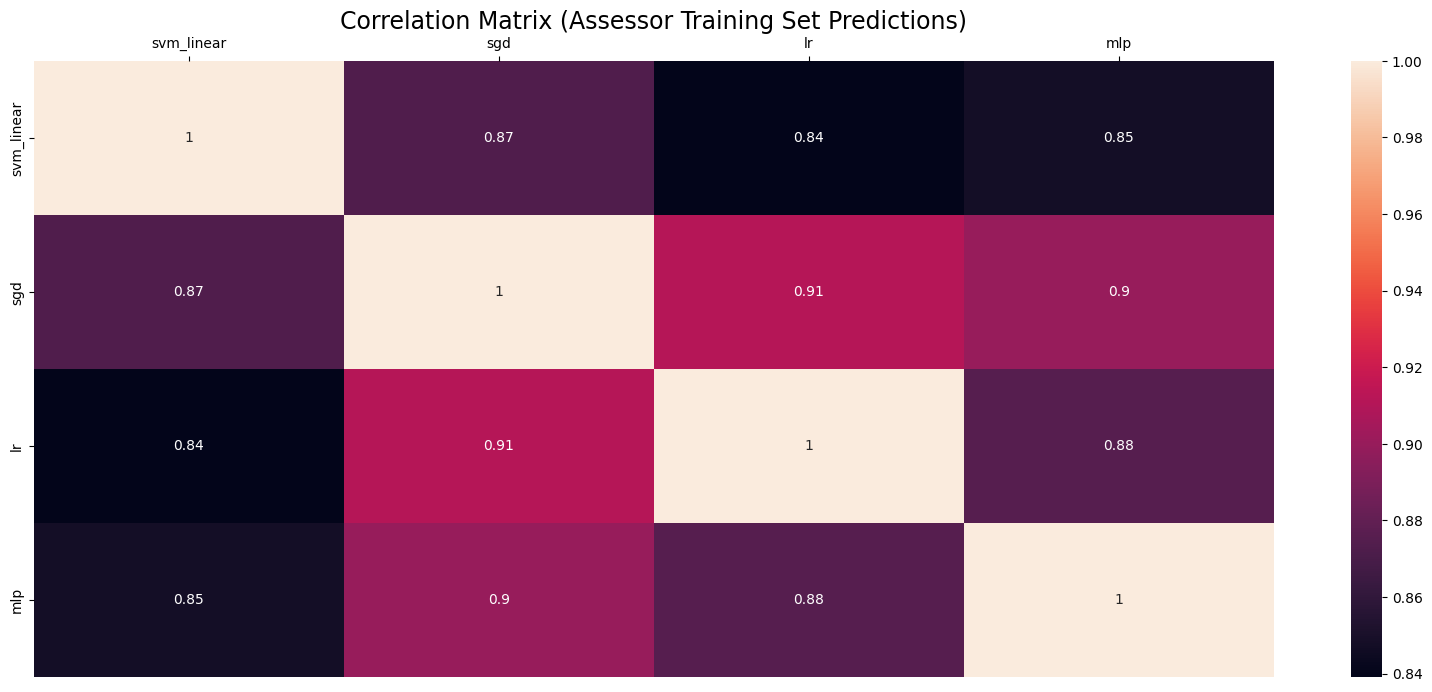

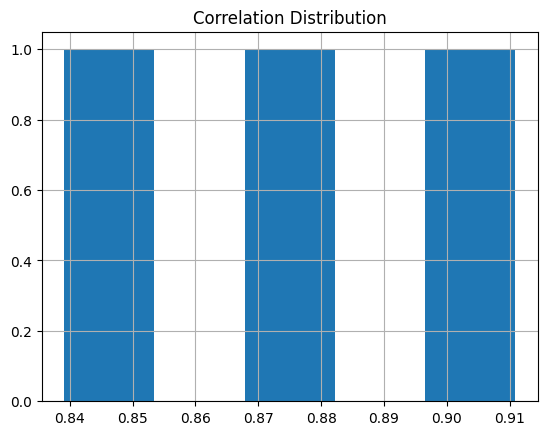

Training correlation distribution:
count    6.000000
mean     0.874153
std      0.028057
min      0.839135
25%      0.853687
50%      0.874022
75%      0.893471
max      0.910875
Name: corr, dtype: float64
[Saved image "cm_atrain.eps"]
[Saved image "cd_atrain.eps"]


In [20]:
correlation_matrix(pred_corrls, True, DIR, 'Assessor', 'Training')

In [24]:
MIN_SCORE = 0.87 #corrls_values['corr'].quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['true_assessor_train'] = group_search(pred_corrls, MIN_SCORE)
groups['true_assessor_train']

Min_score: 0.87


[['sgd', 'mlp', 'lr'], ['sgd', 'svm_linear']]

        Min_score: 0.645
        [['dtree'],
        ['svm_rbf', 'mlp', 'sgd', 'lr'],
        ['svm_rbf', 'kan'],
        ['knn'],
        ['adab'],
        ['xgb'],
        ['gb'],
        ['svm_linear', 'sgd', 'mlp', 'lr'],
        ['rforest'],
        ['svm_poly']]

Conjunto de Teste:

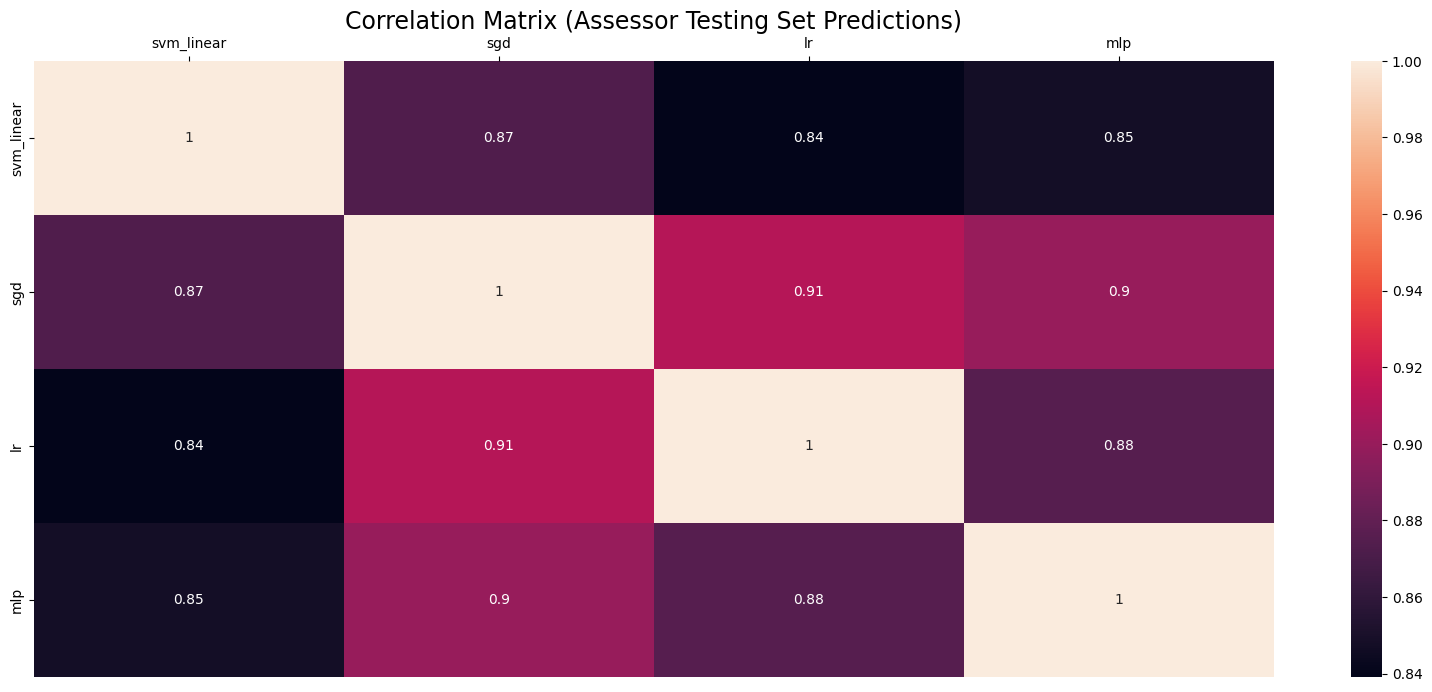

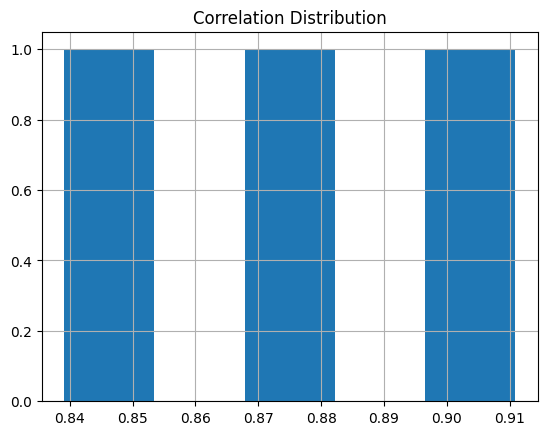

Testing correlation distribution:
count    6.000000
mean     0.874153
std      0.028057
min      0.839135
25%      0.853687
50%      0.874022
75%      0.893471
max      0.910875
Name: corr, dtype: float64
[Saved image "cm_atest.eps"]
[Saved image "cd_atest.eps"]


In [ ]:
correlation_matrix(pred_corrls2, True, DIR, 'Assessor', 'Testing')

In [26]:
groups['true_assessor_test'] = group_search(pred_corrls2, MIN_SCORE)
groups['true_assessor_test']

[['sgd', 'lr'], ['sgd', 'mlp'], ['svm_linear']]

Diferença entre correlações do conjnuto de teste e de treinamento:
MSE:  0.0003
NMSE: 0.0837
MAE:  0.0134
NMAE: 0.2807
aRRMSE: 0.2892
aCC:  0.9953


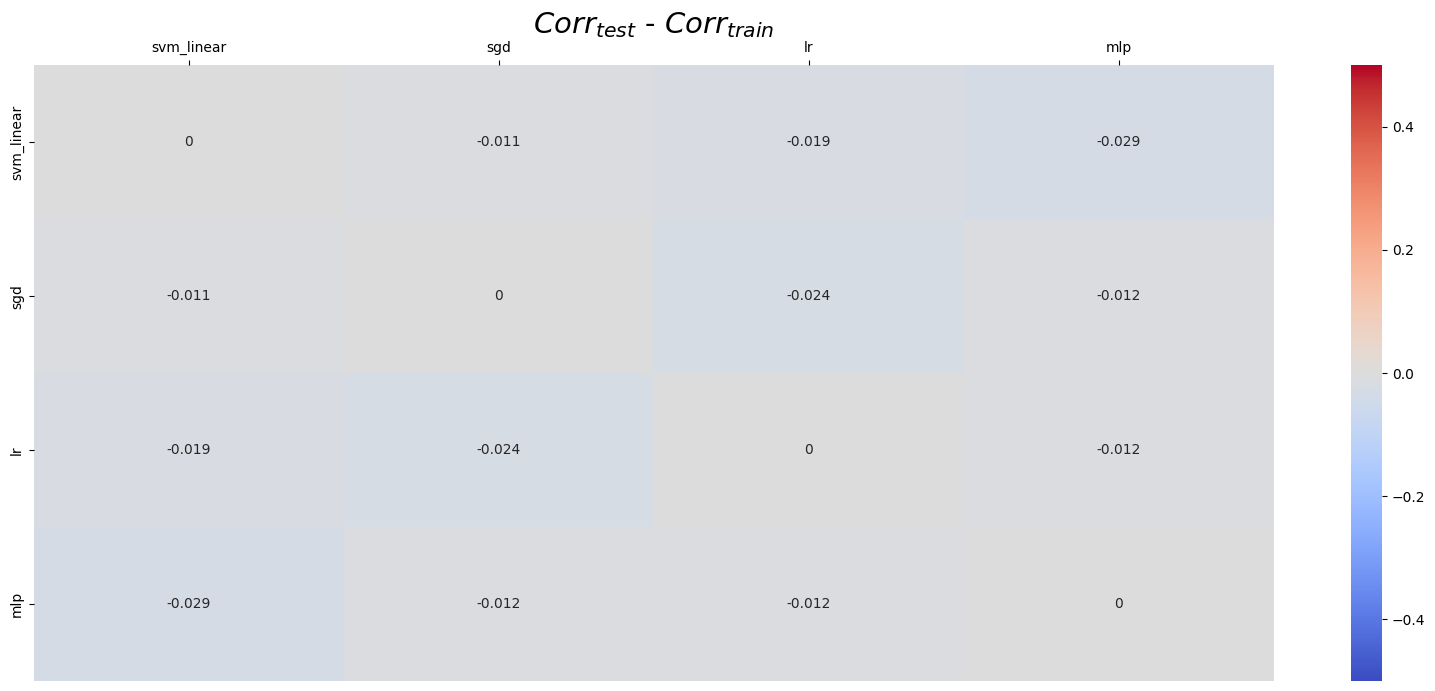

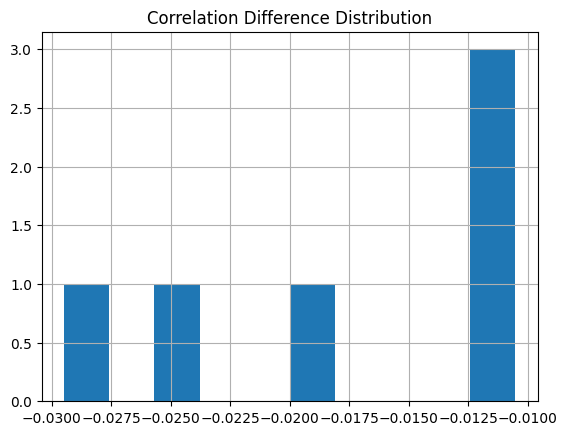

[Saved image "cmd_base.eps"]
[Saved image "cdd_base.eps"]


In [27]:
diff_corrls = pred_corrls2-pred_corrls
diff_corrls_values = corrlArray(diff_corrls)['corr']

print(f'''Diferença entre correlações do conjnuto de teste e de treinamento:
MSE:  {mse(pred_corrls, pred_corrls2):.4f}
NMSE: {nmse(pred_corrls, pred_corrls2):.4f}
MAE:  {mae(pred_corrls, pred_corrls2):.4f}
NMAE: {nmae(pred_corrls, pred_corrls2):.4f}
aRRMSE: {rrmse(pred_corrls, pred_corrls2):.4f}
aCC:  {corrCoeff(pred_corrls, pred_corrls2):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

## Globais

In [28]:
parameters = {'max_depth':[None,10,20,30],
                    'criterion':['squared_error', 'poisson', 'friedman_mse'],
                    'min_samples_split':[2,5,10,20,40,60],
                    'min_samples_leaf':[1,2,10,30],
                    'n_estimators':[20,50,100,150]}

In [29]:
# Criando o MultiIndex
multi_index = multIdx('ST','MRT','MRT(g)','M-SVR','M-SVR(g)','RC','RC(g)', subindex=model_names)

metrics_cols = ['MSE', 'MAE', 'NMSE', 'NMAE', 'aRRMSE', 'aCC']
metrics_df = pd.DataFrame(columns=metrics_cols, index=multi_index)
diff_metrics = pd.DataFrame(columns=metrics_cols, index=['ST','MRT','MRT(g)','M-SVR','M-SVR(g)','RC','RC(g)'])

### Regressor Chain
(RC)

In [12]:
#study = OptunaStudy(Xa_train, ya_train, 30, seed)
#
#study.search(RegressorChain, cv=5)
#
#rc_params = study.best_params
#regchain = RegressorChain(RandomForestRegressor(random_state=seed).set_params(**rc_params),
#                          random_state=seed, cv=5, verbose=True).fit(Xa_train, ya_train)

In [30]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), random_state=seed, cv=5,
                          verbose=True, order='random').fit(Xa_train, ya_train)

[Chain] ................... (1 of 4) Processing order 0, total=   0.2s
[Chain] ................... (2 of 4) Processing order 2, total=   0.2s
[Chain] ................... (3 of 4) Processing order 1, total=   0.2s
[Chain] ................... (4 of 4) Processing order 3, total=   0.2s


In [31]:
metrics_df.loc['RC',:] = assr_performance(regchain, Xa_test, ya_test, Xa_train, ya_train)

metrics_df.loc['RC',:]

[TRAINING SET]
MSE: 0.0094
NMSE: 0.2220
MAE: 0.0690
NMAE: 0.4142
aRRMSE: 0.4646
aCC: 0.9303

[TESTING SET]
MSE: 0.0274
NMSE: 0.7796
MAE: 0.1312
NMAE: 0.8528
aRRMSE: 0.8829
aCC: 0.4724


MSE       MAE      NMSE      NMAE    aRRMSE       aCC
Model                                                                 
svm_linear  0.025841  0.795178  0.129468  0.860798  0.891728  0.452745
sgd         0.036127  0.799481  0.154211  0.856382  0.894137  0.448223
lr          0.010084  0.752805  0.079586    0.8389  0.867643  0.506123
mlp         0.037552  0.770991  0.161549  0.855287  0.878061  0.482701

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

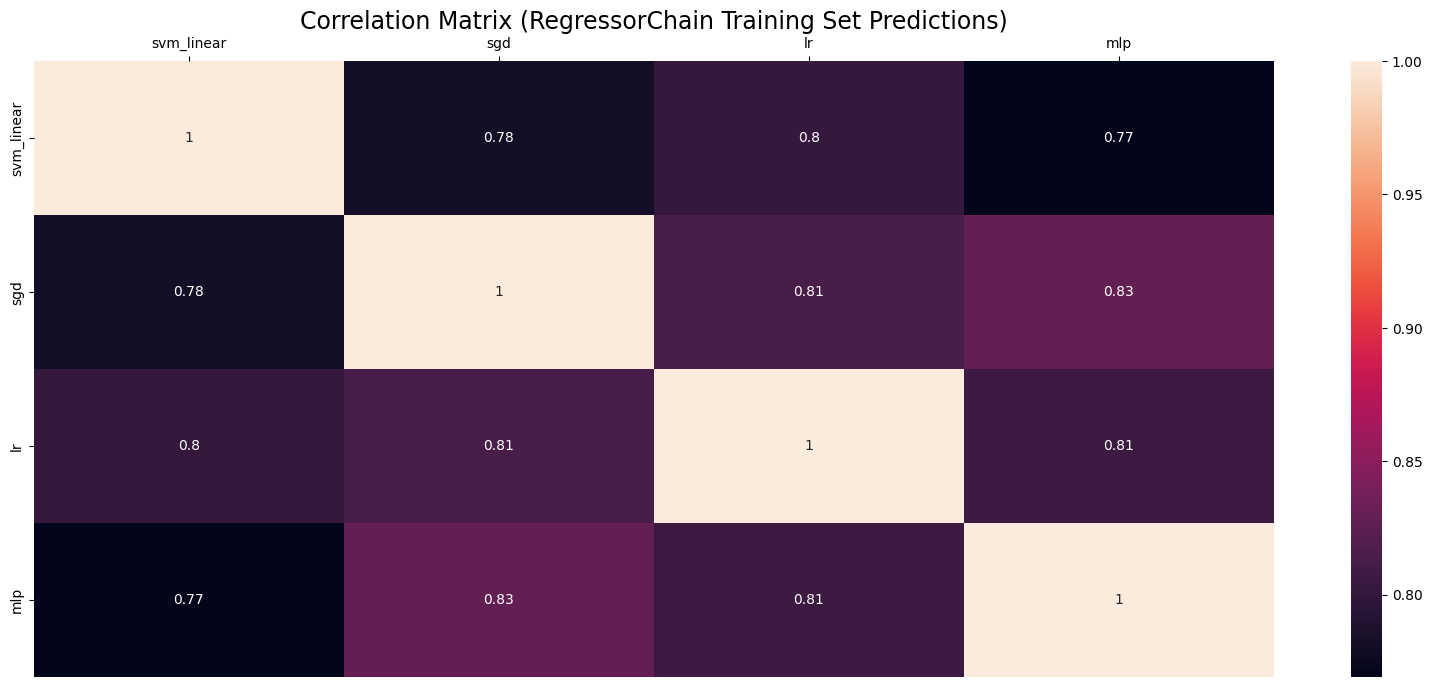

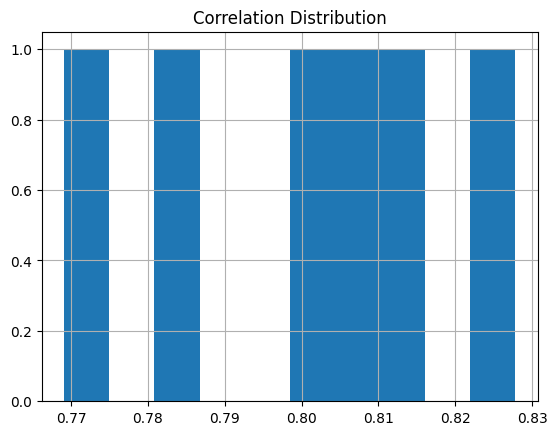

Training correlation distribution:
count    6.000000
mean     0.799895
std      0.021532
min      0.769125
25%      0.786195
50%      0.803540
75%      0.812094
max      0.827807
Name: corr, dtype: float64


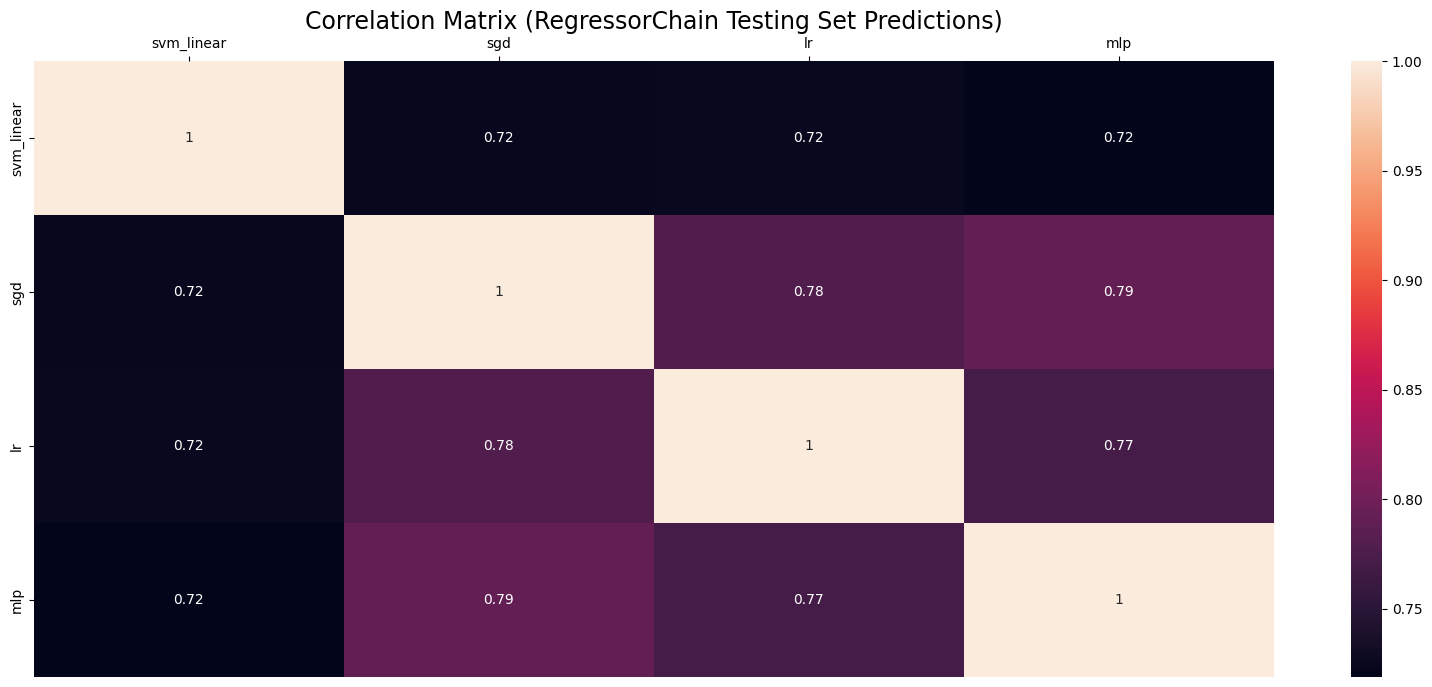

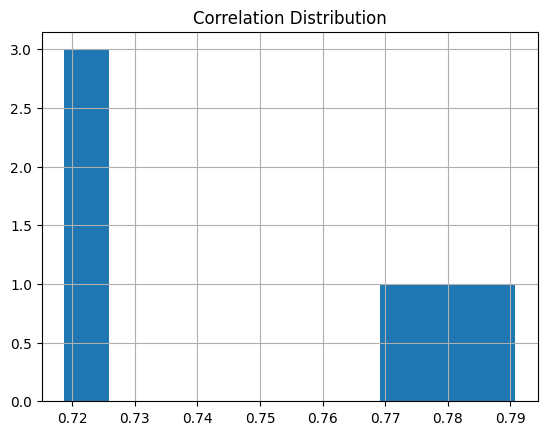

Testing correlation distribution:
count    6.000000
mean     0.750903
std      0.031839
min      0.718742
25%      0.724319
50%      0.747079
75%      0.775549
max      0.790748
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0085
NMSE: 0.0791
MAE: 2.1239
NMAE: 1.4900
aRRMSE: 1.4347
aCC: 0.9862


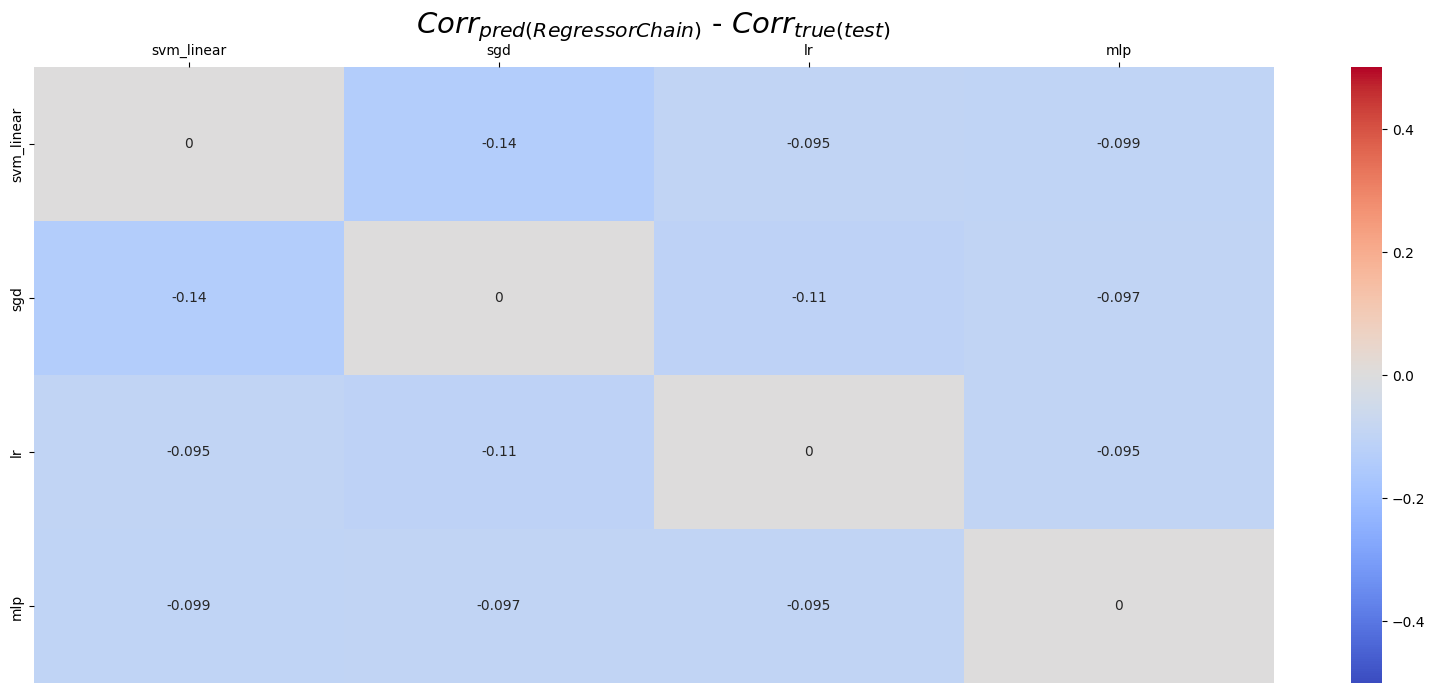

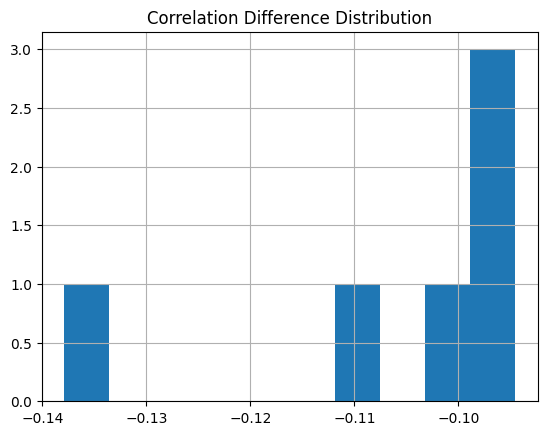

In [32]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 

results = correlation_pred_performance(regchain, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name="RegressorChain",
                                       show_plot=True, save_plot=None)

In [33]:
diff_metrics.loc['RC',:] = results['results']
diff_metrics.loc['RC',:]

MSE       0.008514
MAE       0.079081
NMSE      2.123859
NMAE      1.490022
aRRMSE    1.434651
aCC       0.986198
Name: RC, dtype: object

In [34]:
groups['regchain_assessor'] = results['groups']
groups['regchain_assessor']['test']

[['sgd'], ['svm_linear'], ['mlp'], ['lr']]

### Ensemble of Regressor Chains

In [66]:
num_chains = 80
rc_ac = f'RC[{num_chains}]'

rc_ests = [RegressorChain(base_estimator=RandomForestRegressor(random_state=seed),
                          random_state=seed+i,
                          order='random', cv=5) for i in range(num_chains)]

rc_plus = GroupedAssessor(rc_ests).fit(Xa_train, ya_train)

In [ ]:
# keeping the concat because multiple numbers of chains could be recorded
if(rc_ac in metrics_df.index):
    metrics_df.loc[rc_ac,:] = assr_performance(rc_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rc_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rc_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])
metrics_df.loc[rc_ac,:]

[TRAINING SET]
MSE: 0.0084
NMSE: 0.2087
MAE: 0.0656
NMAE: 0.4007
aRRMSE: 0.4567
aCC: 0.9438

[TESTING SET]
MSE: 0.0272
NMSE: 0.7700
MAE: 0.1300
NMAE: 0.8449
aRRMSE: 0.8774
aCC: 0.4838


MSE       MAE      NMSE      NMAE    aRRMSE       aCC
Model                                                                 
svm_linear  0.025759  0.792651  0.129056  0.858056   0.89031  0.455481
sgd         0.035161  0.778096   0.15217  0.845048  0.882098  0.472843
lr          0.009773  0.729635  0.078485  0.827299  0.854187  0.533752
mlp         0.037965  0.779453   0.16042  0.849313  0.882866  0.473128

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

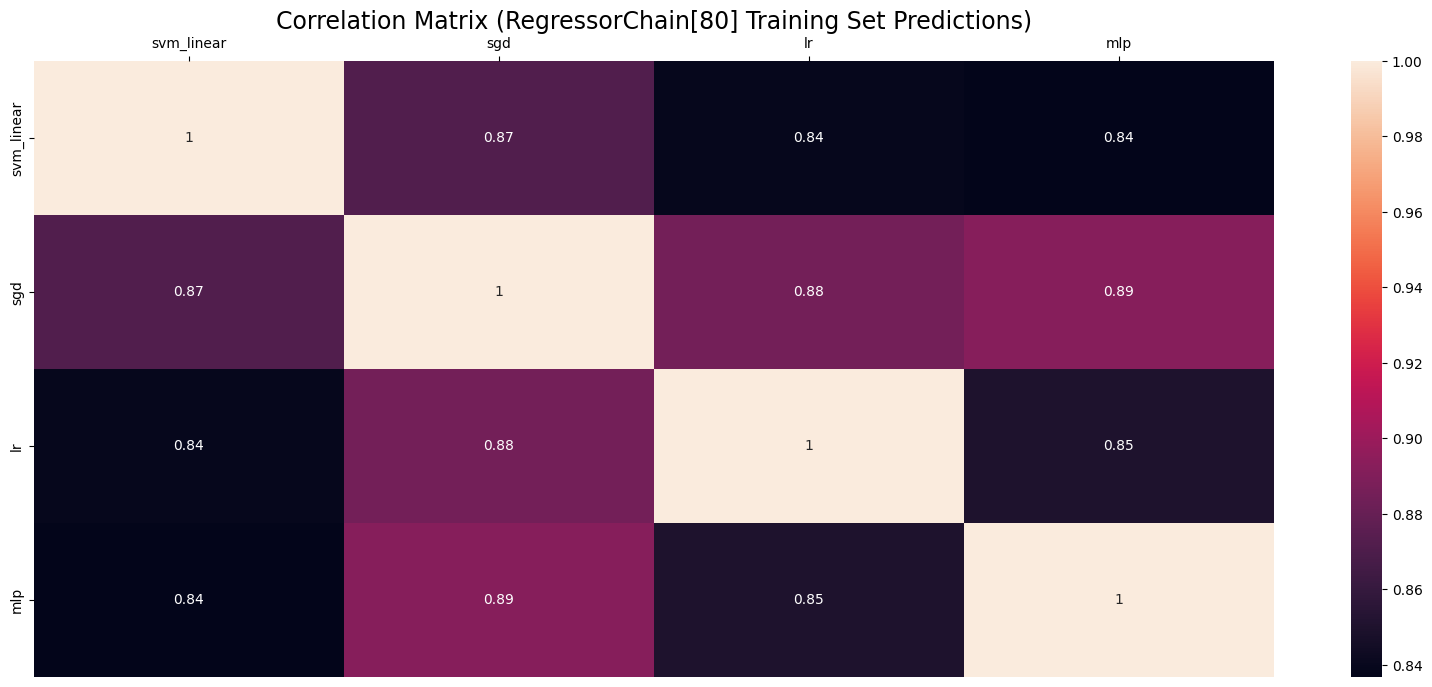

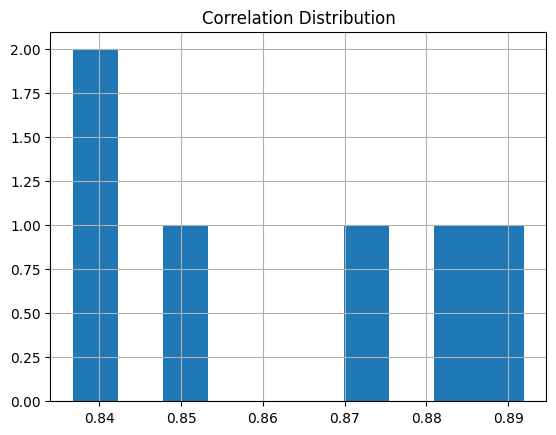

Training correlation distribution:
count    6.000000
mean     0.862366
std      0.023796
min      0.836775
25%      0.841593
50%      0.860924
75%      0.881613
max      0.891917
Name: corr, dtype: float64


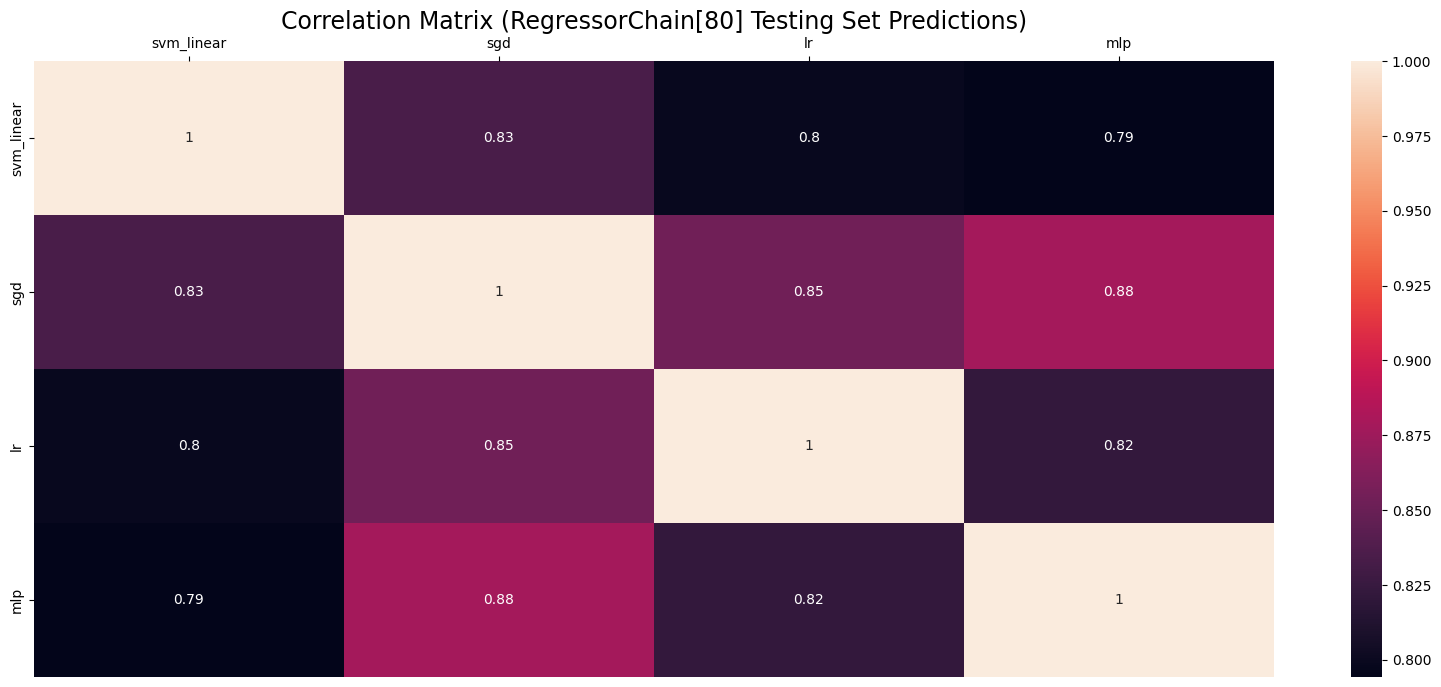

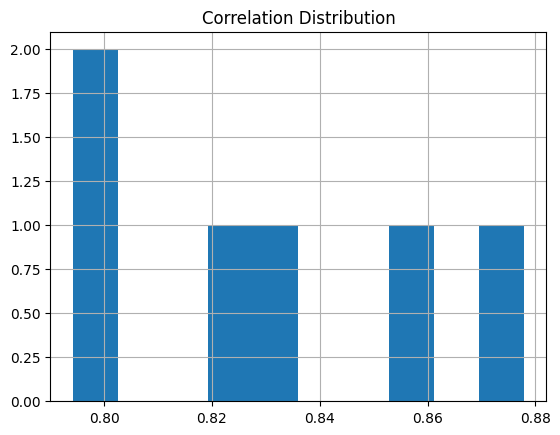

Testing correlation distribution:
count    6.000000
mean     0.829994
std      0.032194
min      0.794237
25%      0.804441
50%      0.827914
75%      0.848533
max      0.877875
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0006
NMSE: 0.0198
MAE: 0.1445
NMAE: 0.3709
aRRMSE: 0.3757
aCC: 0.9926


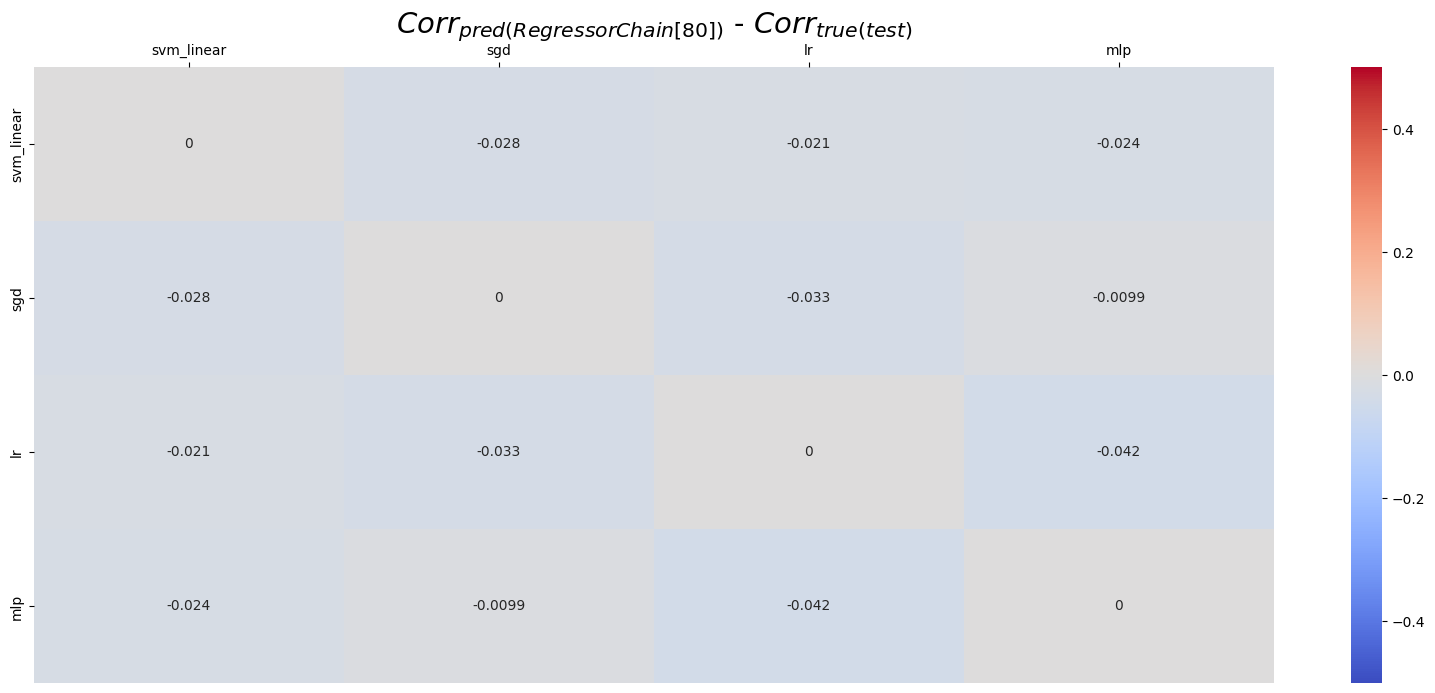

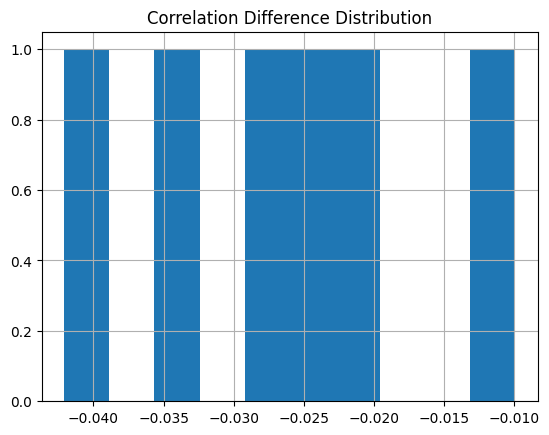

In [68]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 
# 80 chains

results = correlation_pred_performance(rc_plus, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]",
                                       show_plot=True, save_plot=None)

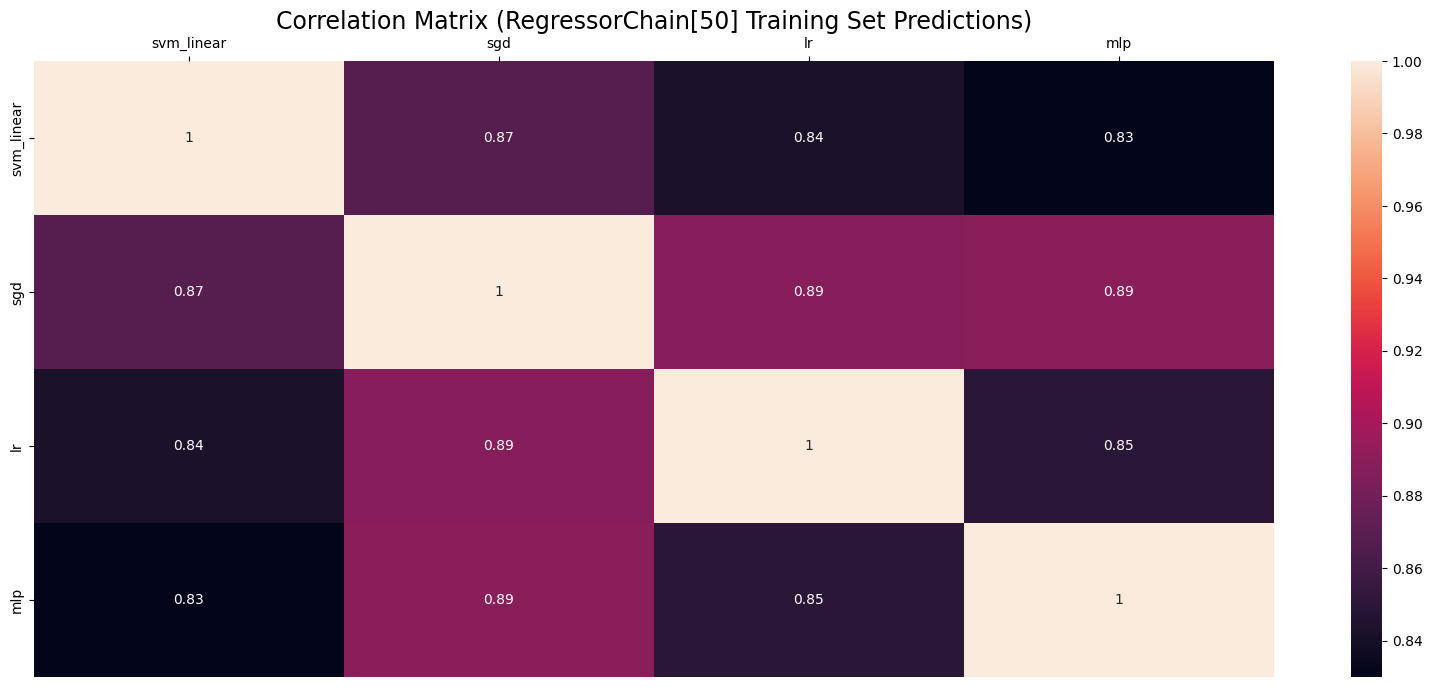

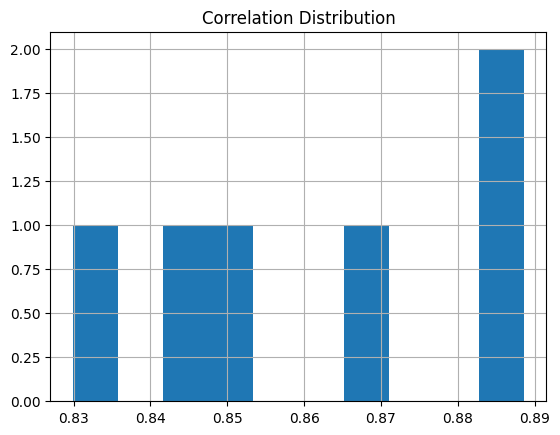

Training correlation distribution:
count    6.000000
mean     0.860990
std      0.024446
min      0.829931
25%      0.844051
50%      0.858604
75%      0.882891
max      0.888614
Name: corr, dtype: float64


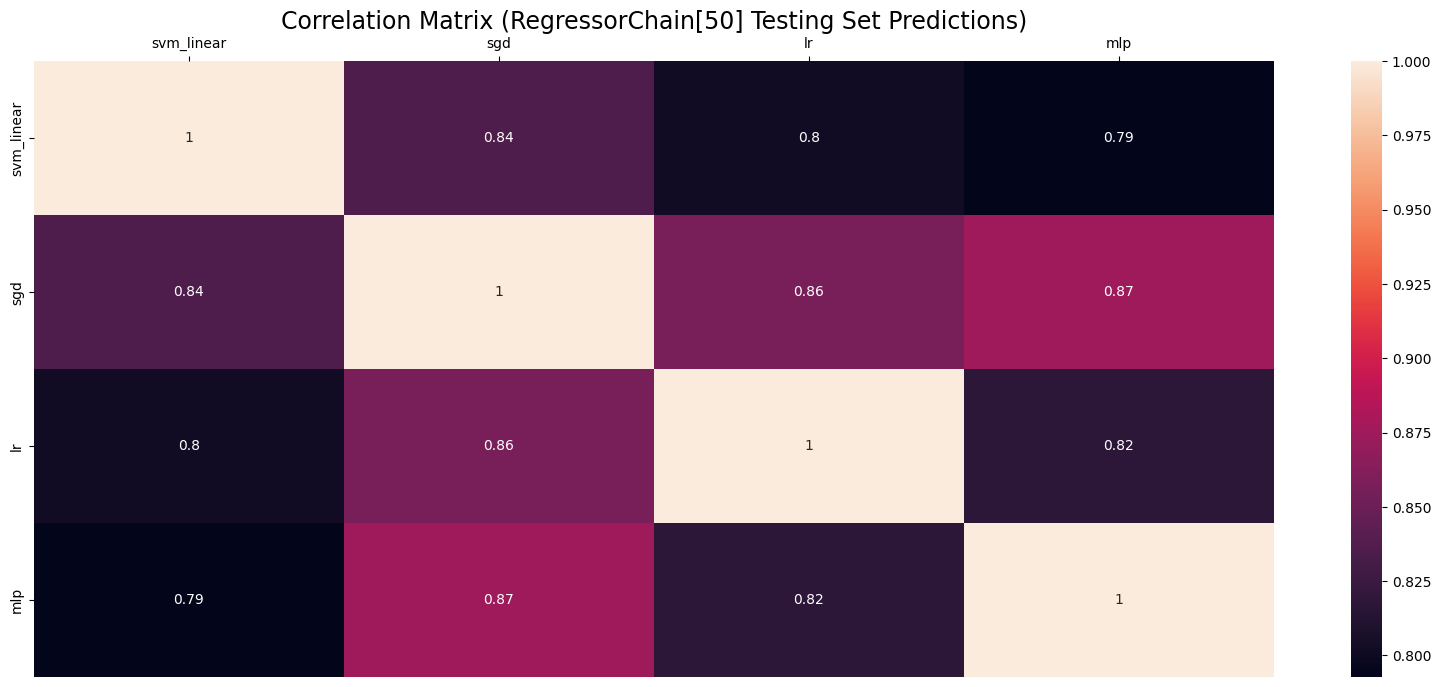

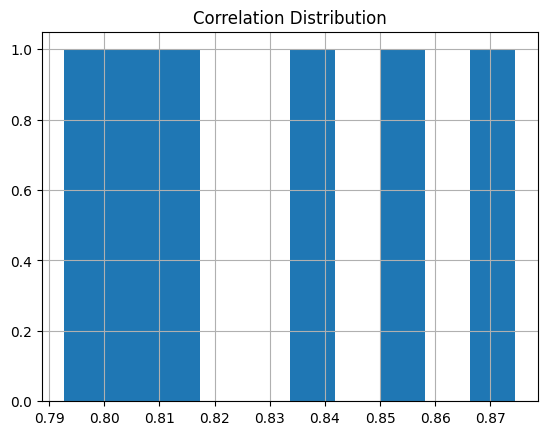

Testing correlation distribution:
count    6.000000
mean     0.829677
std      0.031759
min      0.792757
25%      0.805815
50%      0.826117
75%      0.851176
max      0.874491
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0006
NMSE: 0.0200
MAE: 0.1482
NMAE: 0.3756
aRRMSE: 0.3799
aCC: 0.9920


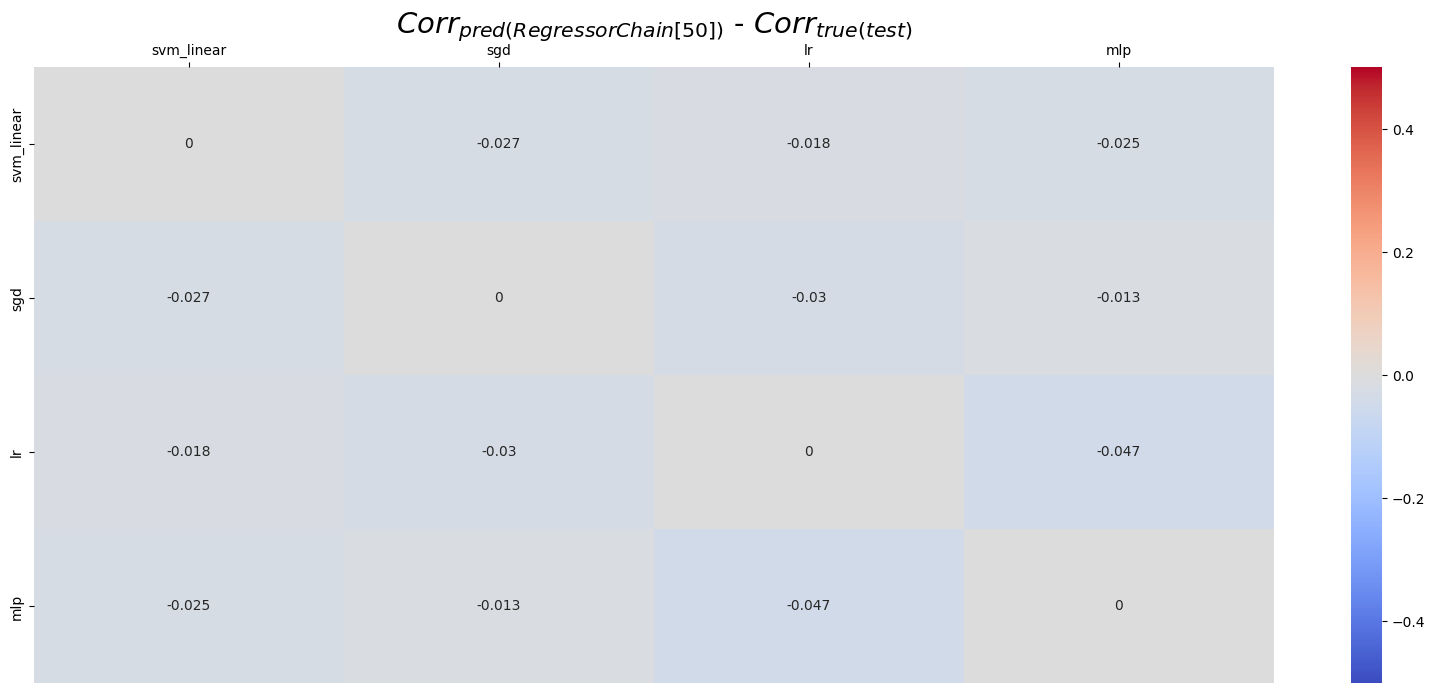

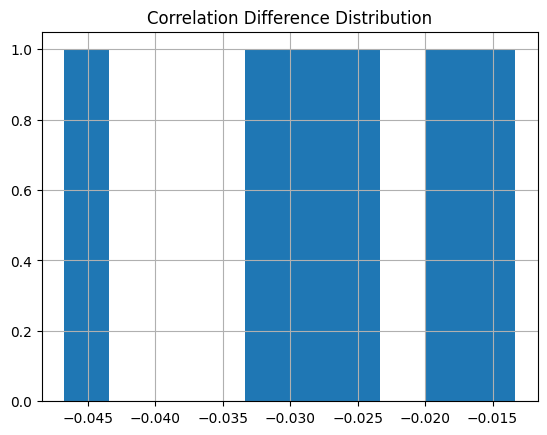

In [61]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 
# 50 chains

results = correlation_pred_performance(rc_plus, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]",
                                       show_plot=True, save_plot=None)

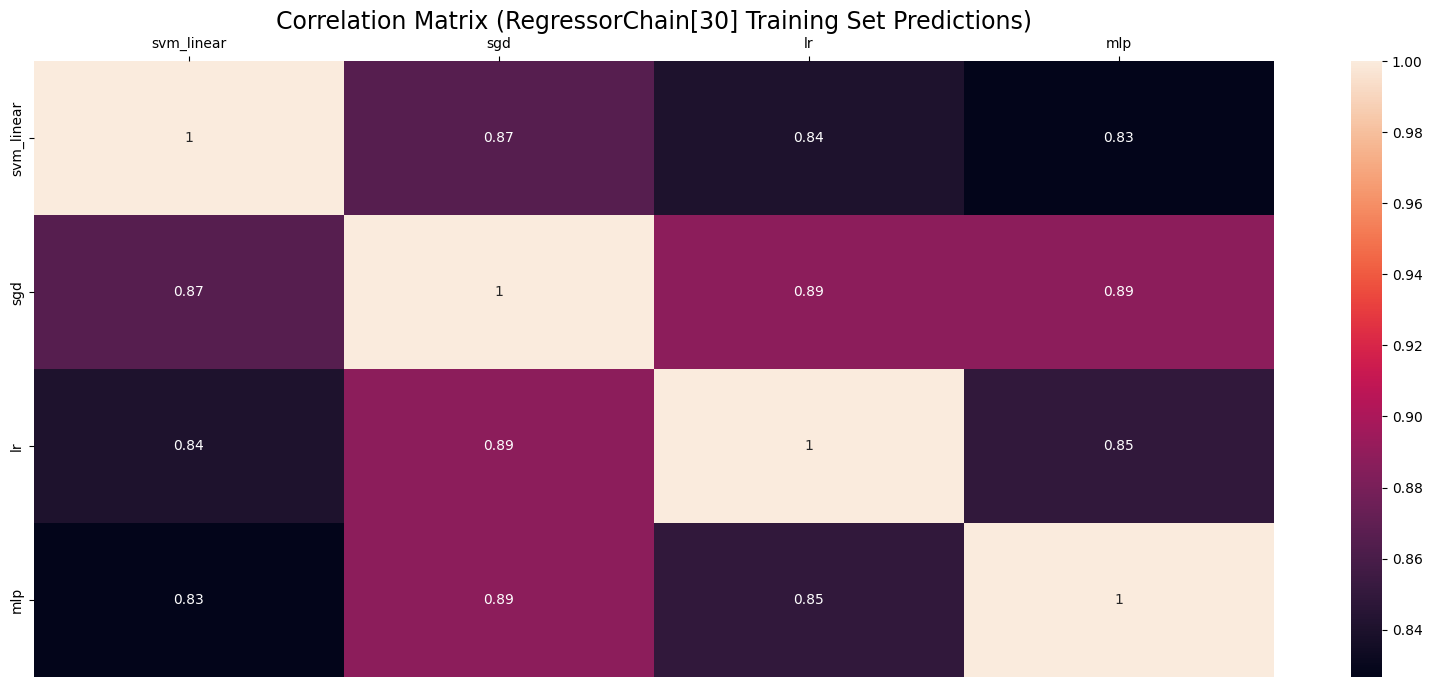

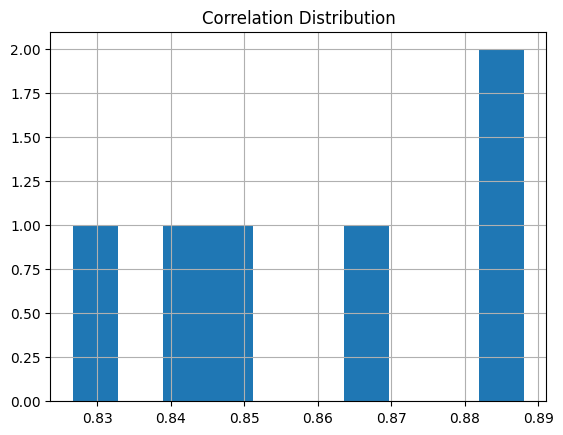

Training correlation distribution:
count    6.000000
mean     0.859692
std      0.025284
min      0.826706
25%      0.842812
50%      0.857384
75%      0.882340
max      0.888063
Name: corr, dtype: float64


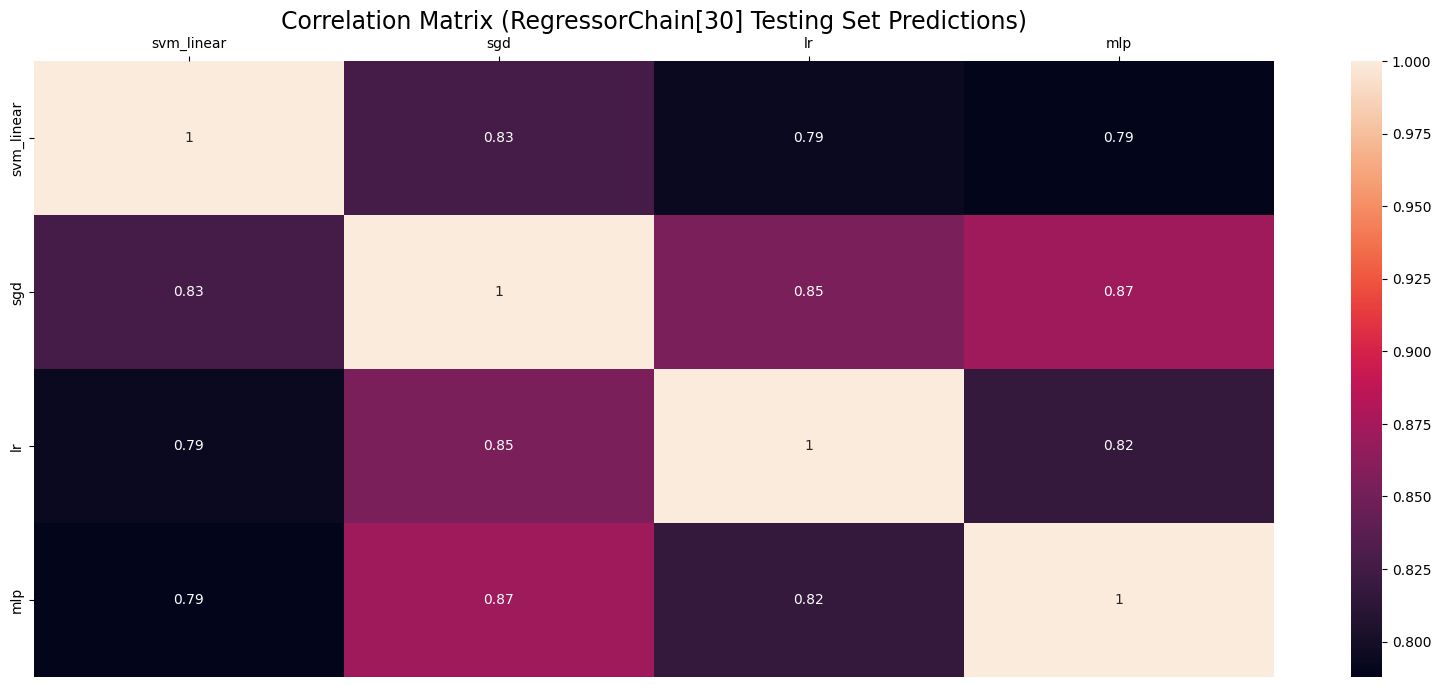

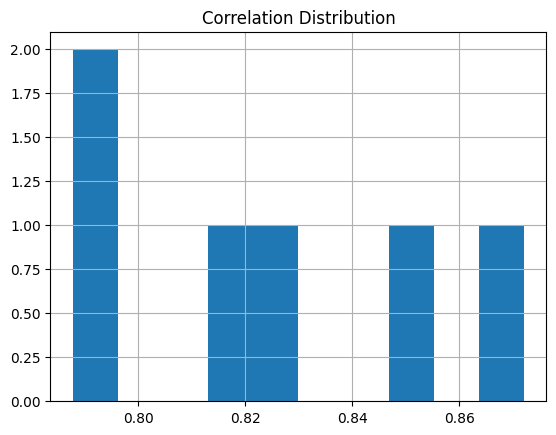

Testing correlation distribution:
count    6.000000
mean     0.825112
std      0.033196
min      0.787787
25%      0.799128
50%      0.822046
75%      0.846947
max      0.872059
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0008
NMSE: 0.0234
MAE: 0.1908
NMAE: 0.4385
aRRMSE: 0.4344
aCC: 0.9941


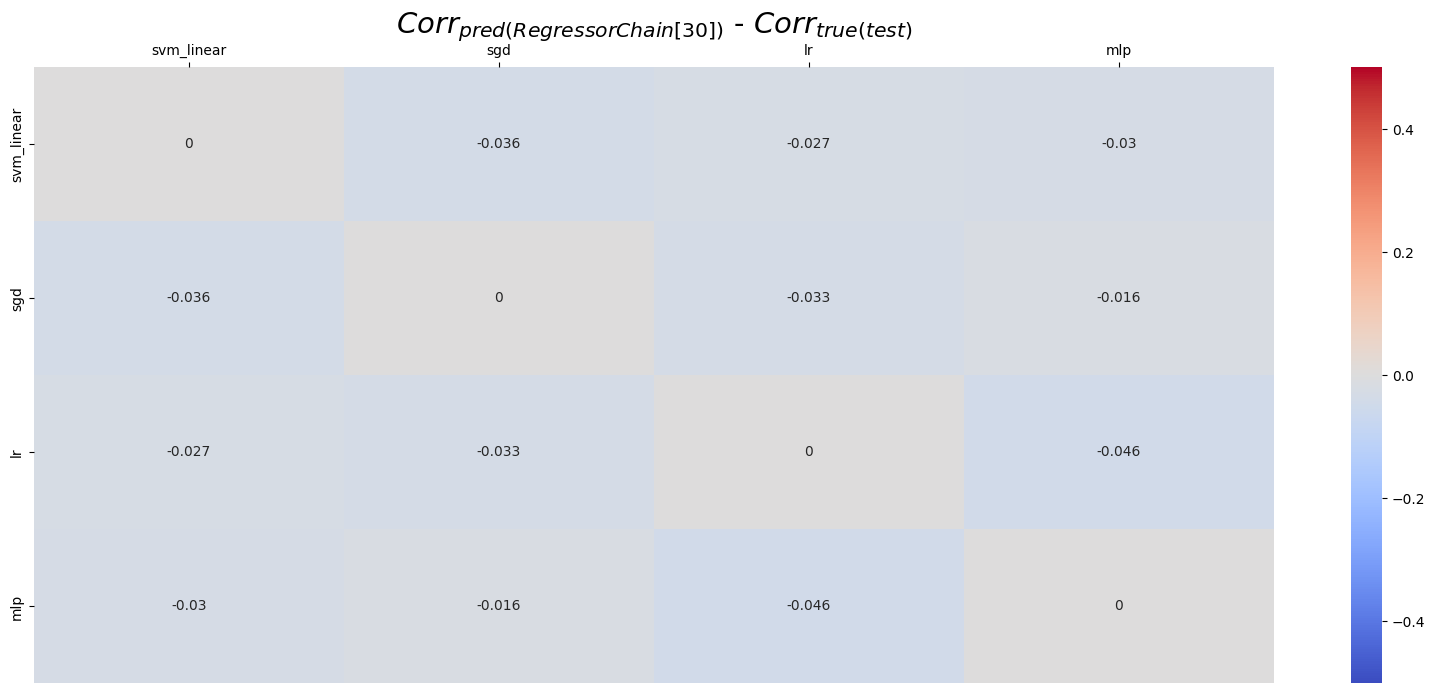

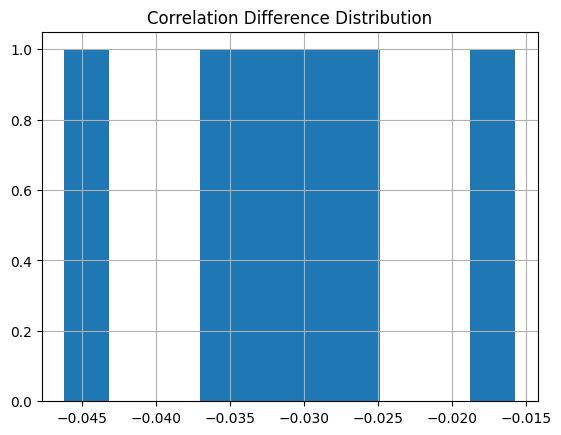

In [53]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 
#30chains
results = correlation_pred_performance(rc_plus, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]",
                                       show_plot=True, save_plot=None)

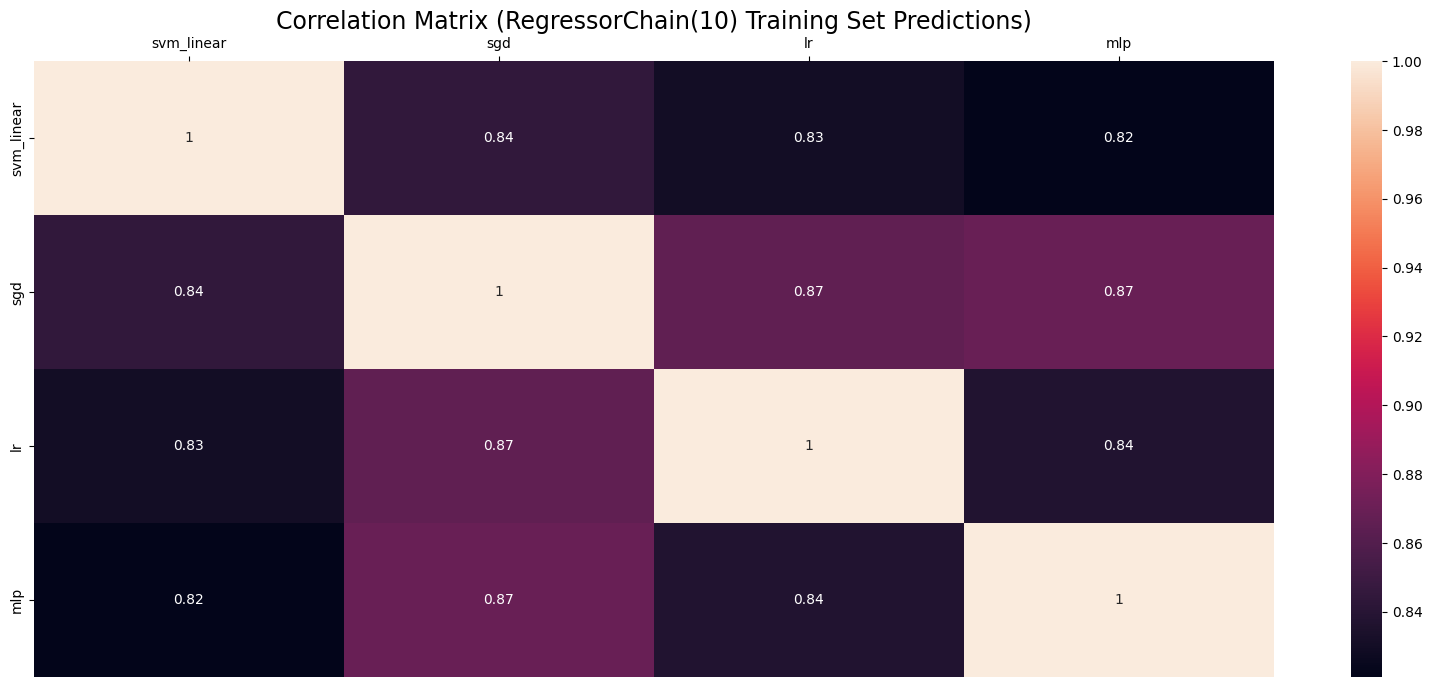

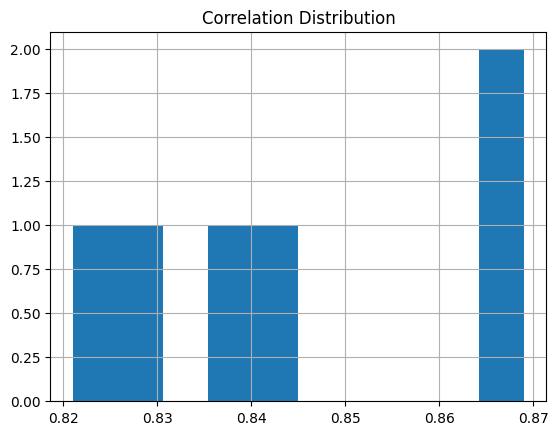

Training correlation distribution:
count    6.000000
mean     0.844366
std      0.019392
min      0.821042
25%      0.831445
50%      0.840354
75%      0.860295
max      0.869027
Name: corr, dtype: float64


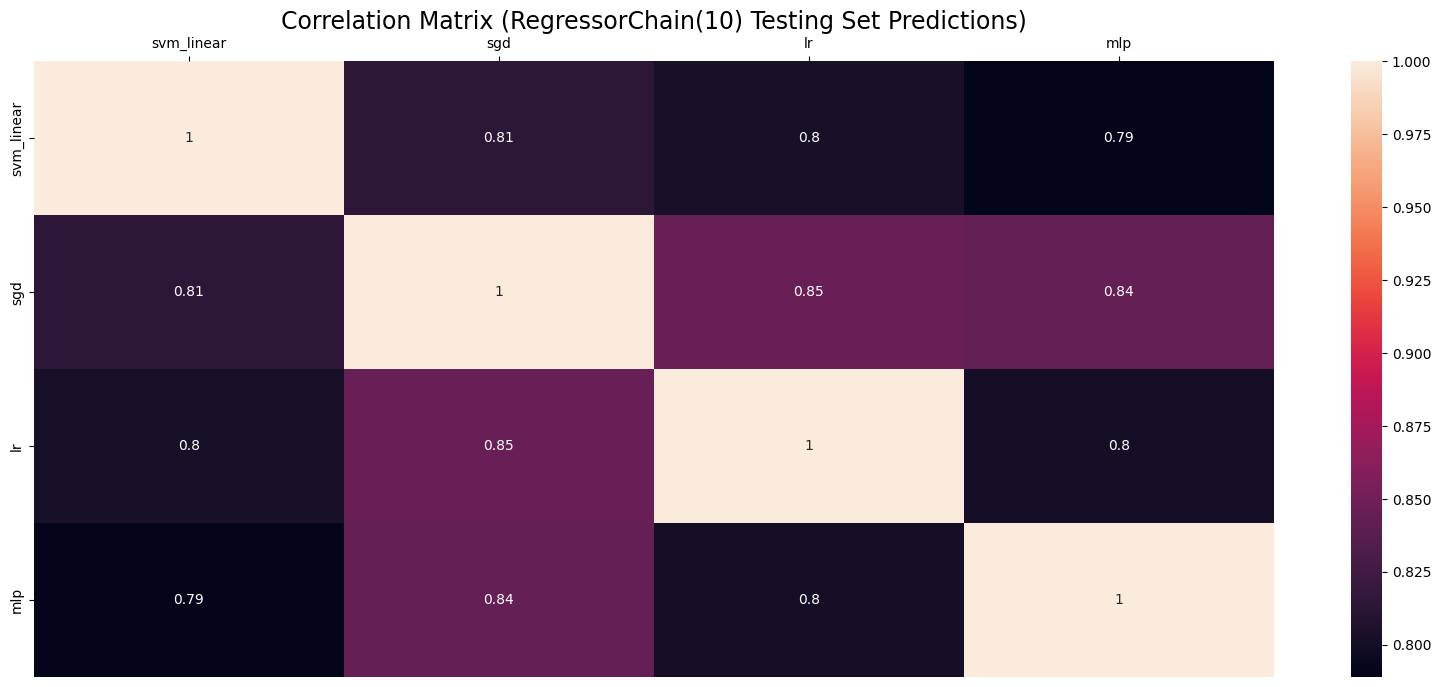

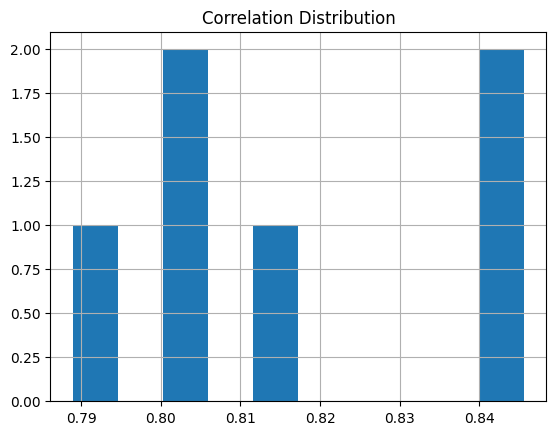

Testing correlation distribution:
count    6.000000
mean     0.816019
std      0.023513
min      0.788951
25%      0.801480
50%      0.808512
75%      0.836162
max      0.845625
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0014
NMSE: 0.0302
MAE: 0.3451
NMAE: 0.5755
aRRMSE: 0.5756
aCC: 0.9839


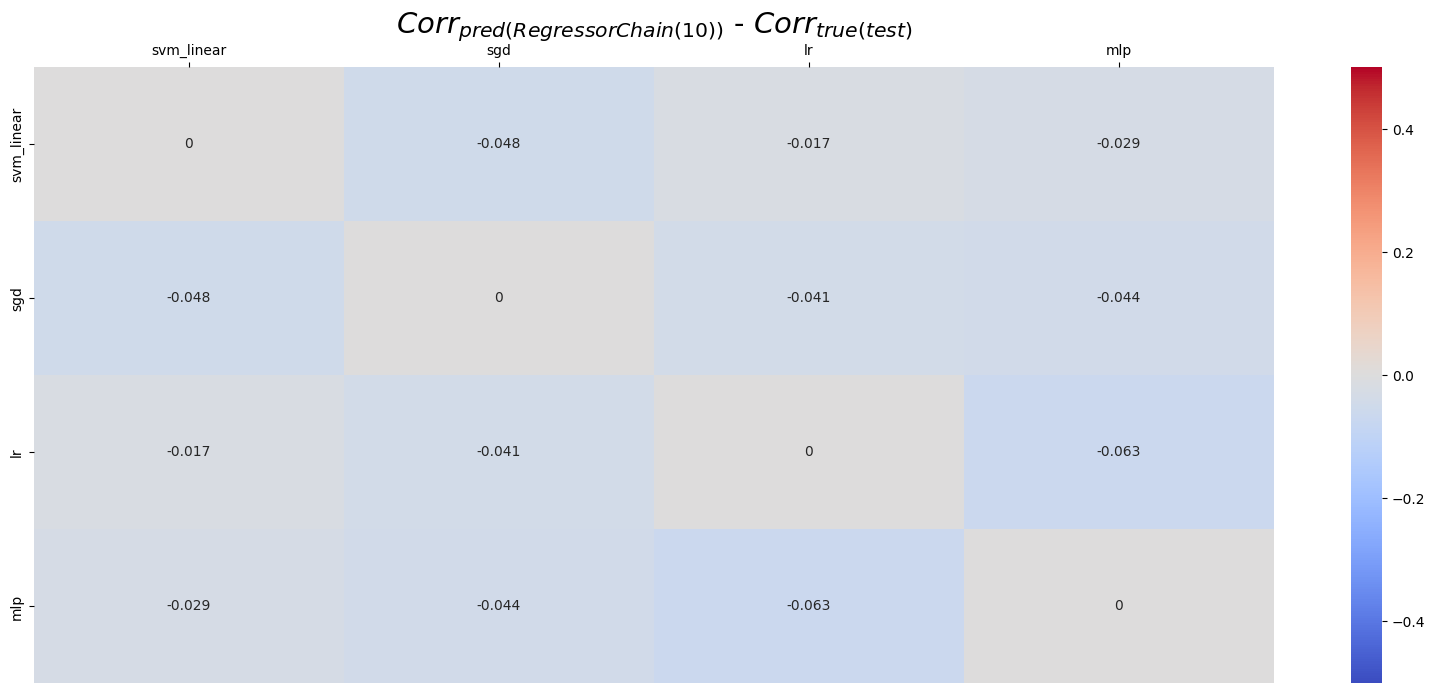

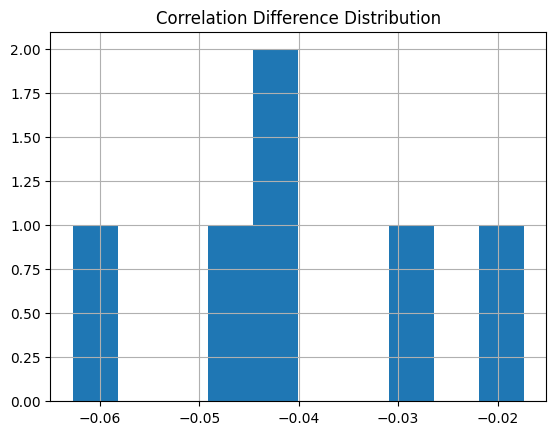

In [37]:
#regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
#                               index=Xa_train.index,
#                               columns=model_names).corr('kendall') 
#10 chains
results = correlation_pred_performance(rc_plus, Xa_test, ya_test, Xa_train, 
                                       min_score=MIN_SCORE, name=f"RegressorChain({num_chains})",
                                       show_plot=True, save_plot=None)

In [69]:
diff_metrics.loc[rc_ac,:] = results['results']
diff_metrics.loc[rc_ac,:]

MSE       0.000596
MAE       0.019763
NMSE      0.144451
NMAE      0.370874
aRRMSE     0.37567
aCC       0.992568
Name: RC[80], dtype: object

In [70]:
groups[f'regchain{num_chains}_assessor'] = results['groups']
groups[f'regchain{num_chains}_assessor']['test']

[['sgd', 'mlp'], ['svm_linear'], ['lr']]

### Multi-Output Random Forest Regressor 

In [23]:
mrf = RandomForestRegressor(random_state=seed).fit(Xa_train, ya_train)

In [24]:
metrics_df.loc['MRT',:] = assr_performance(mrf, Xa_test, ya_test, Xa_train, ya_train)

[TRAINING SET]
MSE: 0.0062
NMSE: 0.1261
MAE: 0.0583
NMAE: 0.3385
aRRMSE: 0.3550
aCC: 0.9803

[TESTING SET]
MSE: 0.0387
NMSE: 0.8257
MAE: 0.1481
NMAE: 0.8830
aRRMSE: 0.9077
aCC: 0.4294


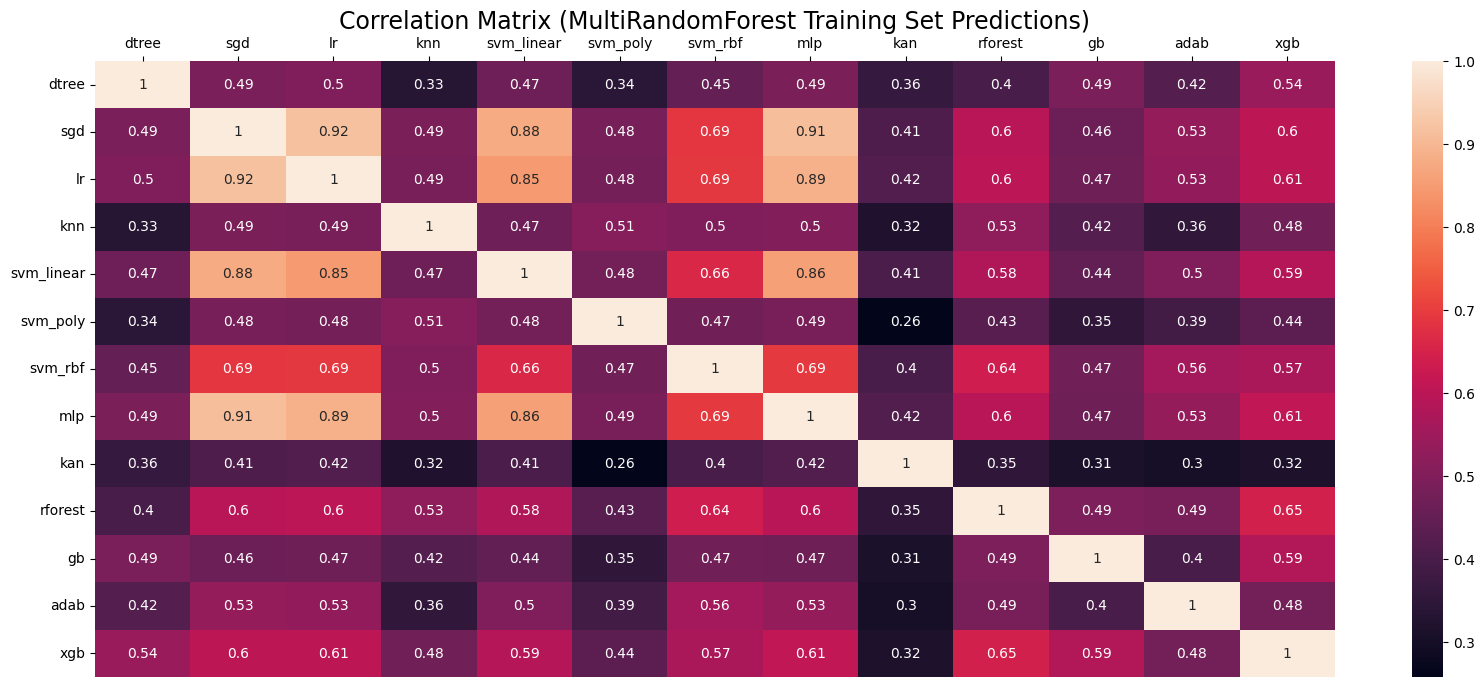

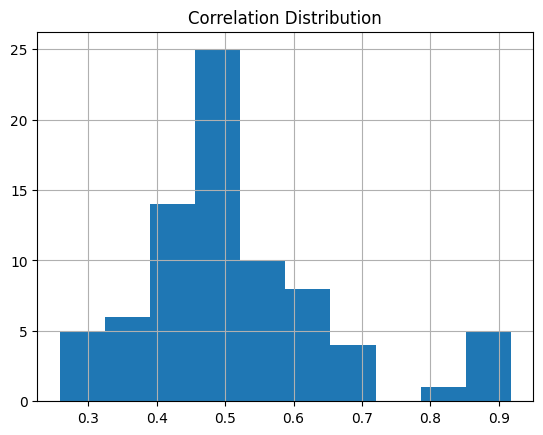

Training correlation distribution:
count    78.000000
mean      0.513167
std       0.143692
min       0.258368
25%       0.421716
50%       0.485992
75%       0.583677
max       0.917483
Name: corr, dtype: float64


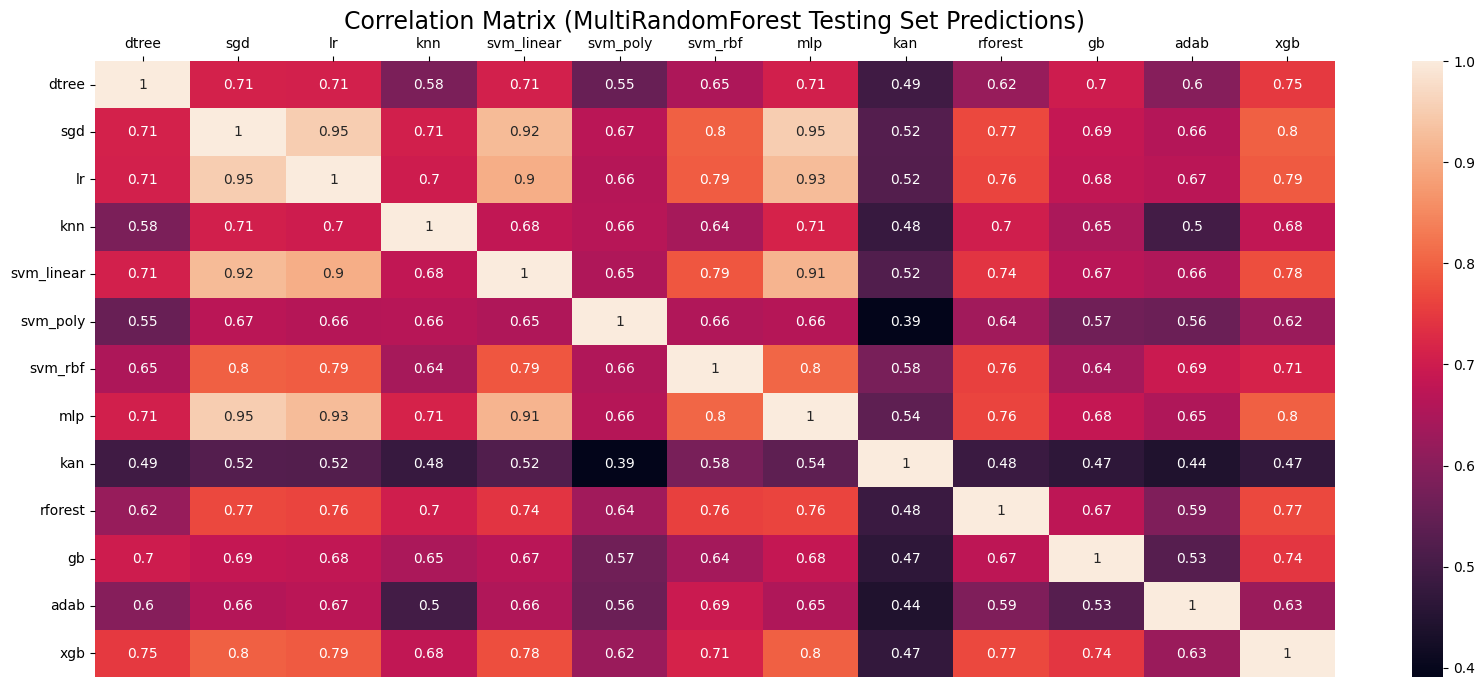

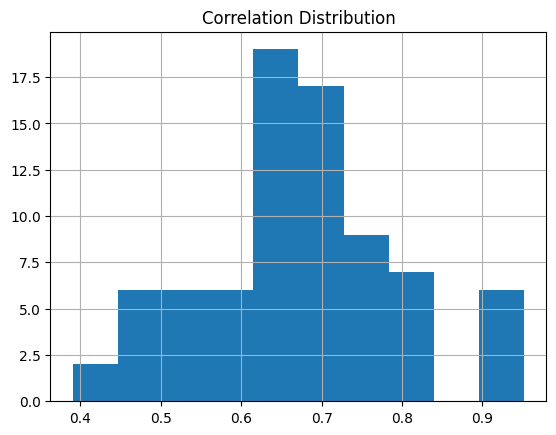

Testing correlation distribution:
count    78.000000
mean      0.673855
std       0.120333
min       0.390854
25%       0.602591
50%       0.672112
75%       0.748374
max       0.951573
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0426
NMSE: 0.1850
MAE: 1.3085
NMAE: 1.5559
aRRMSE: 1.1178
aCC: 0.9269


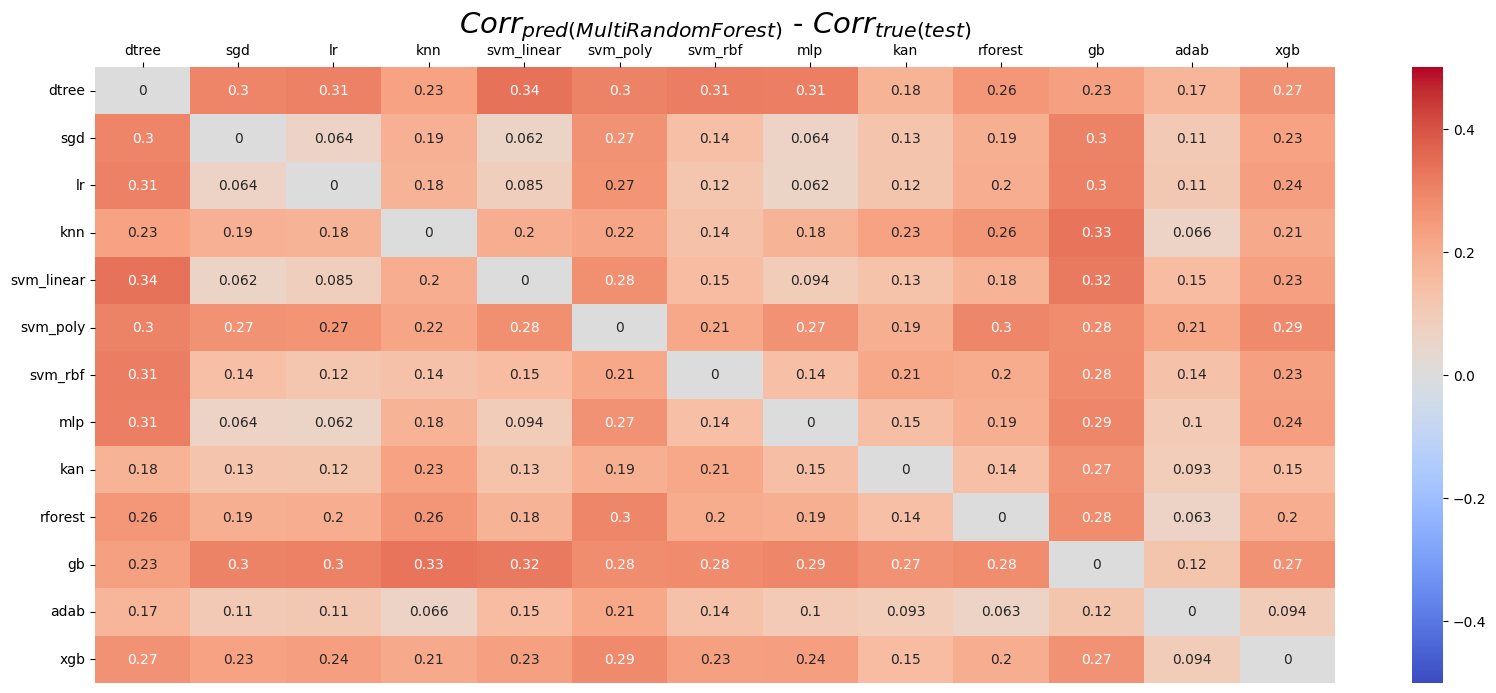

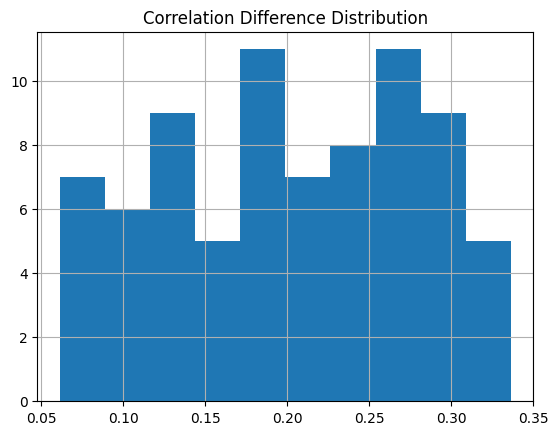

In [25]:
results = correlation_pred_performance(mrf, Xa_test, ya_test, Xa_train, 
                                       MIN_SCORE, name="MultiRandomForest")

In [26]:
diff_metrics.loc['MRT',:] = results['results']
diff_metrics.loc['MRT',:]

MSE       0.042634
MAE       0.185016
NMSE      1.308456
NMAE      1.555901
aRRMSE    1.117812
aCC       0.926861
Name: MRT, dtype: object

In [27]:
groups['mrf_assessor'] = results['groups']
groups['mrf_assessor']['test']

[['kan'],
 ['mlp', 'sgd', 'svm_linear', 'lr', 'dtree', 'gb', 'xgb'],
 ['rforest', 'mlp', 'svm_linear', 'sgd', 'knn', 'lr', 'gb', 'xgb'],
 ['mlp', 'svm_linear', 'sgd', 'svm_rbf', 'lr', 'adab'],
 ['mlp', 'svm_linear', 'sgd', 'svm_rbf', 'svm_poly', 'lr'],
 ['mlp', 'sgd', 'svm_linear', 'svm_rbf', 'lr', 'dtree', 'xgb'],
 ['rforest', 'mlp', 'svm_linear', 'sgd', 'svm_rbf', 'lr', 'xgb'],
 ['mlp', 'svm_linear', 'sgd', 'svm_poly', 'knn', 'lr']]

### Multi-Output SVR

In [28]:
#msvr = MSVR()
#msvr.fit(np.asarray(Xa_train_norm), np.asarray(ya_train))
#msvr_params = product(svm_rbf_params)
#g_search = GridSearchCV(MSVR(), svm_rbf_params, scoring='neg_mean_squared_error', n_jobs=-1).fit(np.asarray(Xa_train_norm), np.asarray(ya_train))
#print(g_search.best_params_)
#msvr = g_search.best_estimator_

In [29]:
#study_norm = OptunaStudy(Xa_train_norm, ya_train.values, 200)
#study_norm.search(MSVR)

In [30]:
msvr = MSVR().fit(Xa_train_norm, ya_train.values)

In [31]:
metrics_df.loc['M-SVR',:] = assr_performance(msvr, Xa_test_norm, ya_test, Xa_train_norm, ya_train)

[TRAINING SET]
MSE: 0.0209
NMSE: 0.5416
MAE: 0.1093
NMAE: 0.7021
aRRMSE: 0.7122
aCC: 0.7675

[TESTING SET]
MSE: 0.0452
NMSE: 1.4988
MAE: 0.1571
NMAE: 1.0558
aRRMSE: 1.1532
aCC: 0.3294


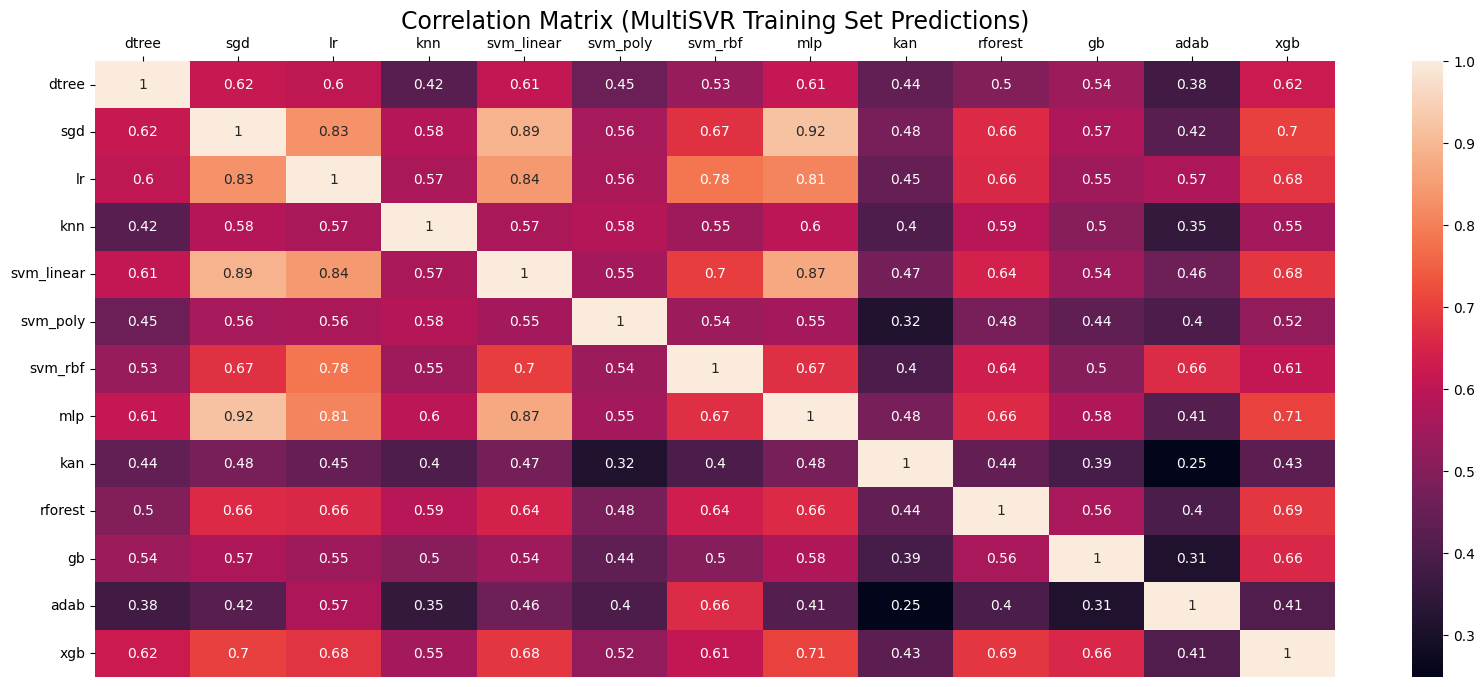

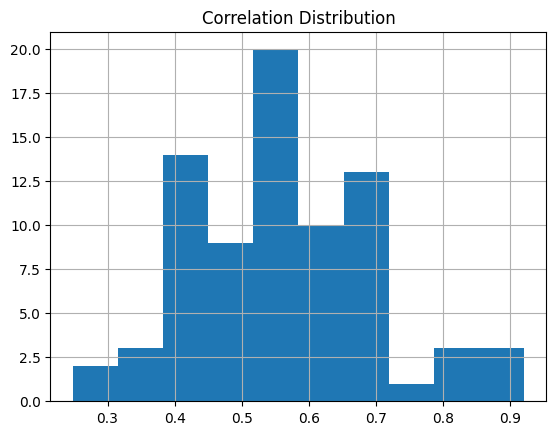

Training correlation distribution:
count    78.000000
mean      0.561379
std       0.137547
min       0.248535
25%       0.456067
50%       0.560118
75%       0.652684
max       0.920629
Name: corr, dtype: float64


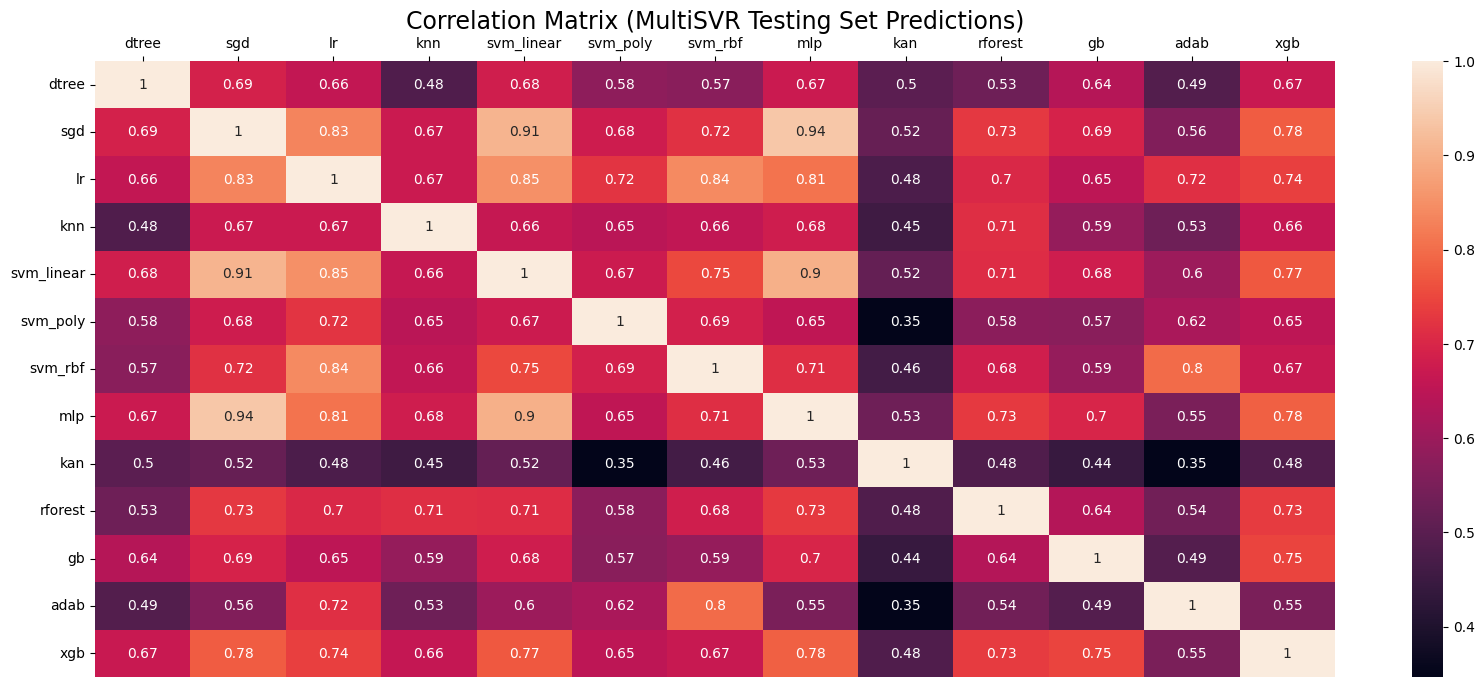

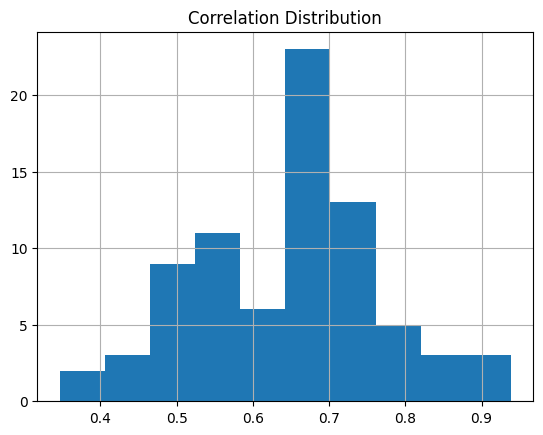

Testing correlation distribution:
count    78.000000
mean      0.645174
std       0.121801
min       0.346762
25%       0.552657
50%       0.665927
75%       0.715173
max       0.938356
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0356
NMSE: 0.1612
MAE: 1.0840
NMAE: 1.3560
aRRMSE: 1.0168
aCC: 0.8861


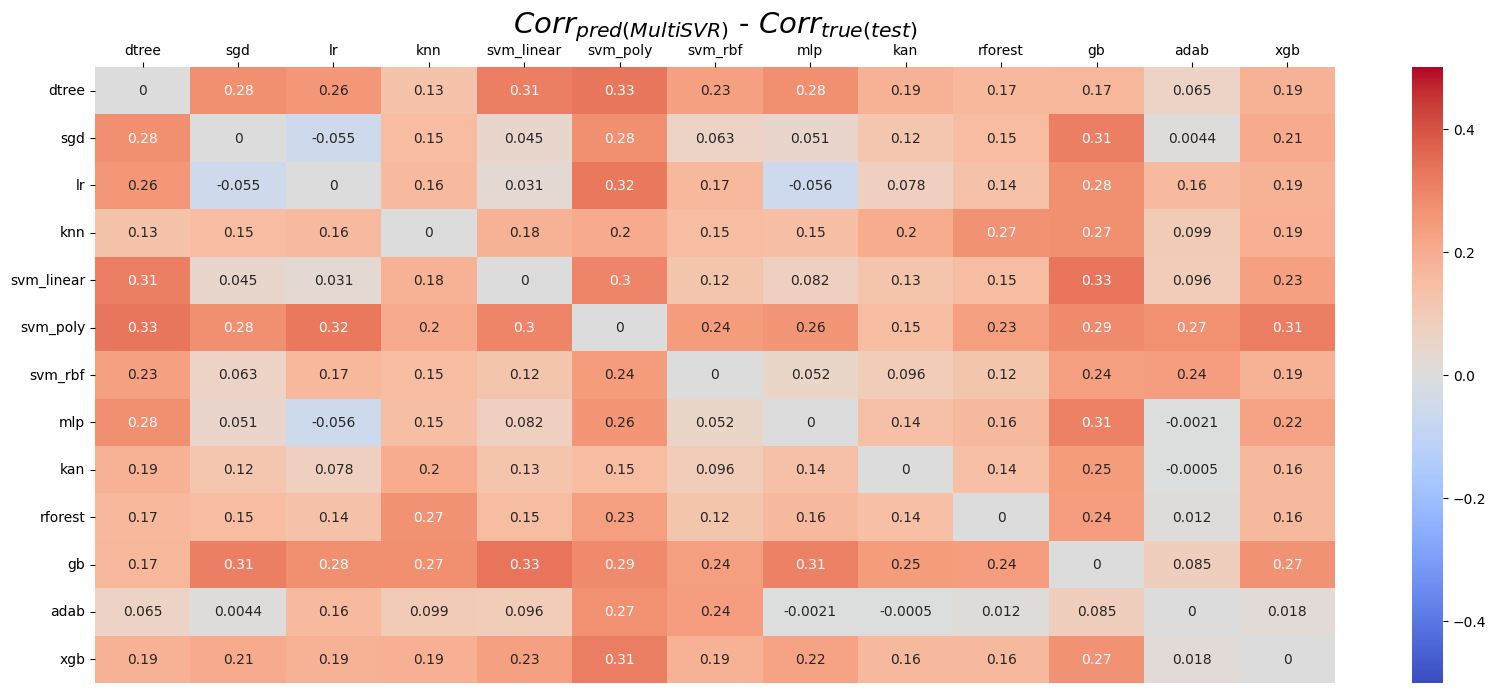

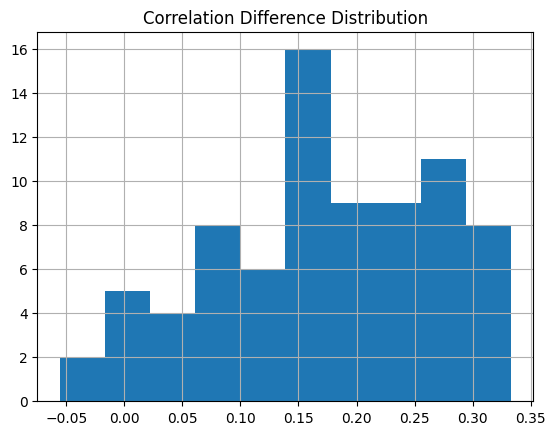

In [32]:
results = correlation_pred_performance(msvr, 
                                       pd.DataFrame(Xa_test_norm, index=Xa_test.index), 
                                       ya_test,
                                       pd.DataFrame(Xa_train_norm, index=Xa_train.index), 
                                       MIN_SCORE, name="MultiSVR")

In [33]:
diff_metrics.loc['M-SVR',:] = results['results']
diff_metrics.loc['M-SVR',:]

MSE       0.035598
MAE       0.161212
NMSE      1.083956
NMAE      1.356016
aRRMSE    1.016842
aCC       0.886117
Name: M-SVR, dtype: object

In [34]:
groups['msvr_assessor'] = results['groups']
groups['msvr_assessor']['test']

[['kan'],
 ['mlp', 'svm_linear', 'sgd', 'lr', 'dtree', 'xgb'],
 ['mlp', 'svm_linear', 'sgd', 'lr', 'gb', 'xgb'],
 ['rforest', 'mlp', 'svm_linear', 'sgd', 'svm_rbf', 'knn', 'lr', 'xgb'],
 ['mlp', 'svm_linear', 'sgd', 'svm_rbf', 'svm_poly', 'knn', 'lr', 'xgb'],
 ['svm_rbf', 'lr', 'adab']]

### Multi-Output Regressor 
(ST)

In [35]:
#mtr_params = getAssrParams(RandomForestRegressor, parameters, seed, False, 'estimator')
#
##mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)
#g_search = GridSearchCV(MultiOutputRegressor(RandomForestRegressor()), mtr_params, n_jobs=-1, verbose=True, scoring="neg_mean_absolute_error").fit(Xa_train, ya_train)
#print(g_search.best_params_)
#mor = g_search.best_estimator_

In [36]:
#study = OptunaStudy(Xa_train, ya_train, 100)
#study.search(MultiOutputRegressor)

In [40]:
single_tgt = MultiOutputRegressor(RandomForestRegressor(random_state=seed), 
                                  n_jobs=-1).fit(Xa_train, ya_train)

In [41]:
metrics_df.loc['ST',:] = assr_performance(single_tgt, Xa_test, ya_test, Xa_train, ya_train)

[TRAINING SET]
MSE: 0.0048
NMSE: 0.1208
MAE: 0.0527
NMAE: 0.3233
aRRMSE: 0.3476
aCC: 0.9768

[TESTING SET]
MSE: 0.0272
NMSE: 0.7762
MAE: 0.1304
NMAE: 0.8476
aRRMSE: 0.8810
aCC: 0.4762


#### Análise das correlações

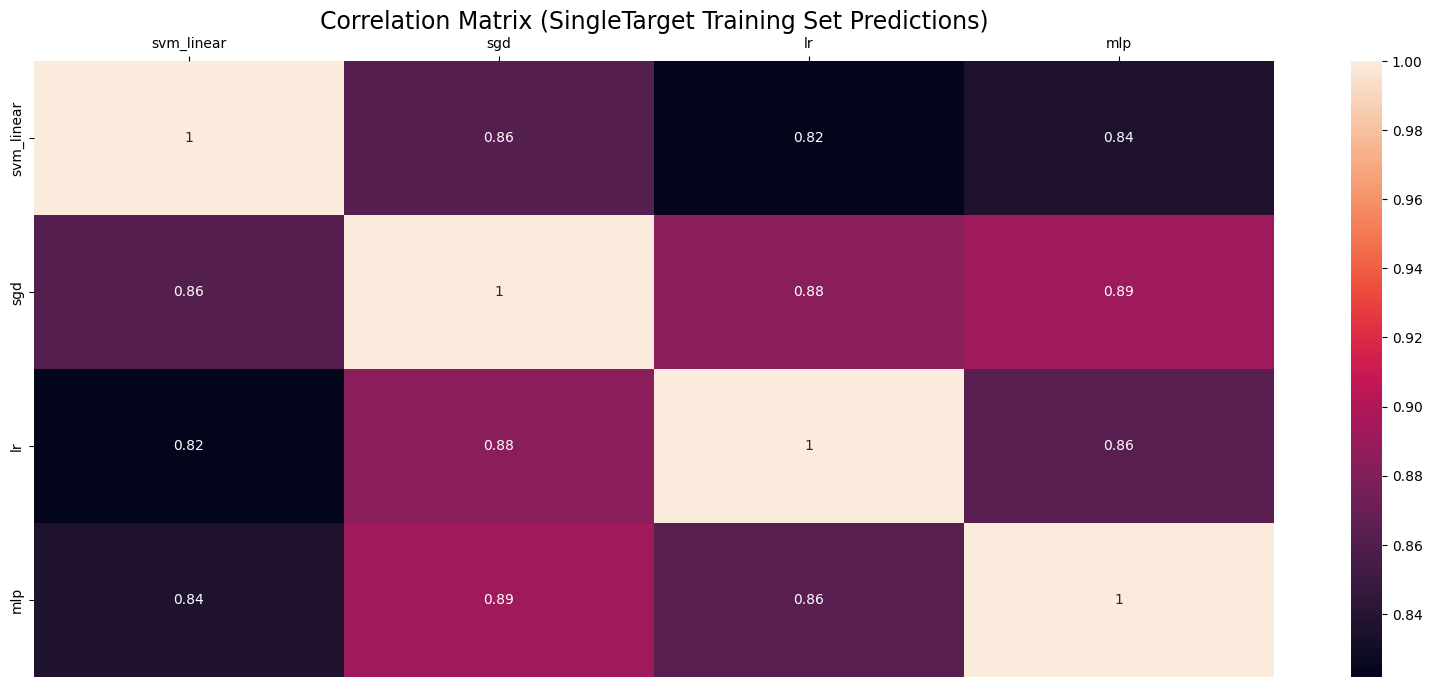

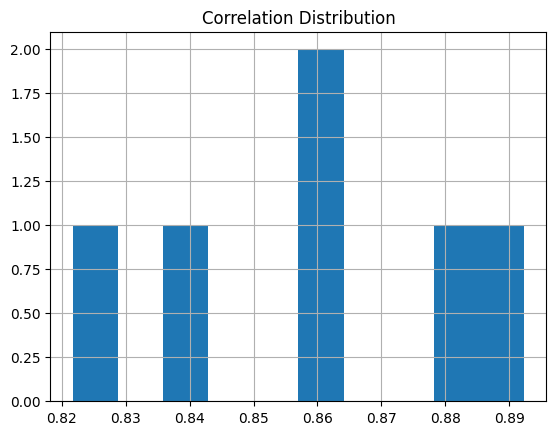

Training correlation distribution:
count    6.000000
mean     0.859548
std      0.026933
min      0.821750
25%      0.842262
50%      0.862144
75%      0.878014
max      0.892311
Name: corr, dtype: float64


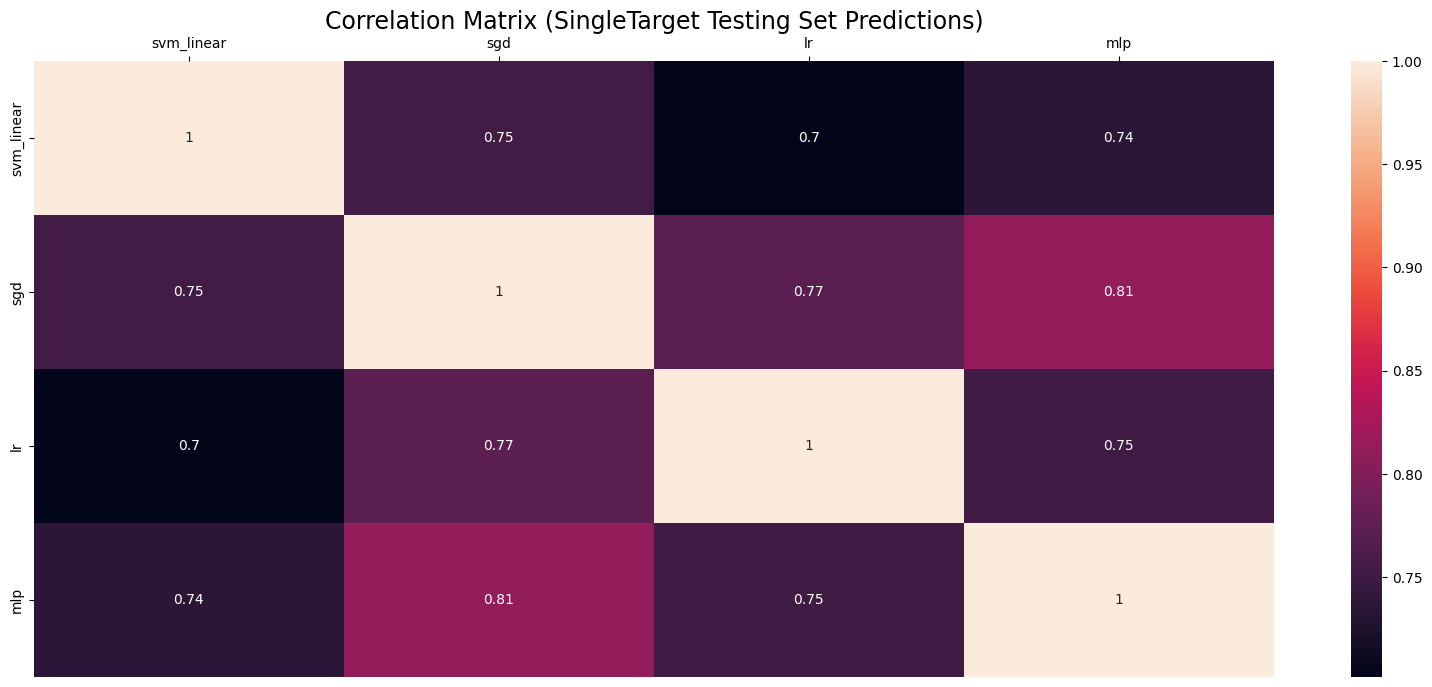

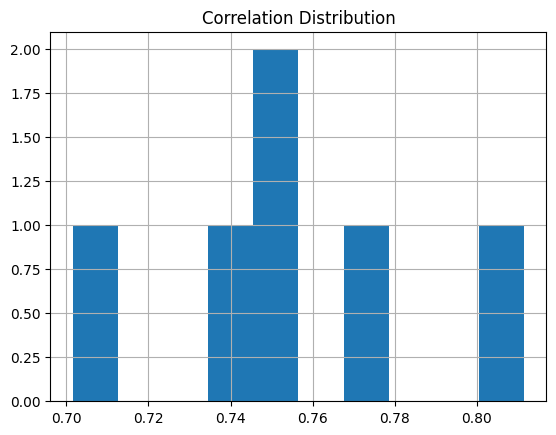

Testing correlation distribution:
count    6.000000
mean     0.754533
std      0.036585
min      0.701612
25%      0.739995
50%      0.753159
75%      0.767433
max      0.811472
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0080
NMSE: 0.0764
MAE: 1.9439
NMAE: 1.4338
aRRMSE: 1.3809
aCC: 0.9871


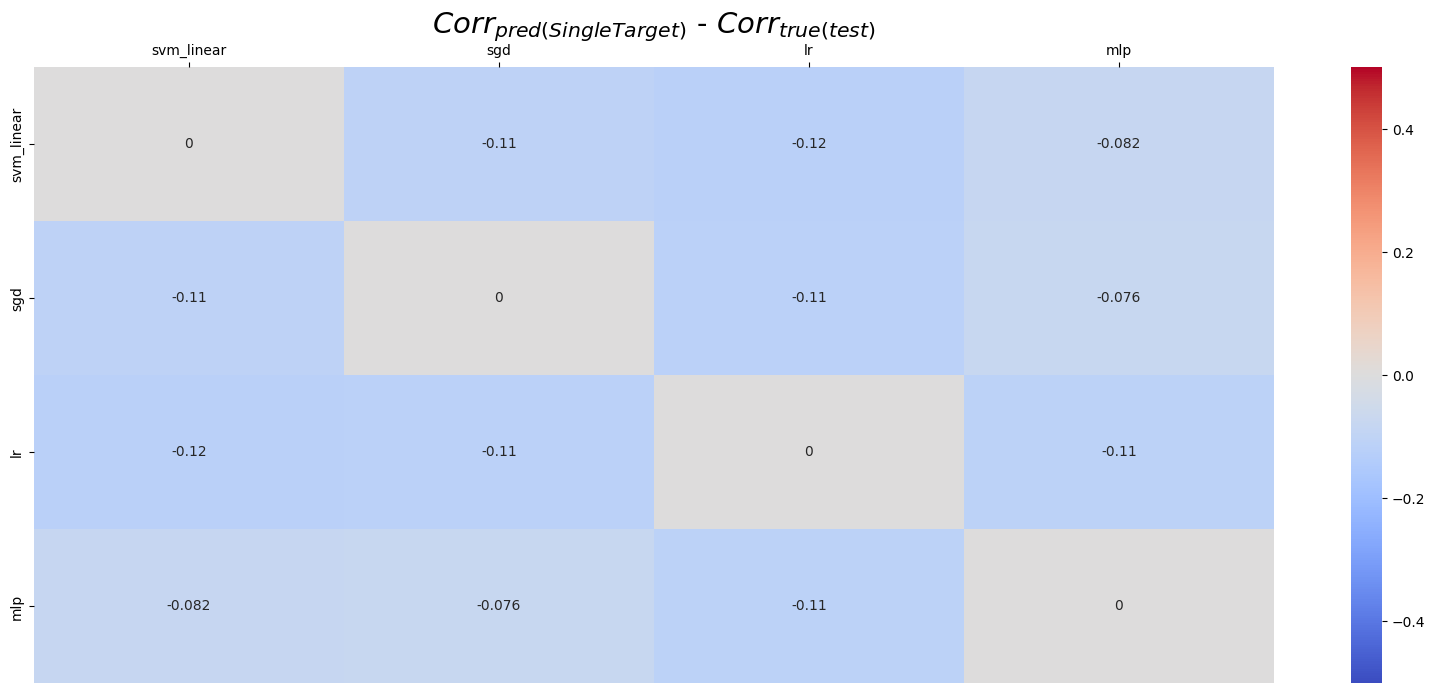

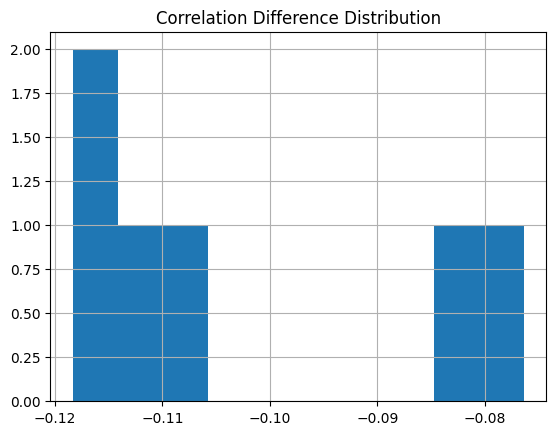

In [42]:
results = correlation_pred_performance(single_tgt, Xa_test, ya_test, Xa_train,
                                       MIN_SCORE, name="SingleTarget")

In [43]:
diff_metrics.loc['ST',:] = results['results']
diff_metrics.loc['ST',:]

MSE       0.007976
MAE       0.076358
NMSE      1.943884
NMAE      1.433795
aRRMSE    1.380917
aCC       0.987066
Name: ST, dtype: object

In [44]:
groups['st_assessor'] = results['groups']
groups['st_assessor']['test']

[['sgd'], ['svm_linear'], ['mlp'], ['lr']]

## Grupais

In [42]:
#keys = list(groups.keys())
#for i in range(len(keys)):
#    for j in range(i+1, len(keys)):
#        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
#        count = 0
#        for g in groups[keys[i]]:
#            if(g in groups[keys[j]]):
#                print(g)
#                count += 1
#        print(f'Número de grupos em comum: {count}\n\n')

In [56]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['sgd', 'mlp', 'lr']
total: 0.8952736807604064

['sgd', 'svm_linear']
total: 0.8725663716814162



### Regressor Chain

In [46]:
#[RegressorChain(base_estimator=RandomForestRegressor(random_state=seed),
#                random_state=seed,
#                order='random', cv=5) for _ in range(num_chains)]

rcg = GroupedAssessor([RegressorChain(base_estimator=RandomForestRegressor(random_state=seed),
                                      random_state=seed,
                                      order='random', 
                                      cv=5) for _ in range(len(groups['true_assessor_train']))])

rcg.fit(Xa_train, ya_train, groups=groups['true_assessor_train'])

[TRAINING SET]
MSE: 0.0090
NMSE: 0.2264
MAE: 0.0672
NMAE: 0.4116
aRRMSE: 0.4688
aCC: 0.9172

[TESTING SET]
MSE: 0.0279
NMSE: 0.7881
MAE: 0.1328
NMAE: 0.8615
aRRMSE: 0.8875
aCC: 0.4626


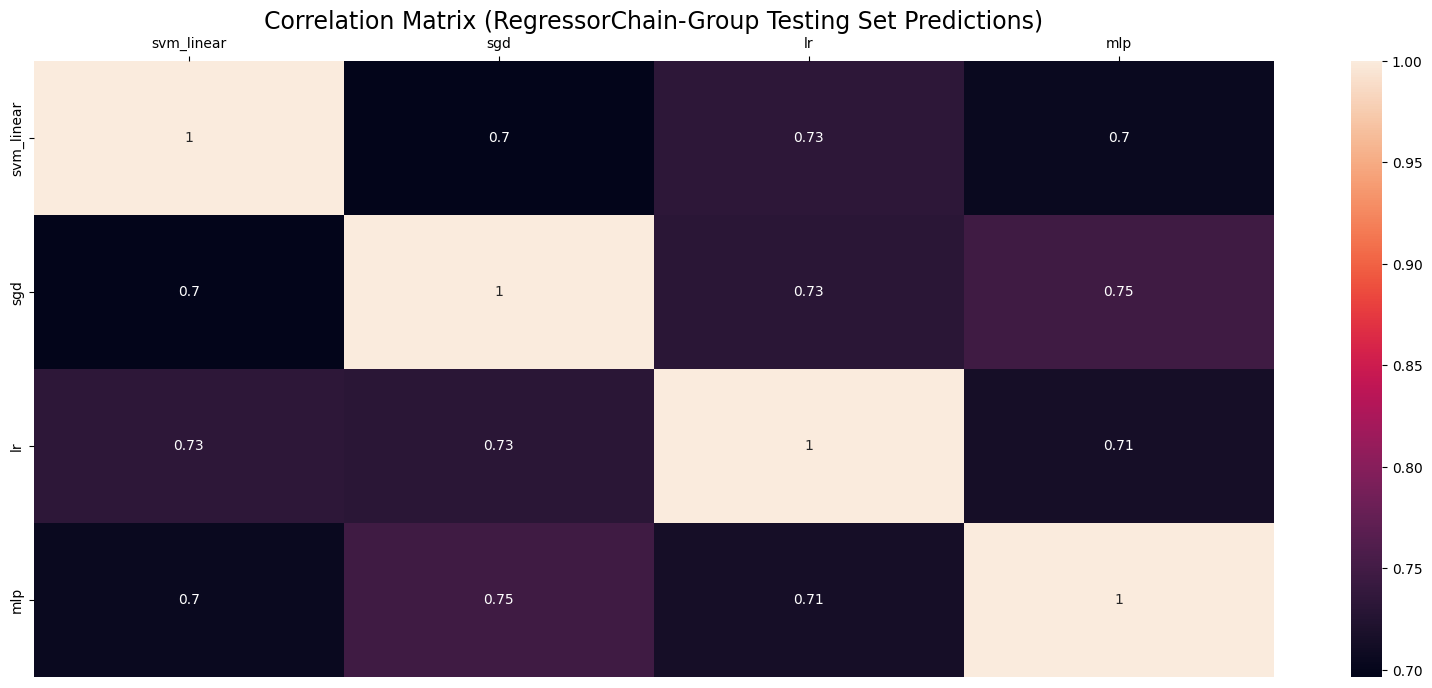

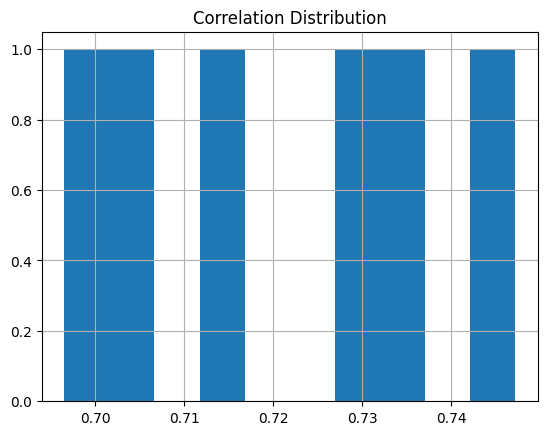

Testing correlation distribution:
count    6.000000
mean     0.720856
std      0.019098
min      0.696537
25%      0.706979
50%      0.721861
75%      0.732223
max      0.747185
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0143
NMSE: 0.1016
MAE: 3.6466
NMAE: 1.9290
aRRMSE: 1.8707
aCC: 0.9583


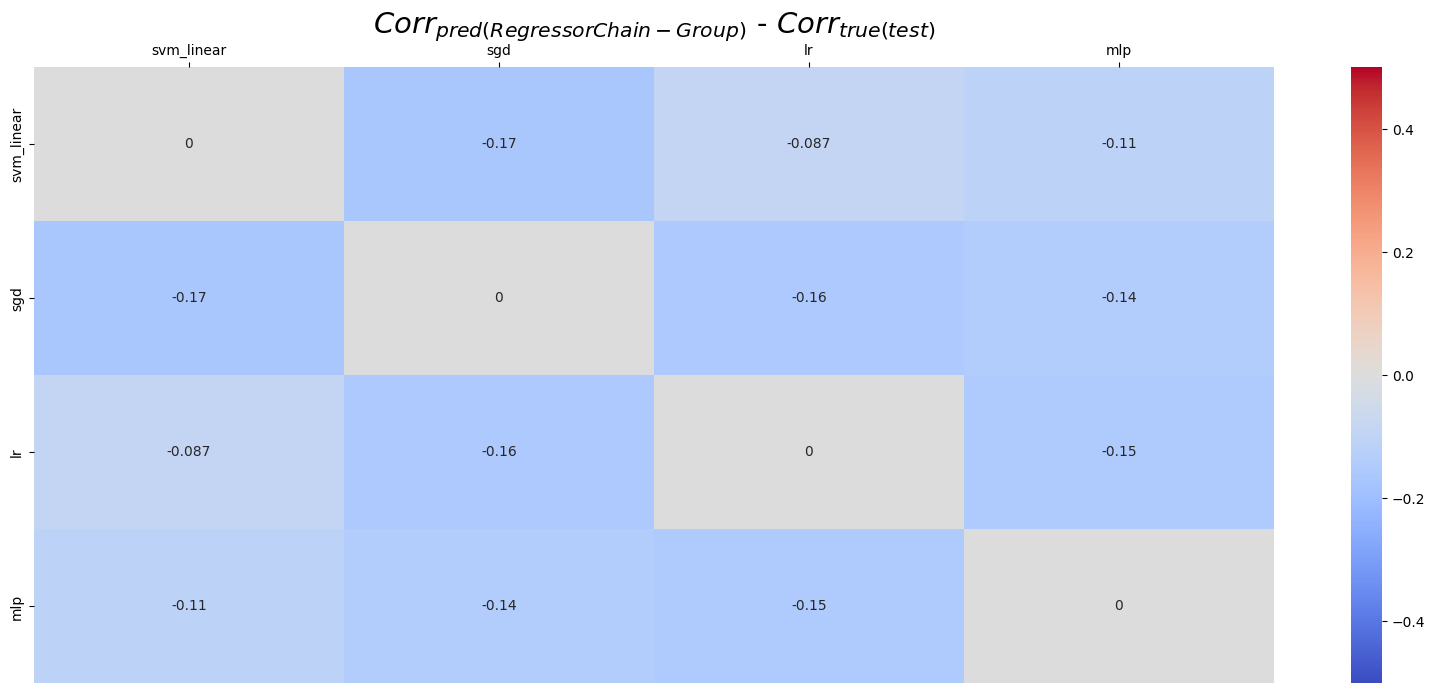

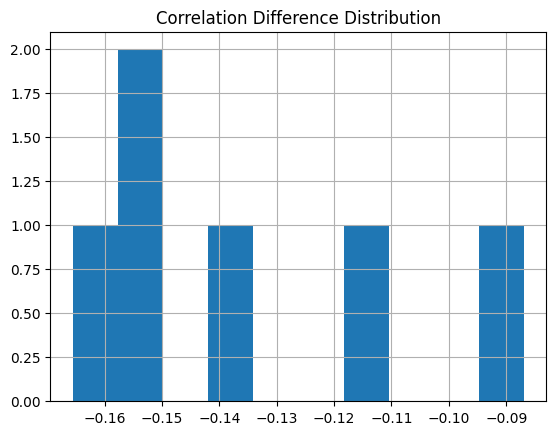

[['sgd'], ['svm_linear'], ['mlp'], ['lr']]


In [47]:
metrics_df.loc['RC(g)',:] = assr_performance(rcg, Xa_test, ya_test, Xa_train, ya_train)

results = correlation_pred_performance(rcg, Xa_test, ya_test, min_score=MIN_SCORE, name="RegressorChain-Group")

diff_metrics.loc['RC(g)',:] = results['results']

groups['rcg_assessor'] = results['groups']
print(groups['rcg_assessor']['test'])

In [48]:
results

{'results': [0.014322548443299369,
  0.1016157885547922,
  np.float64(3.6466301568348127),
  np.float64(1.9290083049339244),
  np.float64(1.8707321398189305),
  np.float64(0.9583484527808243)],
 'groups': {'test': [['sgd'], ['svm_linear'], ['mlp'], ['lr']]}}

### Ensemble of Regressor Chains

In [71]:
#rcg = GroupedAssessor(RegressorChain, model_names, random_state=seed)
#rcg.fit(Xa_train, ya_train, groups['true_assessor_train'], base_estimator=RandomForestRegressor(random_state=seed), 
#        random_state=seed, order='random', cv=5)

#rcg_plus = GroupedAssessor(VotingRegressor, model_names, random_state=seed,
#                           estimators=rc_ests, n_jobs=-1)

rcg_ac = f'RC[{num_chains}](g)'

rcg_plus = GroupedAssessor([GroupedAssessor([RegressorChain(
                                                base_estimator=RandomForestRegressor(random_state=seed),
                                                random_state=seed+i,
                                                order='random', cv=5) for i in range(num_chains)]
                                            ) for _ in range(len(groups['true_assessor_train']))])

rcg_plus.fit(Xa_train, ya_train, groups=groups['true_assessor_train'])

[TRAINING SET]
MSE: 0.0071
NMSE: 0.1783
MAE: 0.0606
NMAE: 0.3711
aRRMSE: 0.4216
aCC: 0.9543

[TESTING SET]
MSE: 0.0271
NMSE: 0.7697
MAE: 0.1300
NMAE: 0.8448
aRRMSE: 0.8773
aCC: 0.4834


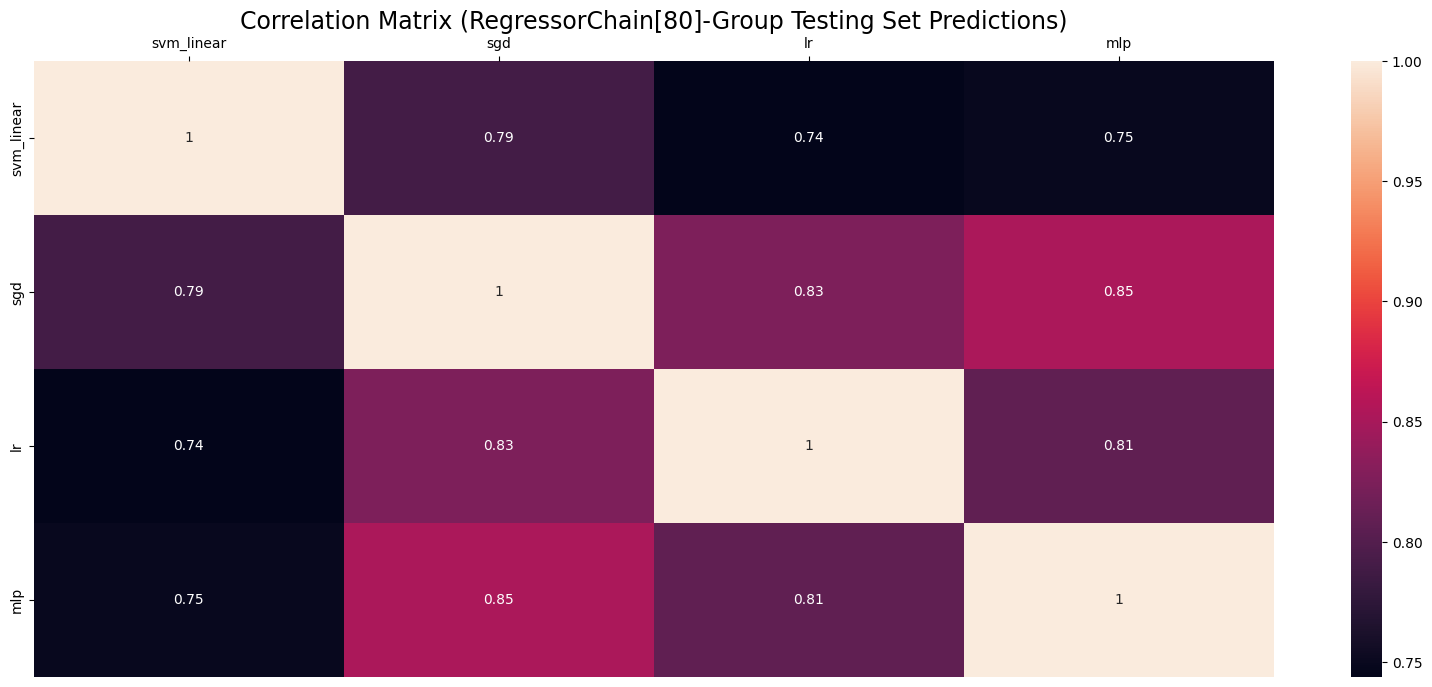

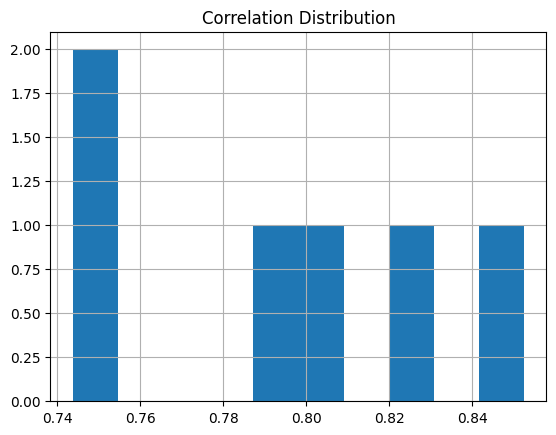

Testing correlation distribution:
count    6.000000
mean     0.794837
std      0.042717
min      0.743801
25%      0.759635
50%      0.798573
75%      0.821332
max      0.852498
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0030
NMSE: 0.0461
MAE: 0.7054
NMAE: 0.8586
aRRMSE: 0.8357
aCC: 0.9965


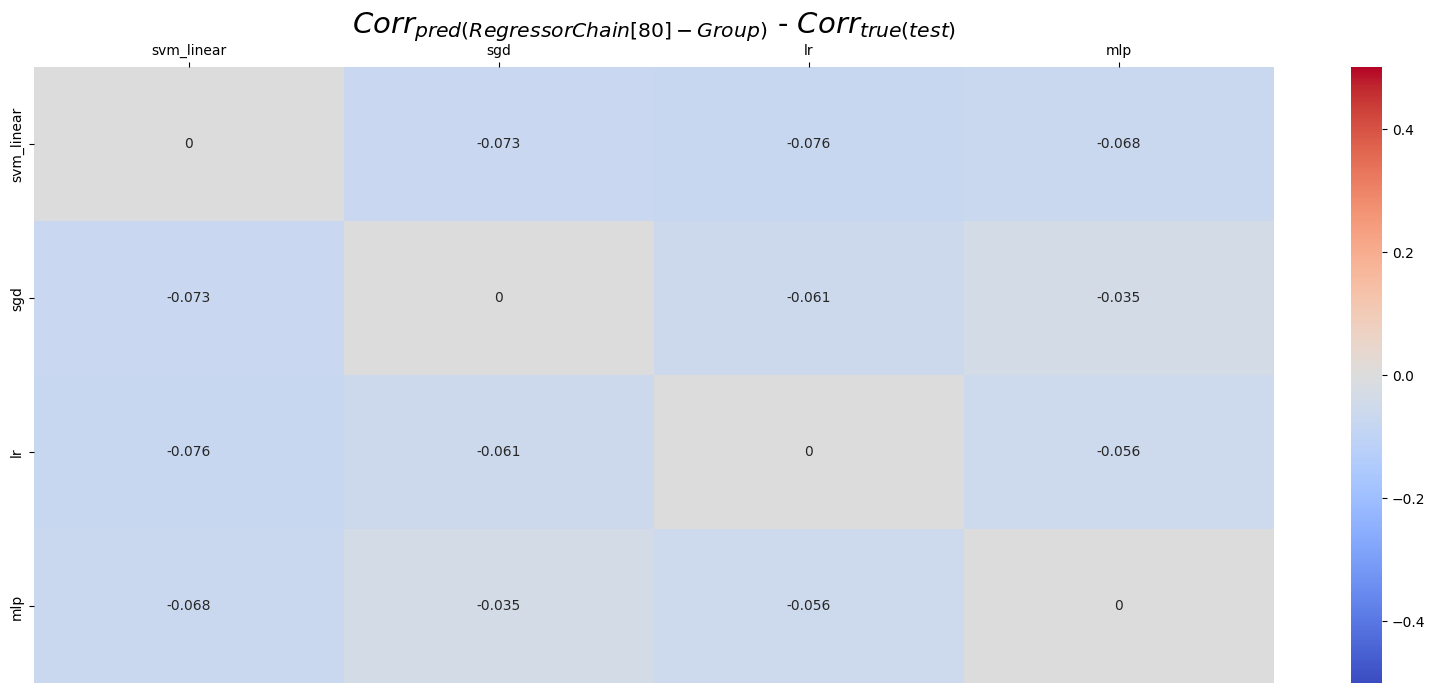

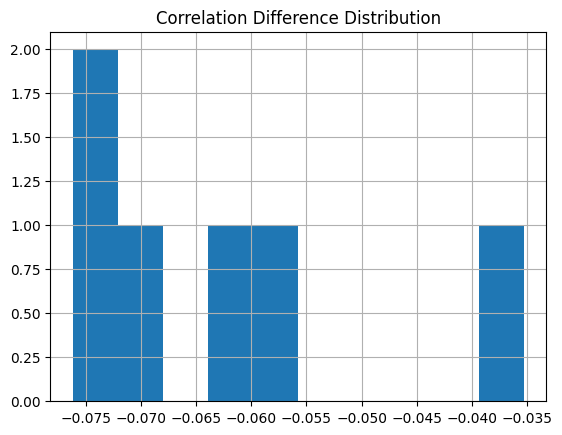

[['sgd'], ['svm_linear'], ['mlp'], ['lr']]


In [72]:
# keeping the concat because multiple numbers of chains could be recorded
#80chains
if(rcg_ac in metrics_df.index):
    metrics_df.loc[rcg_ac,:] = assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rcg_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])

results = correlation_pred_performance(rcg_plus, Xa_test, ya_test, min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]-Group")

diff_metrics.loc[rcg_ac,:] = results['results']

groups[f'rcg({num_chains})_assessor'] = results['groups']
print(groups[f'rcg({num_chains})_assessor']['test'])

[TRAINING SET]
MSE: 0.0071
NMSE: 0.1789
MAE: 0.0608
NMAE: 0.3714
aRRMSE: 0.4224
aCC: 0.9539

[TESTING SET]
MSE: 0.0272
NMSE: 0.7704
MAE: 0.1301
NMAE: 0.8455
aRRMSE: 0.8776
aCC: 0.4827


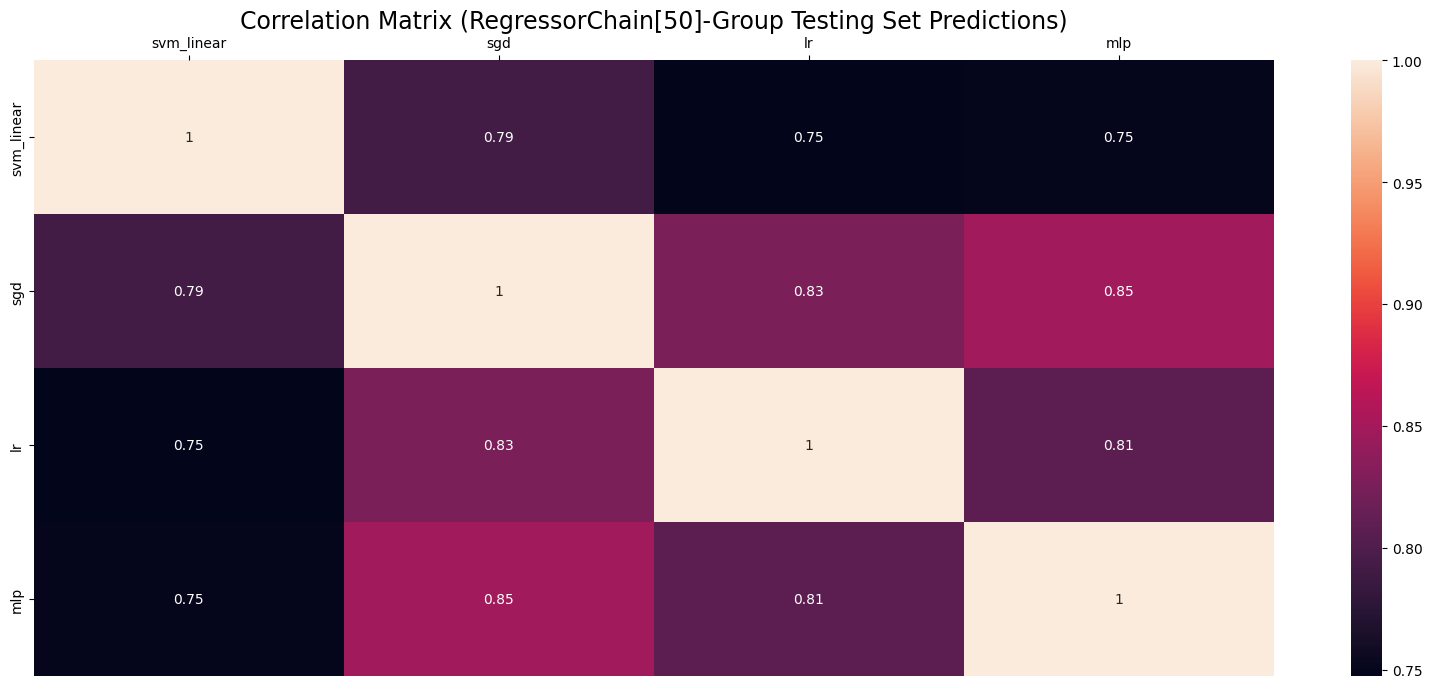

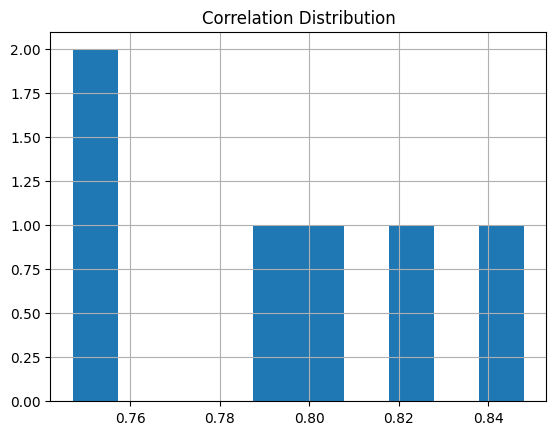

Testing correlation distribution:
count    6.000000
mean     0.795136
std      0.040798
min      0.747185
25%      0.760137
50%      0.799894
75%      0.821729
max      0.847951
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0029
NMSE: 0.0459
MAE: 0.6902
NMAE: 0.8556
aRRMSE: 0.8274
aCC: 0.9977


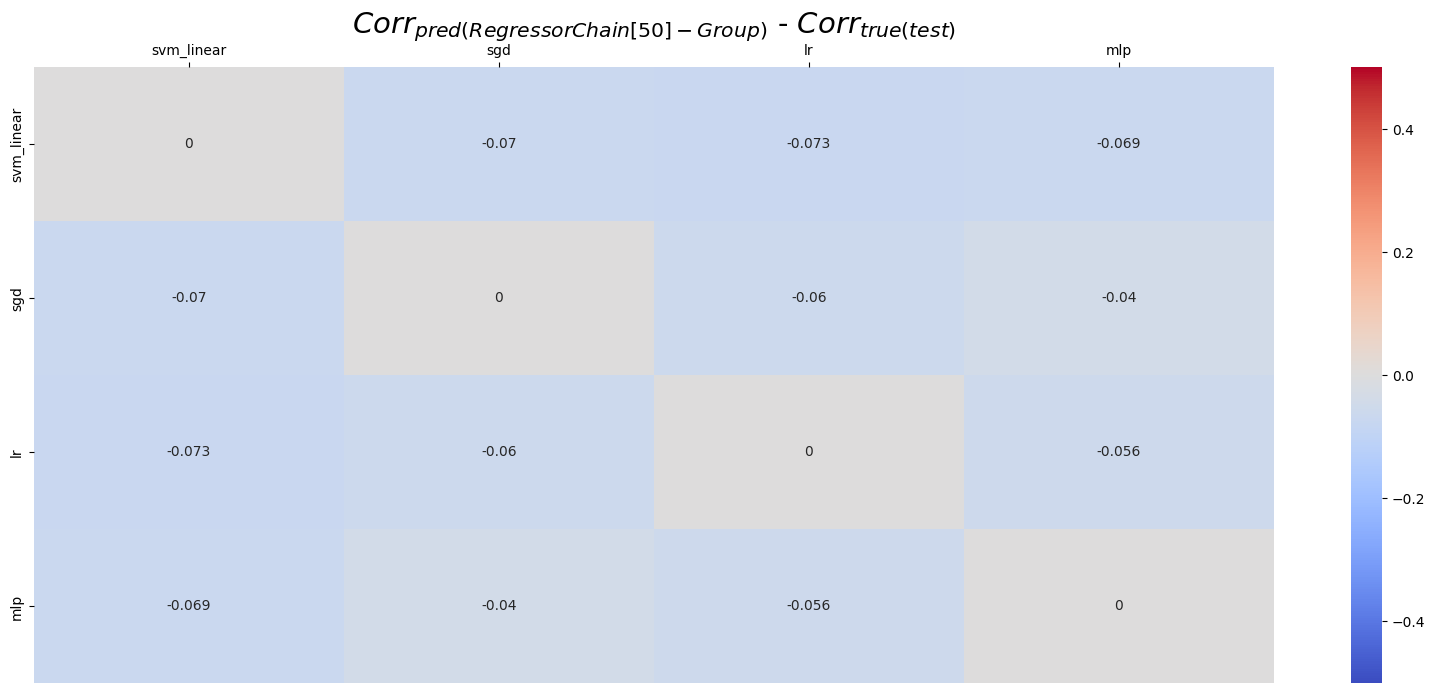

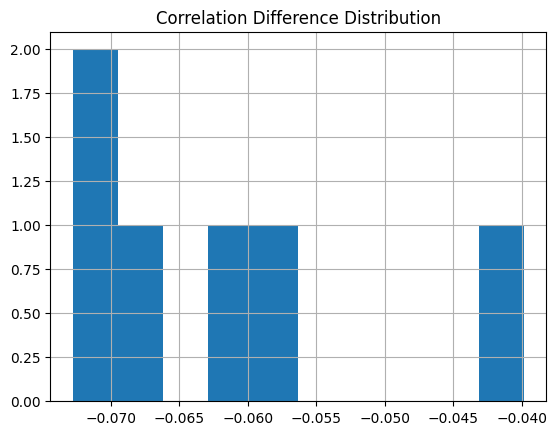

[['sgd'], ['svm_linear'], ['mlp'], ['lr']]


In [65]:
# keeping the concat because multiple numbers of chains could be recorded
#50chains
if(rcg_ac in metrics_df.index):
    metrics_df.loc[rcg_ac,:] = assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rcg_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])

results = correlation_pred_performance(rcg_plus, Xa_test, ya_test, min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]-Group")

diff_metrics.loc[rcg_ac,:] = results['results']

groups[f'rcg({num_chains})_assessor'] = results['groups']
print(groups[f'rcg({num_chains})_assessor']['test'])

[TRAINING SET]
MSE: 0.0071
NMSE: 0.1782
MAE: 0.0606
NMAE: 0.3709
aRRMSE: 0.4215
aCC: 0.9543

[TESTING SET]
MSE: 0.0271
NMSE: 0.7698
MAE: 0.1300
NMAE: 0.8450
aRRMSE: 0.8773
aCC: 0.4833


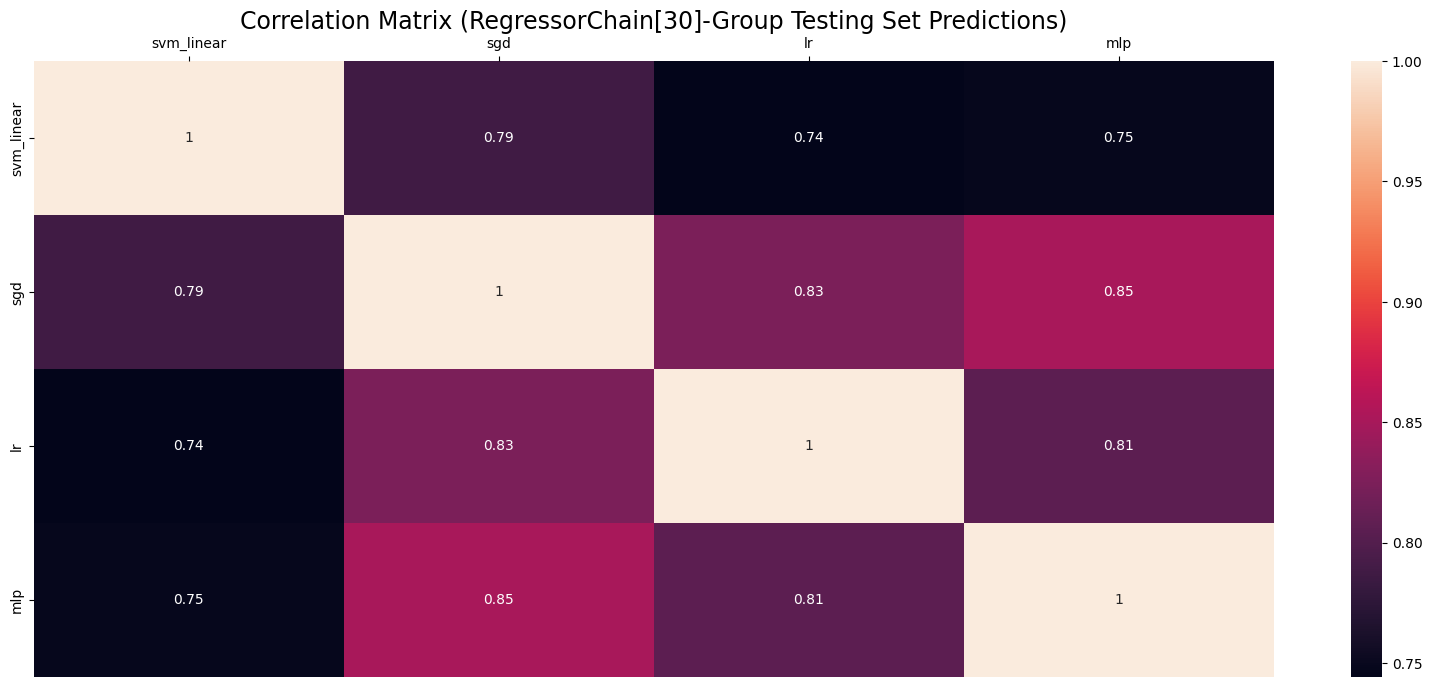

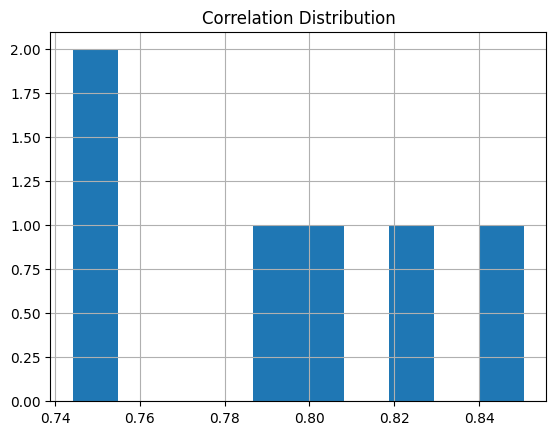

Testing correlation distribution:
count    6.000000
mean     0.793673
std      0.042273
min      0.744224
25%      0.758049
50%      0.797092
75%      0.820275
max      0.850595
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0031
NMSE: 0.0470
MAE: 0.7299
NMAE: 0.8753
aRRMSE: 0.8504
aCC: 0.9967


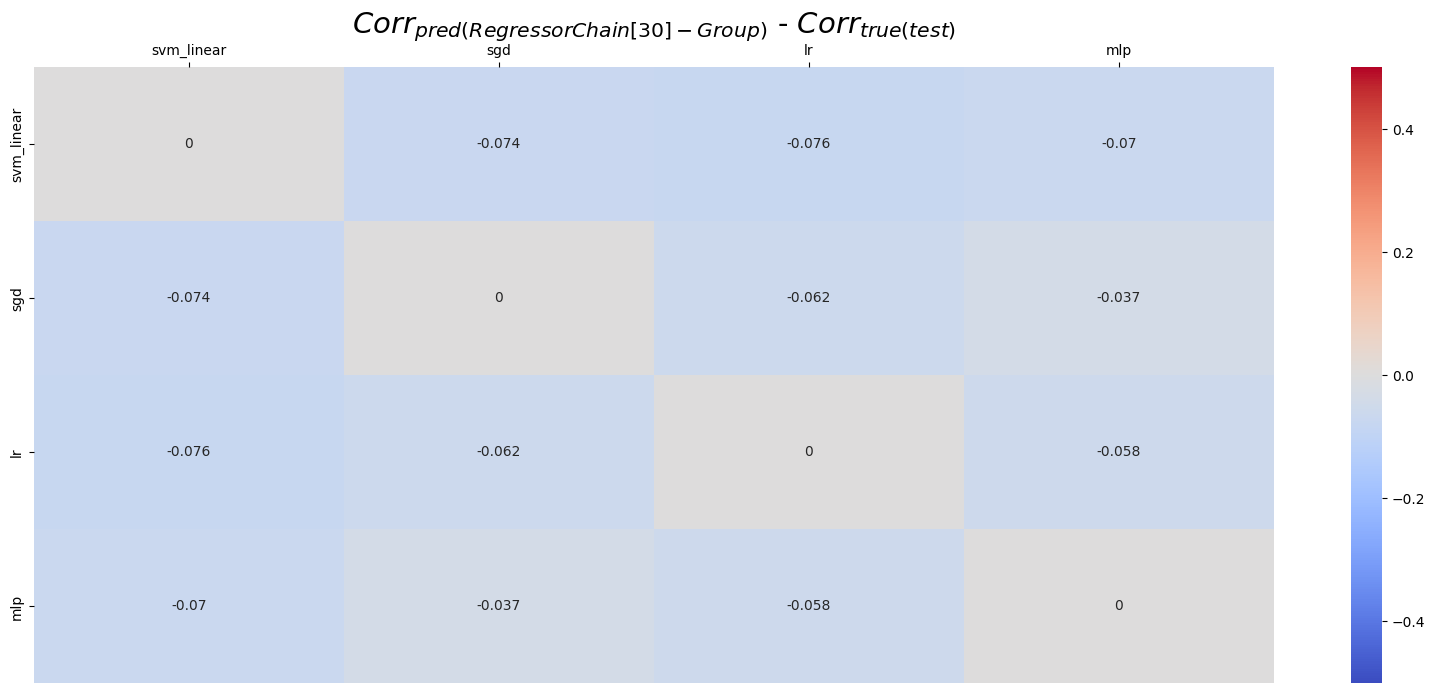

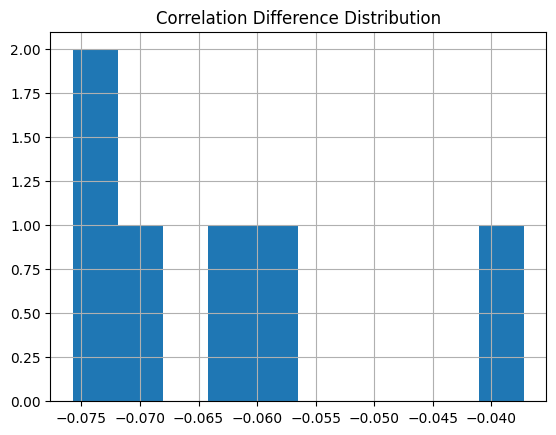

[['sgd'], ['svm_linear'], ['mlp'], ['lr']]


In [58]:
# keeping the concat because multiple numbers of chains could be recorded
#30chains
if(rcg_ac in metrics_df.index):
    metrics_df.loc[rcg_ac,:] = assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rcg_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])

results = correlation_pred_performance(rcg_plus, Xa_test, ya_test, min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]-Group")

diff_metrics.loc[rcg_ac,:] = results['results']

groups[f'rcg({num_chains})_assessor'] = results['groups']
print(groups[f'rcg({num_chains})_assessor']['test'])

[TRAINING SET]
MSE: 0.0074
NMSE: 0.1781
MAE: 0.0609
NMAE: 0.3687
aRRMSE: 0.4201
aCC: 0.9514

[TESTING SET]
MSE: 0.0273
NMSE: 0.7734
MAE: 0.1302
NMAE: 0.8456
aRRMSE: 0.8793
aCC: 0.4795


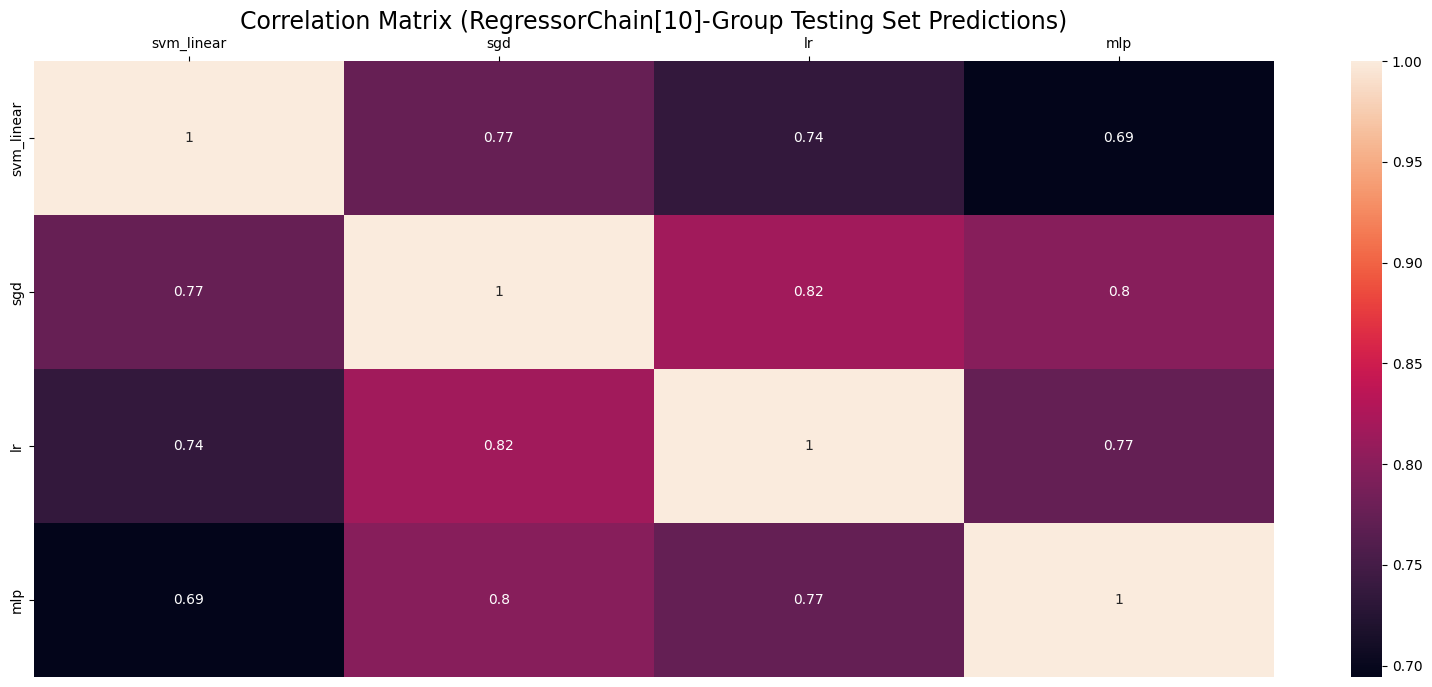

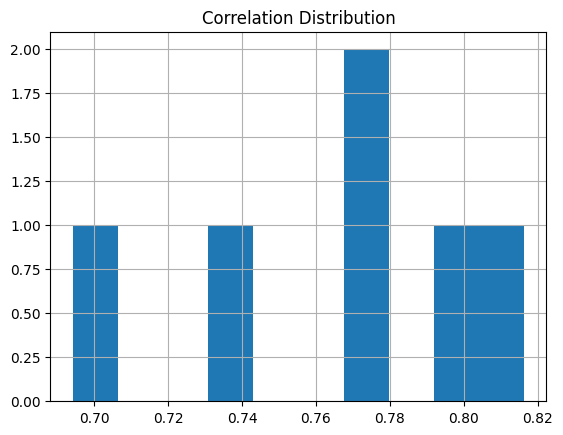

Testing correlation distribution:
count    6.000000
mean     0.765389
std      0.044261
min      0.694317
25%      0.744779
50%      0.773989
75%      0.792572
max      0.816231
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0064
NMSE: 0.0682
MAE: 1.5142
NMAE: 1.2732
aRRMSE: 1.2255
aCC: 0.9955


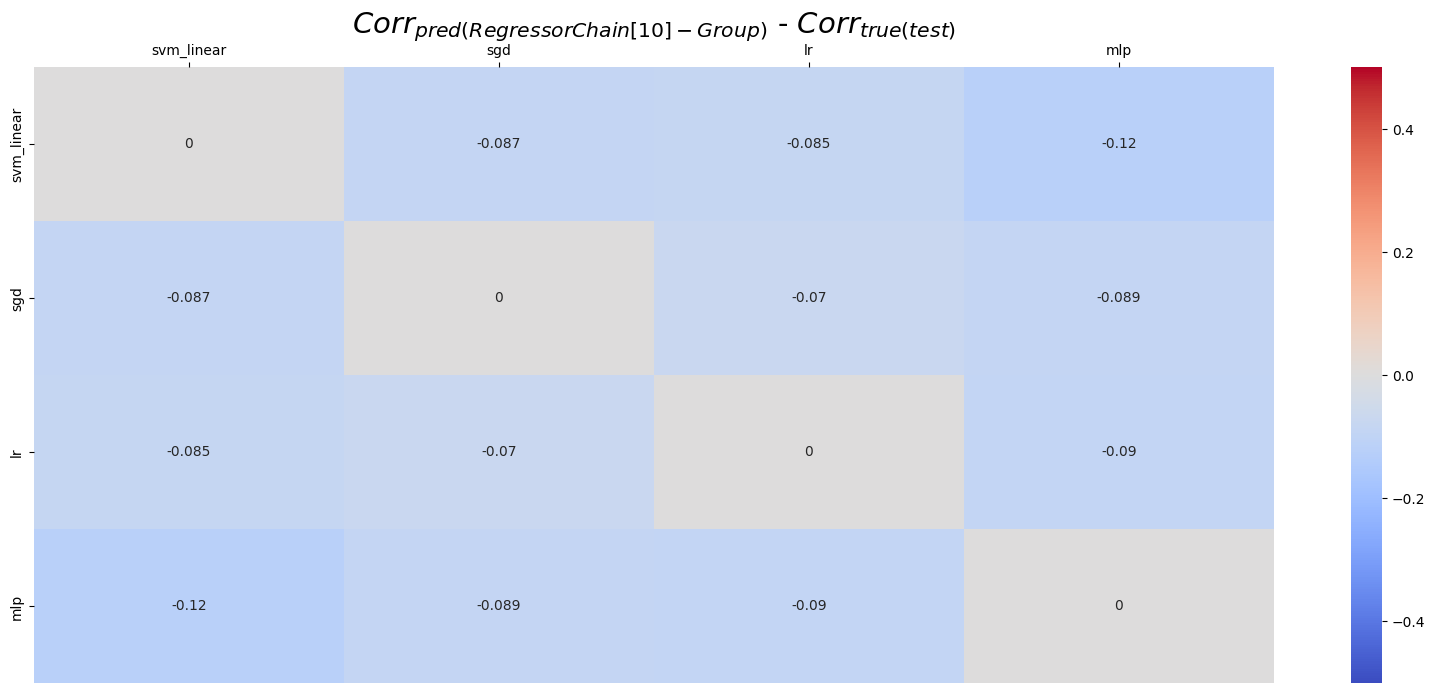

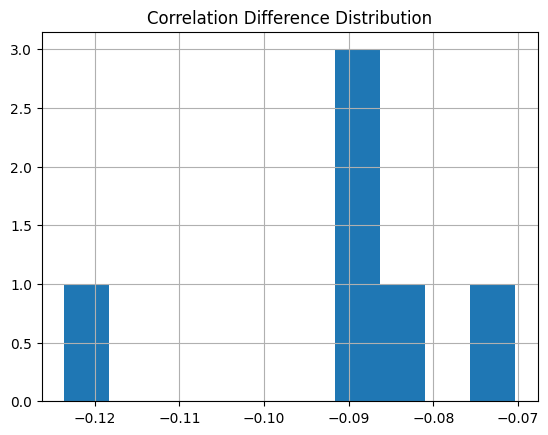

[['sgd'], ['svm_linear'], ['mlp'], ['lr']]


In [50]:
# keeping the concat because multiple numbers of chains could be recorded
#10chains
if(rcg_ac in metrics_df.index):
    metrics_df.loc[rcg_ac,:] = assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train)
else:
    new_df = pd.DataFrame(assr_performance(rcg_plus, Xa_test, ya_test, Xa_train, ya_train), 
                          columns=metrics_cols,
                          index=multIdx(rcg_ac, subindex=model_names))

    metrics_df = pd.concat([metrics_df, new_df])

results = correlation_pred_performance(rcg_plus, Xa_test, ya_test, min_score=MIN_SCORE, name=f"RegressorChain[{num_chains}]-Group")

diff_metrics.loc[rcg_ac,:] = results['results']

groups[f'rcg({num_chains})_assessor'] = results['groups']
print(groups[f'rcg({num_chains})_assessor']['test'])

### Multi-Output SVR

In [ ]:
msvrg = GroupedAssessor([MSVR() for _ in range(len(groups['true_assessor_train']))])

msvrg.fit(Xa_train_norm, ya_train, groups['true_assessor_train'])

c:\Users\pedro\Documents\NOVOdeltadelta\pog\meu\proj-mtr\MSVR.py:74: RuntimeWarning: divide by zero encountered in divide
  a = 2 * C * (u - epsi) / u
c:\Users\pedro\Documents\NOVOdeltadelta\pog\meu\proj-mtr\MSVR.py:74: RuntimeWarning: divide by zero encountered in divide
  a = 2 * C * (u - epsi) / u


[TRAINING SET]
MSE: 0.0306
NMSE: 0.7385
MAE: 0.1337
NMAE: 0.8459
aRRMSE: 0.8443
aCC: 0.6644

[TESTING SET]
MSE: 0.0492
NMSE: 1.5985
MAE: 0.1622
NMAE: 1.0933
aRRMSE: 1.2016
aCC: 0.3004


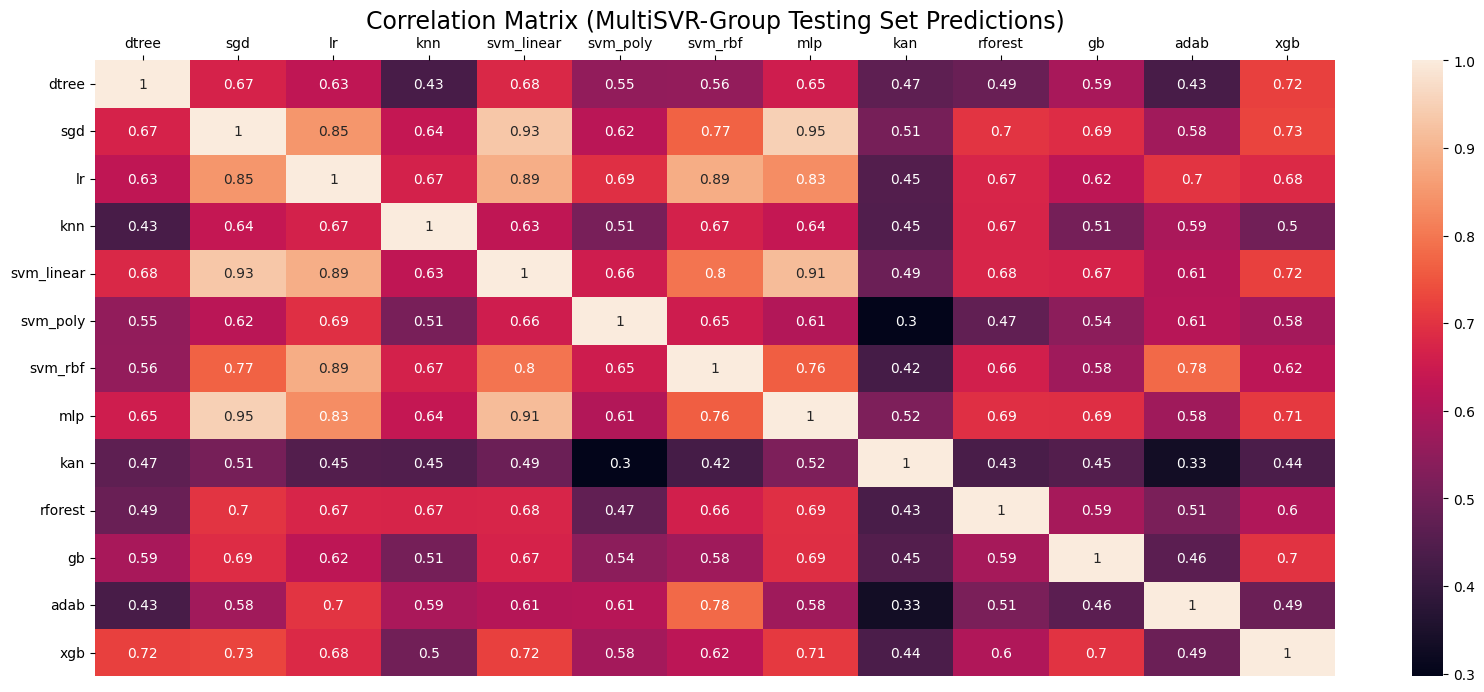

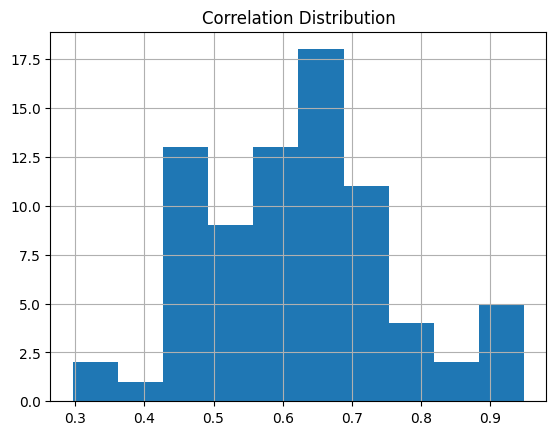

Testing correlation distribution:
count    78.000000
mean      0.620602
std       0.135604
min       0.296749
25%       0.511975
50%       0.625905
75%       0.692413
max       0.948929
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0275
NMSE: 0.1392
MAE: 0.8266
NMAE: 1.1551
aRRMSE: 0.8899
aCC: 0.8894


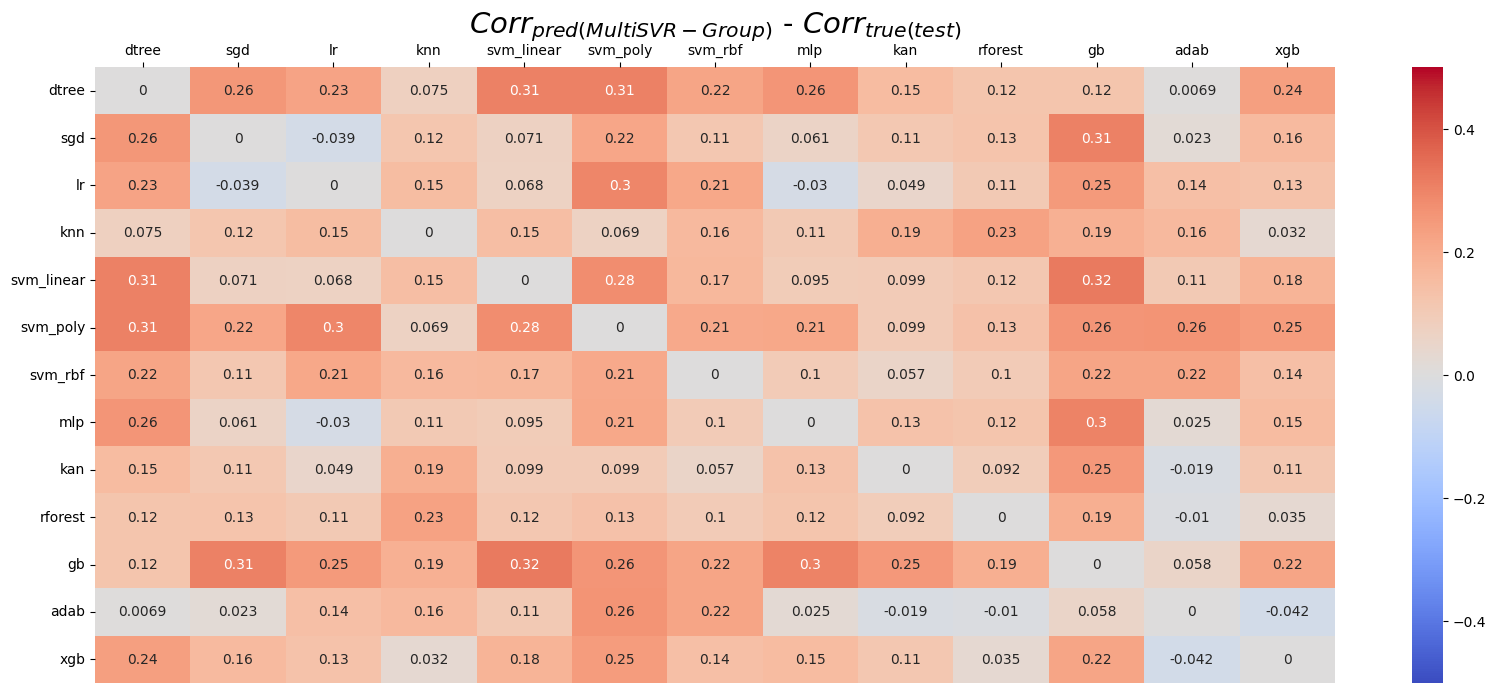

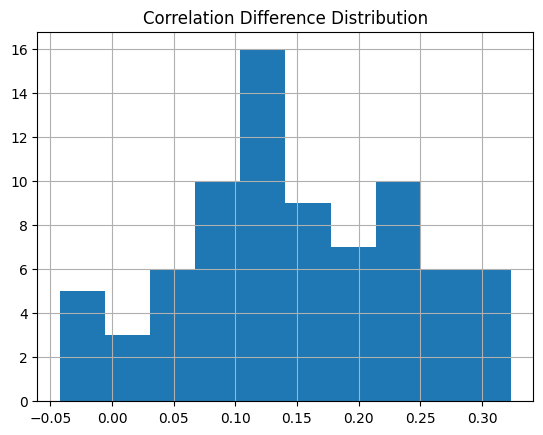

[['kan'], ['mlp', 'svm_linear', 'sgd', 'dtree', 'xgb'], ['mlp', 'svm_linear', 'sgd', 'gb', 'xgb'], ['rforest', 'mlp', 'svm_linear', 'sgd', 'svm_rbf', 'lr'], ['mlp', 'svm_linear', 'sgd', 'lr', 'xgb'], ['svm_linear', 'svm_rbf', 'lr', 'svm_poly'], ['svm_rbf', 'adab', 'lr'], ['svm_rbf', 'rforest', 'lr', 'knn']]


In [48]:
metrics_df.loc['M-SVR(g)',:] = assr_performance(msvrg, Xa_test_norm, ya_test, Xa_train_norm, ya_train)

results = correlation_pred_performance(msvrg, pd.DataFrame(Xa_test_norm, index=Xa_test.index), 
                                       ya_test, min_score=MIN_SCORE, name="MultiSVR-Group")

diff_metrics.loc['M-SVR(g)',:] = results['results']

groups['msvrg_assessor'] = results['groups']
print(groups['msvrg_assessor']['test'])

### Multi-Target Random Forest Regressor

In [ ]:
mrfg = GroupedAssessor([RandomForestRegressor(random_state=seed) for _ in range(len(groups['true_assessor_train']))])

mrfg.fit(Xa_train, ya_train, groups['true_assessor_train'])

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

[TRAINING SET]
MSE: 0.0062
NMSE: 0.1271
MAE: 0.0580
NMAE: 0.3373
aRRMSE: 0.3563
aCC: 0.9771

[TESTING SET]
MSE: 0.0391
NMSE: 0.8378
MAE: 0.1485
NMAE: 0.8852
aRRMSE: 0.9141
aCC: 0.4110


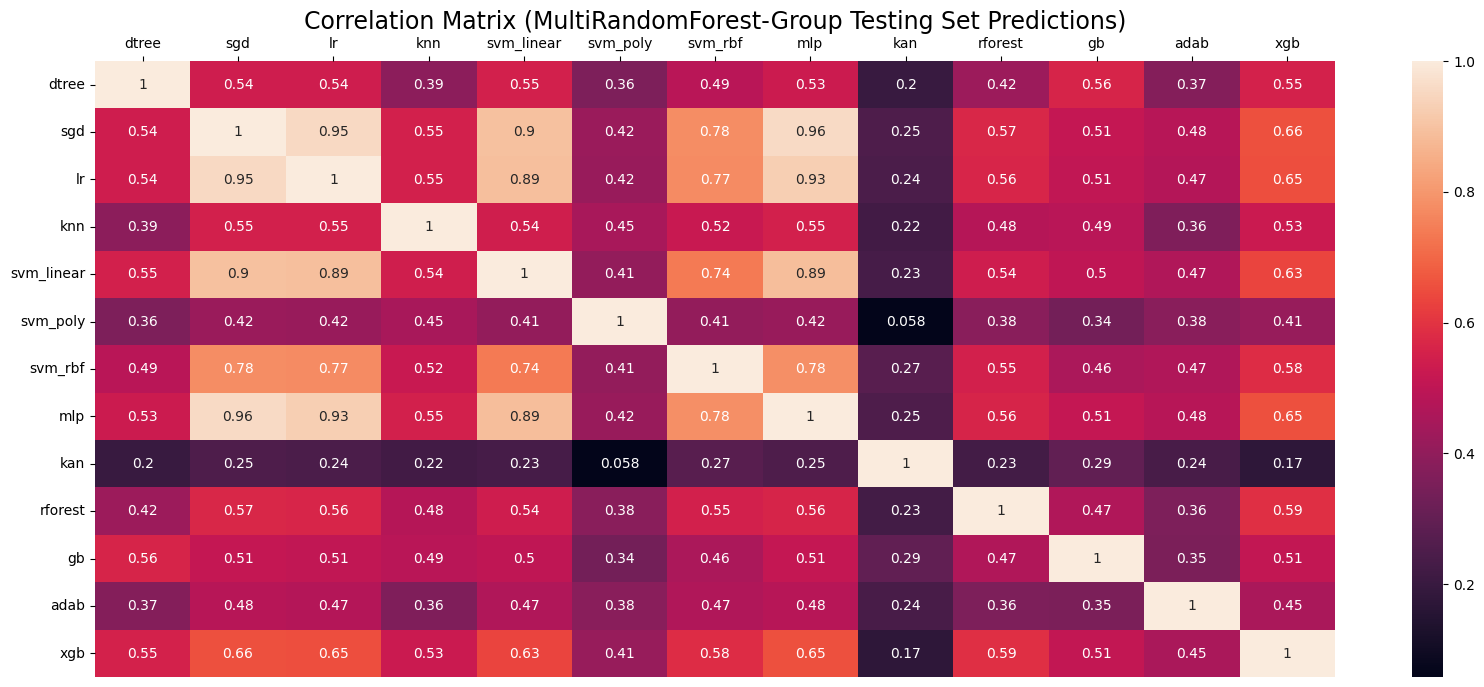

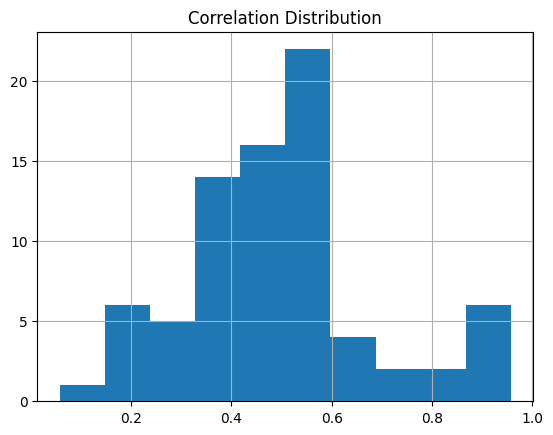

Testing correlation distribution:
count    78.000000
mean      0.496184
std       0.186537
min       0.058102
25%       0.385847
50%       0.487535
75%       0.558155
max       0.957177
Name: corr, dtype: float64

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.0078
NMSE: 0.0731
MAE: 0.2348
NMAE: 0.6036
aRRMSE: 0.4753
aCC: 0.9337


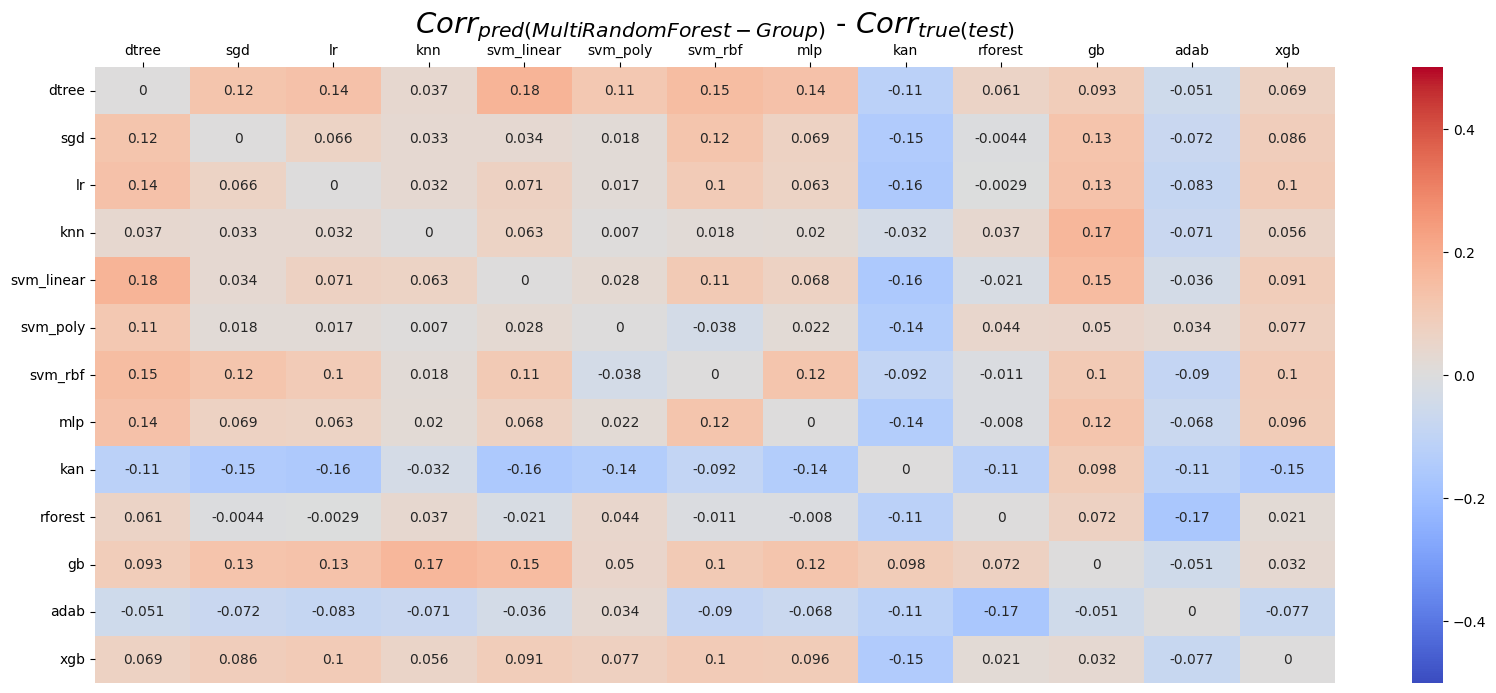

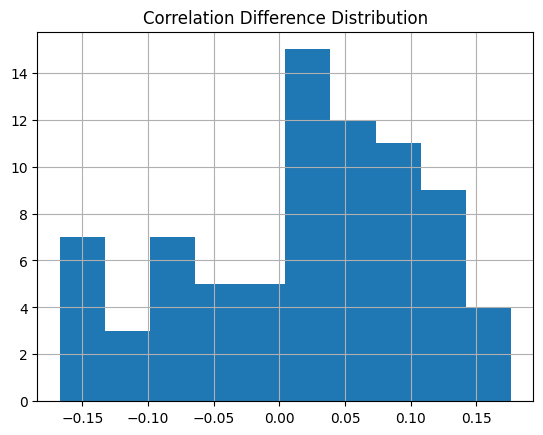

[['kan'], ['rforest'], ['mlp', 'sgd', 'svm_linear', 'svm_rbf', 'lr'], ['mlp', 'sgd', 'lr', 'xgb'], ['svm_poly'], ['knn'], ['adab'], ['dtree'], ['gb']]


In [50]:
metrics_df.loc['MRT(g)',:] = assr_performance(mrfg, Xa_test, ya_test, Xa_train, ya_train)

results = correlation_pred_performance(mrfg, Xa_test, ya_test, min_score=MIN_SCORE, name="MultiRandomForest-Group")

diff_metrics.loc['MRT(g)',:] = results['results']

groups['mrfg_assessor'] = results['groups']
print(groups['mrfg_assessor']['test'])

In [51]:
#keys = list(groups.keys())
#OBJV = len(groups['true_assessor_test'])
#for i in range(len(keys)):
#    if('test' in keys[i] and keys[i] != 'true_assessor_test'):
#        print(f'{keys[i]}({len(groups[keys[i]])}) & true_assessor_test({OBJV}):')
#        count = 0
#        for g in groups[keys[i]]:
#            if(g in groups['true_assessor_test']):
#                print(g)
#                count += 1
#        print(f'Número de grupos em comum: {count}\n\n')

## Análises

In [73]:
results_df = metrics_df.dropna().copy()
results_df = results_df.reset_index()

results_df

Assessor       Model       MSE       MAE      NMSE      NMAE    aRRMSE  \
0          ST  svm_linear  0.025841  0.795178  0.129468  0.860798  0.891728   
1          ST         sgd  0.035386  0.783062  0.153543  0.852673  0.884908   
2          ST          lr  0.010085  0.752891  0.079016  0.832893  0.867693   
3          ST         mlp  0.037679  0.773597  0.159436  0.844102  0.879543   
4          RC  svm_linear  0.025841  0.795178  0.129468  0.860798  0.891728   
5          RC         sgd  0.036127  0.799481  0.154211  0.856382  0.894137   
6          RC          lr  0.010084  0.752805  0.079586    0.8389  0.867643   
7          RC         mlp  0.037552  0.770991  0.161549  0.855287  0.878061   
8       RC(g)  svm_linear  0.026846  0.826114  0.133332  0.886488  0.908908   
9       RC(g)         sgd  0.035386  0.783062  0.153543  0.852673  0.884908   
10      RC(g)          lr   0.00982  0.733126   0.07887  0.831358  0.856228   
11      RC(g)         mlp   0.03946  0.810163  0.165393  0.875637  0.900091   
12     RC[10]  svm_linear  0.025672  0.789987  0.128097  0.851683  0.888812   
13     RC[10]         sgd  0.035348  0.782237  0.152429  0.846484  0.884442   
14     RC[10]          lr  0.009819  0.733076  0.078673  0.829272  0.856199   
15     RC[10]         mlp  0.038174  0.783751  0.160811  0.851382  0.885297   
16  RC[10](g)  svm_linear  0.025734  0.791904  0.129191  0.858958   0.88989   
17  RC[10](g)         sgd  0.035087  0.776449  0.152046  0.844359  0.881163   
18  RC[10](g)          lr  0.009811  0.732411  0.078436  0.826778   0.85581   
19  RC[10](g)         mlp  0.038609  0.792676   0.16096  0.852172  0.890324   
20     RC[30]  svm_linear  0.025622  0.788442  0.128688   0.85561  0.887943   
21     RC[30]         sgd  0.035101  0.776776  0.152238  0.845425  0.881349   
22     RC[30]          lr  0.009776  0.729863  0.078568  0.828173   0.85432   
23     RC[30]         mlp   0.03801  0.780394  0.160838  0.851521  0.883399   
24  RC[30](g)  svm_linear  0.025758  0.792638  0.129348  0.859997  0.890302   
25  RC[30](g)         sgd  0.035041  0.775443  0.152137  0.844865  0.880593   
26  RC[30](g)          lr  0.009808  0.732245  0.078412  0.826526  0.855713   
27  RC[30](g)         mlp  0.037941  0.778969  0.160287  0.848608  0.882592   
28     RC[50]  svm_linear  0.025663   0.78971  0.128752  0.856039  0.888656   
29     RC[50]         sgd  0.035116  0.777088  0.152177  0.845089  0.881526   
30     RC[50]          lr  0.009789  0.730799  0.078565  0.828142  0.854868   
31     RC[50]         mlp  0.038019  0.780569  0.160635  0.850448  0.883498   
32  RC[50](g)  svm_linear   0.02579  0.793608  0.129562  0.861422  0.890847   
33  RC[50](g)         sgd  0.035033  0.775255  0.152172  0.845059  0.880486   
34  RC[50](g)          lr  0.009812  0.732527  0.078405  0.826455  0.855878   
35  RC[50](g)         mlp  0.037998  0.780135  0.160393   0.84917  0.883253   
36     RC[80]  svm_linear  0.025759  0.792651  0.129056  0.858056   0.89031   
37     RC[80]         sgd  0.035161  0.778096   0.15217  0.845048  0.882098   
38     RC[80]          lr  0.009773  0.729635  0.078485  0.827299  0.854187   
39     RC[80]         mlp  0.037965  0.779453   0.16042  0.849313  0.882866   
40  RC[80](g)  svm_linear  0.025756  0.792577  0.129338  0.859932  0.890268   
41  RC[80](g)         sgd  0.035006  0.774663  0.152065  0.844466   0.88015   
42  RC[80](g)          lr  0.009806  0.732098  0.078404  0.826446  0.855628   
43  RC[80](g)         mlp  0.037973  0.779632  0.160238  0.848349  0.882967   

         aCC  
0   0.452745  
1   0.468603  
2   0.505364  
3   0.478187  
4   0.452745  
5   0.448223  
6   0.506123  
7   0.482701  
8    0.42301  
9   0.468603  
10   0.52129  
11  0.437461  
12  0.458433  
13  0.467597  
14  0.528916  
15  0.467519  
16  0.456444  
17  0.474369  
18    0.5295  
19  0.457854  
20  0.460395  
21  0.474554  
22  0.533042  
23  0.472268  
24  0.455577  
25  0.476266  
26  0.528477  
27  0.472902  
28  0.458843  

In [76]:
diff_results = diff_metrics.dropna().reset_index(names=['Assessor'])
diff_results.to_csv(f'data/{DIR}/results_diff_RC.csv')
diff_results

Assessor       MSE       MAE      NMSE      NMAE    aRRMSE       aCC
0          ST  0.007976  0.076358  1.943884  1.433795  1.380917  0.987066
1          RC  0.008514  0.079081  2.123859  1.490022  1.434651  0.986198
2       RC(g)  0.014323  0.101616   3.64663  1.929008  1.870732  0.958348
3      RC[10]  0.001373  0.030244  0.345135   0.57552  0.575584  0.983873
4   RC[10](g)  0.006398  0.068216  1.514216  1.273202  1.225469   0.99552
5      RC[30]  0.000795  0.023424  0.190811  0.438514  0.434431  0.994052
6   RC[30](g)  0.003074  0.047003  0.729932  0.875308  0.850374  0.996662
7      RC[50]  0.000617  0.020001  0.148173   0.37559  0.379869   0.99196
8   RC[50](g)  0.002902  0.045906  0.690197  0.855639  0.827388   0.99766
9      RC[80]  0.000596  0.019763  0.144451  0.370874   0.37567  0.992568
10  RC[80](g)  0.002975  0.046131  0.705441  0.858644   0.83573  0.996488

In [77]:
win_table = pd.DataFrame(index=results_df['Assessor'].unique(), columns=results_df.drop(columns=['Assessor', 'Model']).columns)

for mt in ['MSE', 'MAE', 'NMSE', 'NMAE', 'aRRMSE']:
    assr_wins = results_df.loc[results_df.groupby("Model")[mt].idxmin(), ["Model", "Assessor", mt]]
    win_table[mt] = assr_wins['Assessor'].value_counts()

assr_wins = results_df.loc[results_df.groupby("Model")['aCC'].idxmin(), ["Model", "Assessor", 'aCC']]
win_table['aCC'] = assr_wins['Assessor'].value_counts()

win_table = win_table.fillna(0)
win_table.to_csv(f'data/{DIR}/win_table_RC.csv')
win_table

MSE  MAE  NMSE  NMAE  aRRMSE  aCC
ST         0.0  0.0   1.0   1.0     0.0  1.0
RC         1.0  1.0   0.0   0.0     1.0  1.0
RC(g)      0.0  0.0   0.0   0.0     0.0  2.0
RC[10]     0.0  0.0   1.0   1.0     0.0  0.0
RC[10](g)  0.0  0.0   1.0   1.0     0.0  0.0
RC[30]     1.0  1.0   0.0   0.0     1.0  0.0
RC[30](g)  0.0  0.0   0.0   0.0     0.0  0.0
RC[50]     0.0  0.0   0.0   0.0     0.0  0.0
RC[50](g)  0.0  0.0   0.0   0.0     0.0  0.0
RC[80]     1.0  1.0   0.0   0.0     1.0  0.0
RC[80](g)  1.0  1.0   1.0   1.0     1.0  0.0

In [78]:
summary = results_df.drop(columns=['Model']).groupby(['Assessor']).agg(['mean', 'std'])
summary.to_csv(f'data/{DIR}/results_RC.csv')
summary

MSE                 MAE                NMSE            \
               mean       std      mean       std      mean       std   
Assessor                                                                
RC         0.027401  0.012669  0.779614  0.021833  0.131203  0.037047   
RC(g)      0.027878  0.013136  0.788116  0.040741  0.132785  0.038302   
RC[10]     0.027253  0.012796  0.772263  0.026339  0.130002  0.036926   
RC[10](g)   0.02731  0.012869   0.77336  0.028304  0.130158  0.036986   
RC[30]     0.027128  0.012719  0.768869  0.026457  0.130083  0.036934   
RC[30](g)  0.027137  0.012667  0.769824  0.026127  0.130046  0.036829   
RC[50]     0.027147  0.012717  0.769541  0.026371  0.130032  0.036866   
RC[50](g)  0.027158  0.012679  0.770381  0.026403  0.130133  0.036867   
RC[80]     0.027164  0.012715  0.769959  0.027672  0.130033  0.036840   
RC[80](g)  0.027135  0.012670  0.769742  0.026207  0.130012  0.036805   
ST         0.027248  0.012538  0.776182  0.017864  0.130366  0.036605   

               NMAE              aRRMSE                 aCC            
               mean       std      mean       std      mean       std  
Assessor                                                               
RC         0.852842  0.009595  0.882892  0.012388  0.472448  0.027167  
RC(g)      0.861539  0.024568  0.887534  0.023105  0.462591  0.043512  
RC[10]     0.844705  0.010561  0.878687  0.015111  0.480616  0.032486  
RC[10](g)  0.845567  0.013873  0.879297  0.016216  0.479542  0.034285  
RC[30]     0.845182  0.012087  0.876753  0.015207  0.485065  0.032582  
RC[30](g)  0.844999  0.013896    0.8773  0.014988  0.483306  0.031449  
RC[50]     0.844929  0.012051  0.877137  0.015148  0.484228  0.032634  
RC[50](g)  0.845526  0.014490  0.877616  0.015139  0.482665  0.031769  
RC[80]     0.844929  0.012941  0.877365  0.015890  0.483801  0.034308  
RC[80](g)  0.844798  0.013887  0.877253  0.015034   0.48342  0.031604  
ST         0.847617  0.011951  0.880968  0.010158  0.476225  0.022078

In [72]:
results_df_c = results_df.copy()

In [ ]:
class_palette = sns.color_palette()[:7]

In [85]:
from torch import relu
from torch import Tensor

class_palette = [sns.color_palette('bright')[-3],
                 sns.color_palette('bright')[3], relu(Tensor(sns.color_palette()[3])-Tensor([0.2]*3)).tolist(),
                 sns.color_palette('bright')[2], relu(Tensor(sns.color_palette()[2])-Tensor([0.15]*3)).tolist(),
                 sns.color_palette('bright')[0], relu(Tensor(sns.color_palette()[0])-Tensor([0.15]*3)).tolist(),
                 sns.color_palette('bright')[8], relu(Tensor(sns.color_palette()[8])-Tensor([0.15]*3)).tolist(),
                 sns.color_palette('bright')[4], relu(Tensor(sns.color_palette()[4])-Tensor([0.15]*3)).tolist(),
                 
                 ]

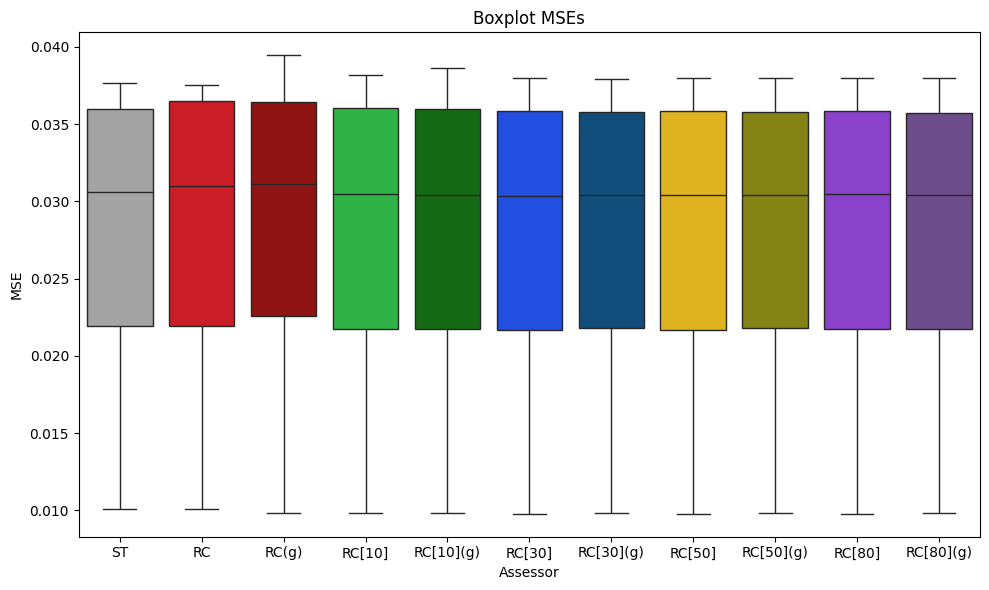

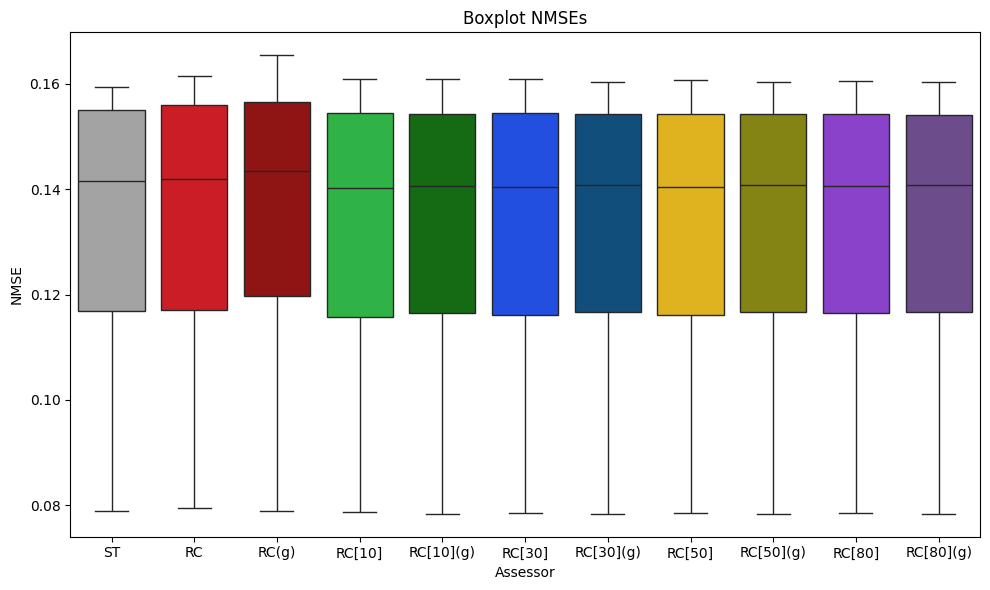

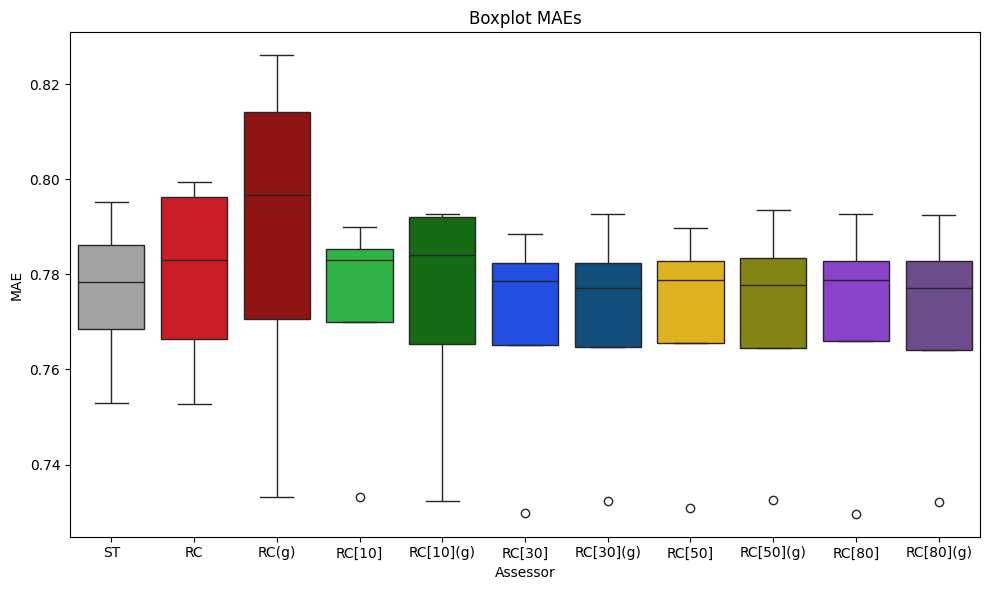

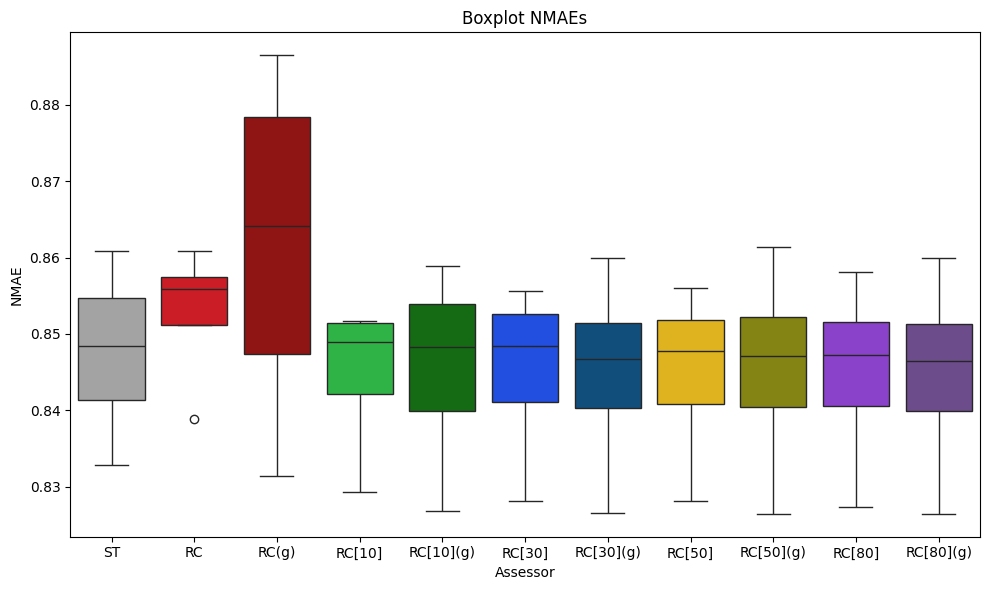

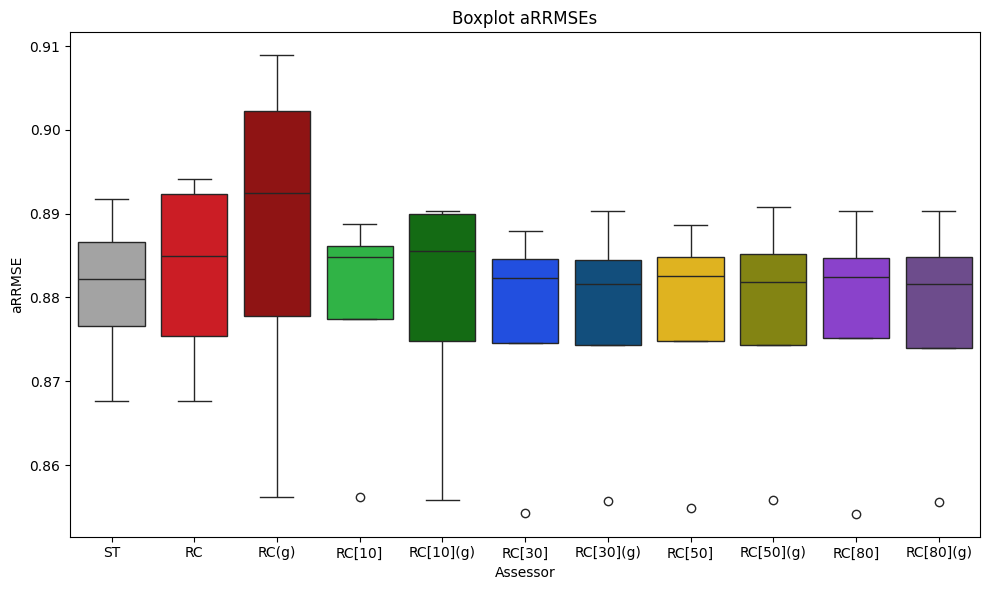

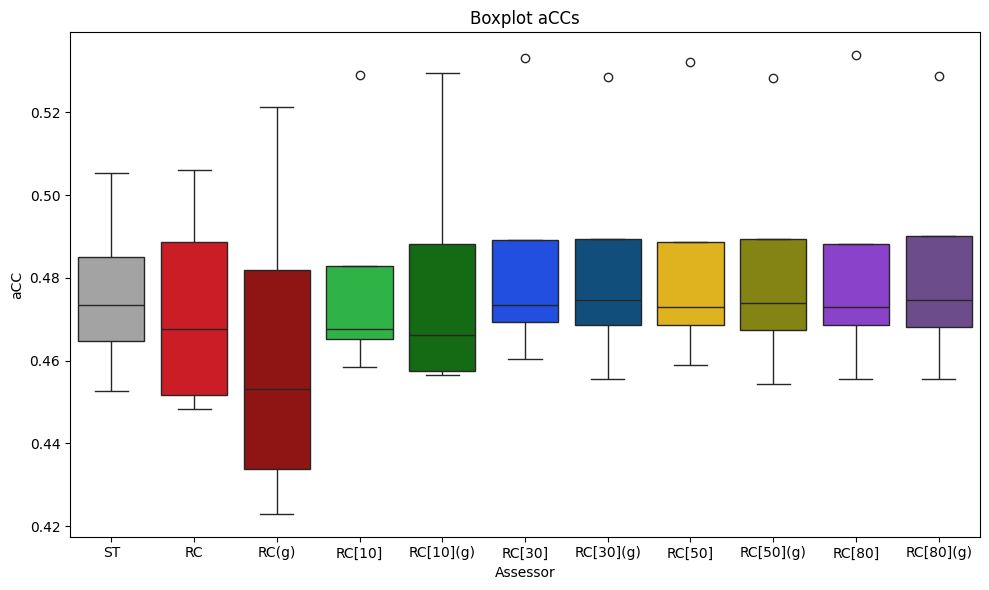

In [88]:
#temp = results_df.drop(index=results_df[results_df['Assessor'].str.contains('M-SVR')].index) #.copy()

for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    plt.figure(figsize=(10,6))
    plt.title(f'Boxplot {mt}s')
    temp = results_df.loc[:,['Assessor','Model',mt]].copy()
    if((temp[mt] > 1.2).any()):
        dicio = {}
        for a in temp['Assessor'].unique():
            out_limits = (temp.loc[temp["Assessor"]==a,mt]>1.2).sum()
            if(out_limits > 0):
                dicio[a] = a + "*"*out_limits
        temp = temp.replace(dicio)
        plt.ylim(bottom=temp[mt].min()-0.017,top=temp.loc[temp[mt]<1.2,mt].max()+0.017)
    imgplt = sns.boxplot(temp, y=mt, x='Assessor', hue='Assessor', palette=class_palette)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bp_{mt.lower()}_RC.eps', format='eps', dpi=300)

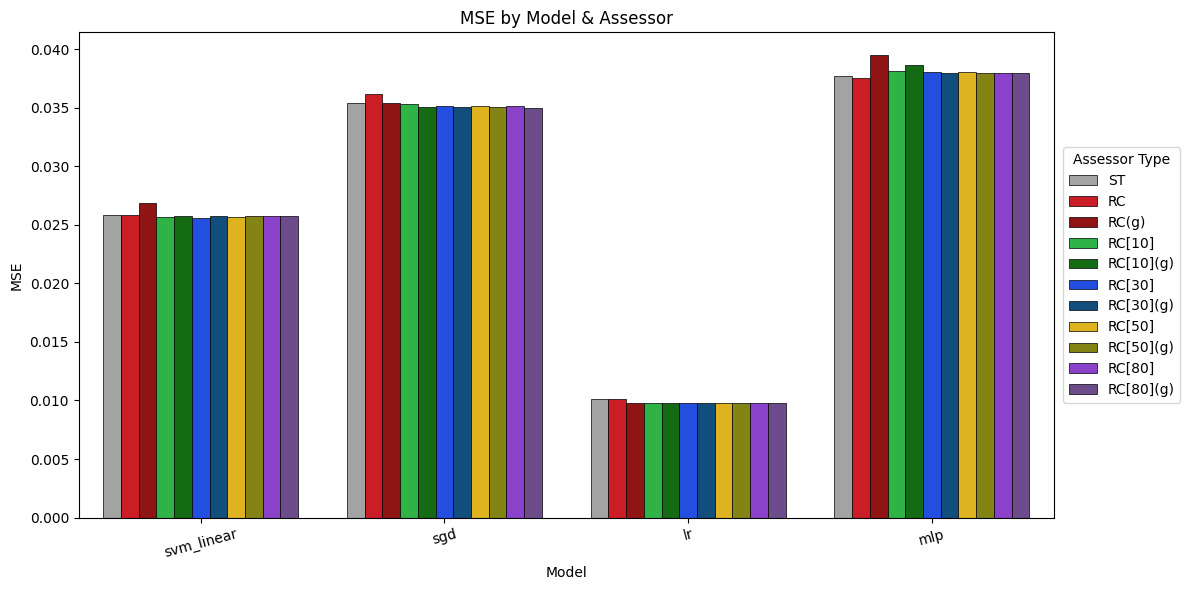

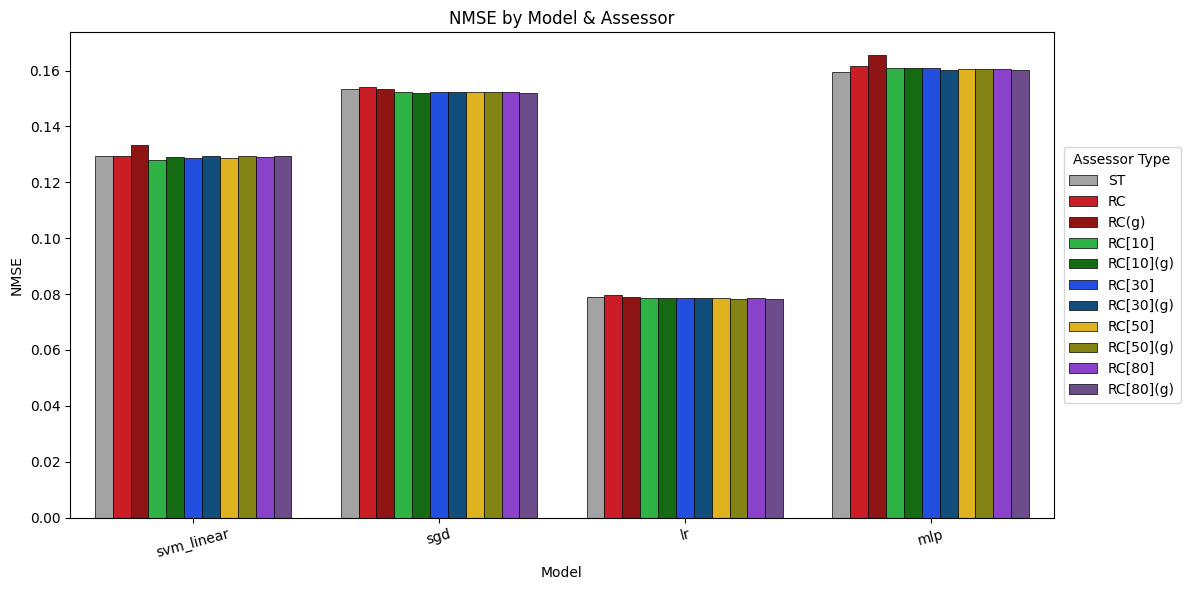

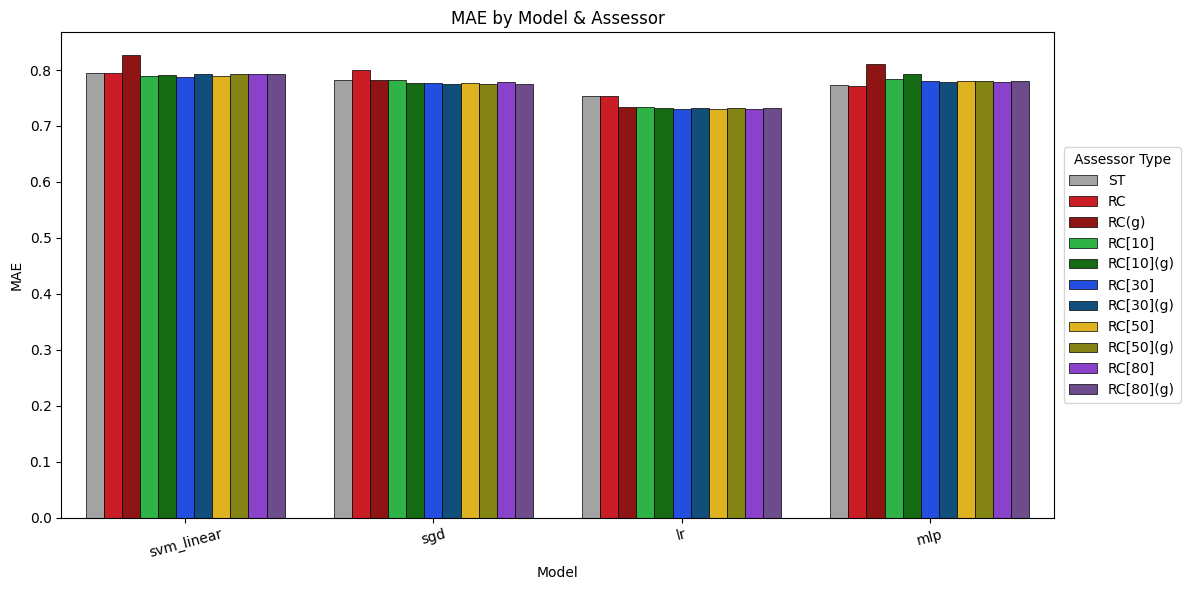

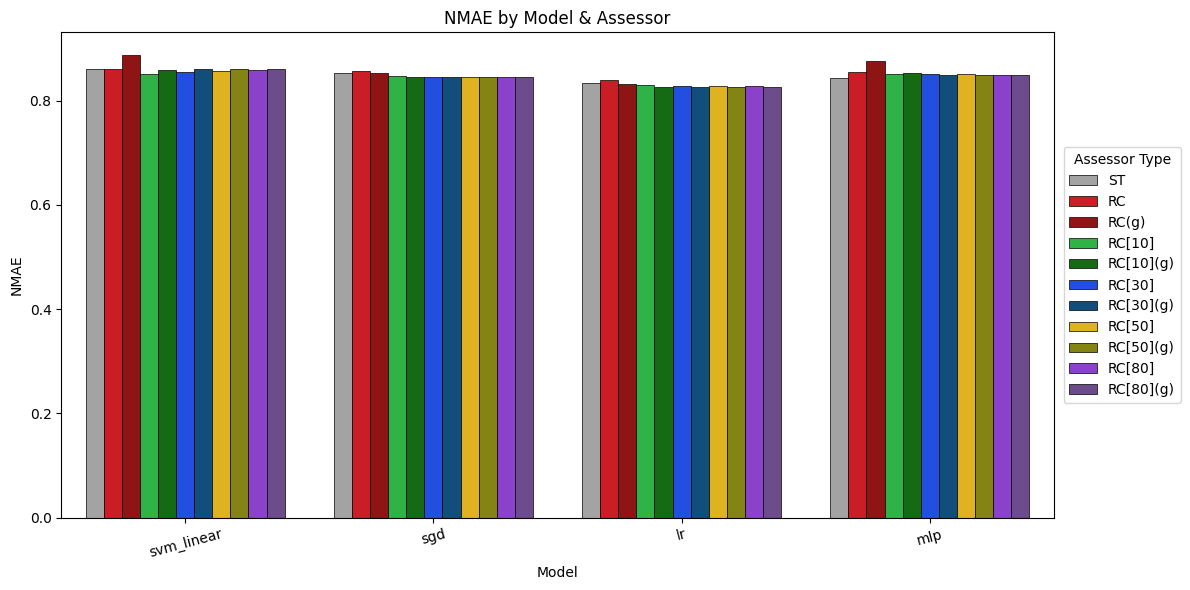

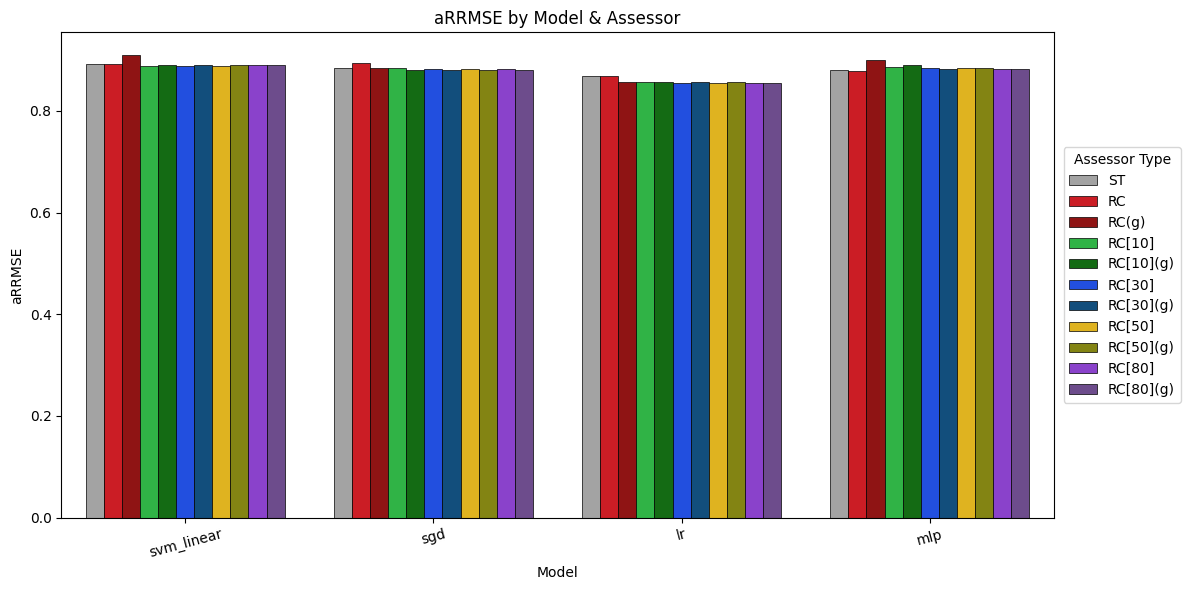

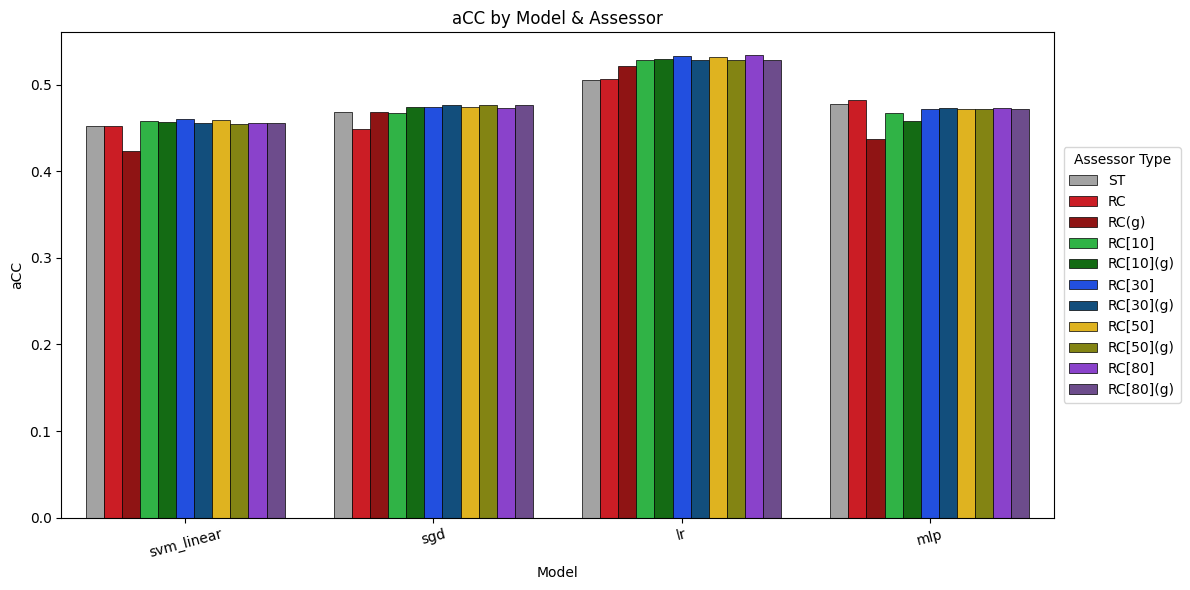

In [89]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=results_df, x='Model', y=mt, hue='Assessor', palette=class_palette, edgecolor='black', linewidth=0.5)
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, title='Assessor Type')
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    #imgplt.figure.savefig(f'data/{DIR}/imgs/bar_{mt.lower()}.eps', format='eps', dpi=300)

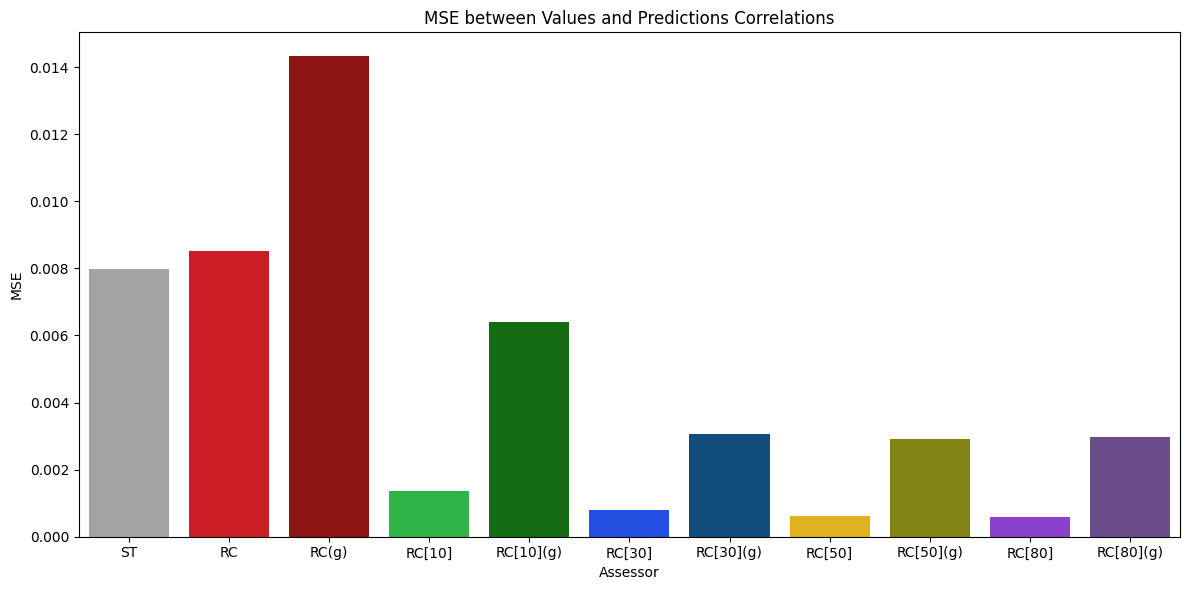

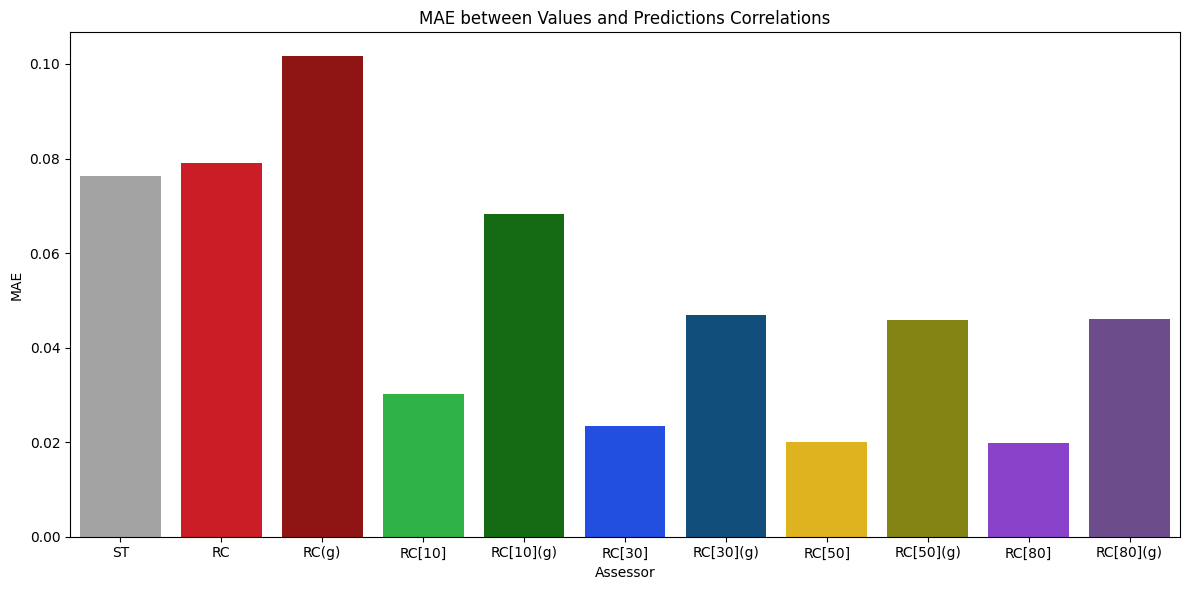

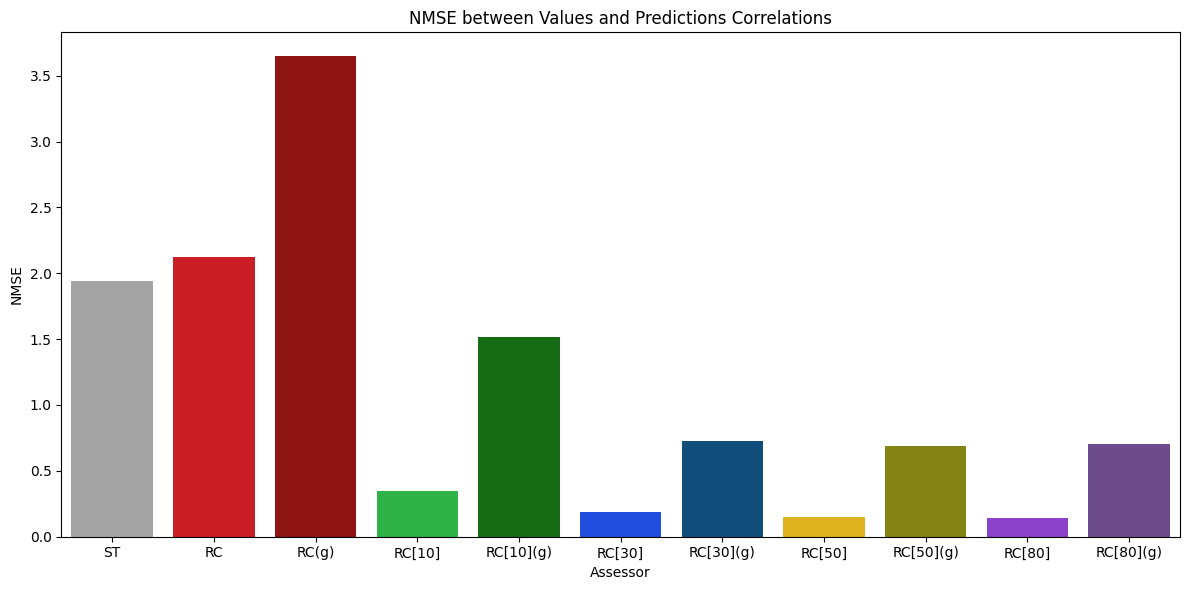

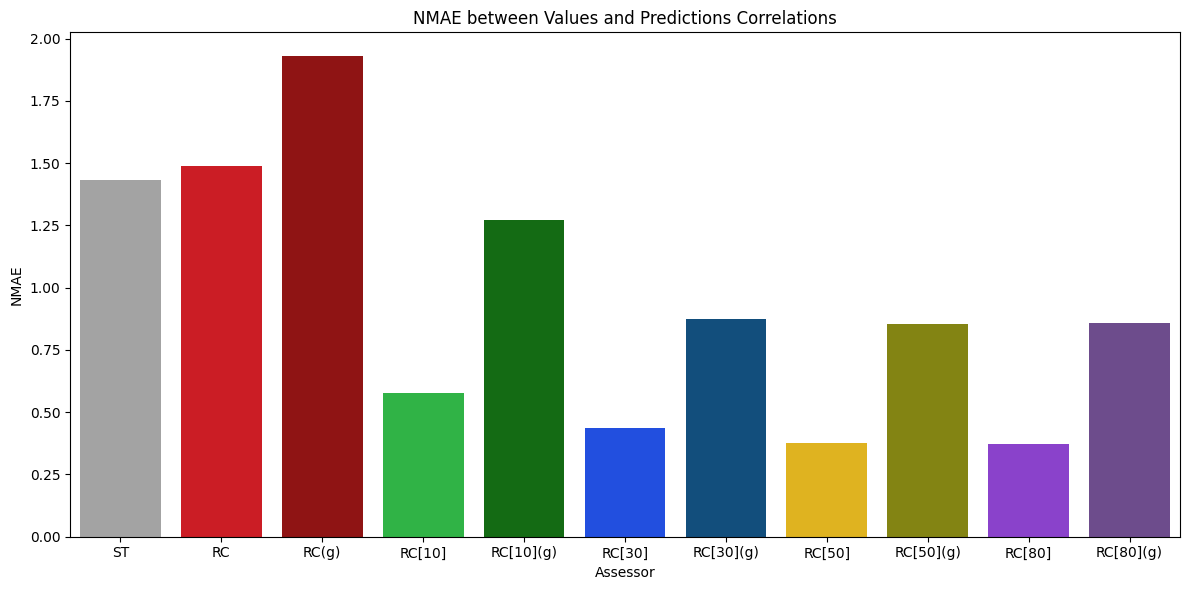

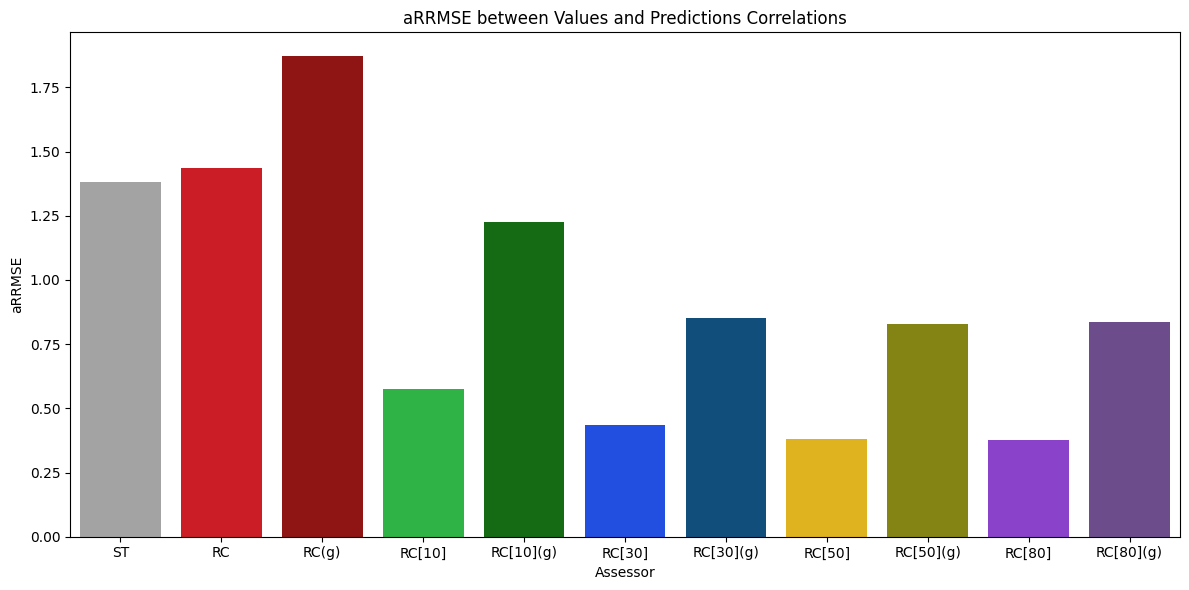

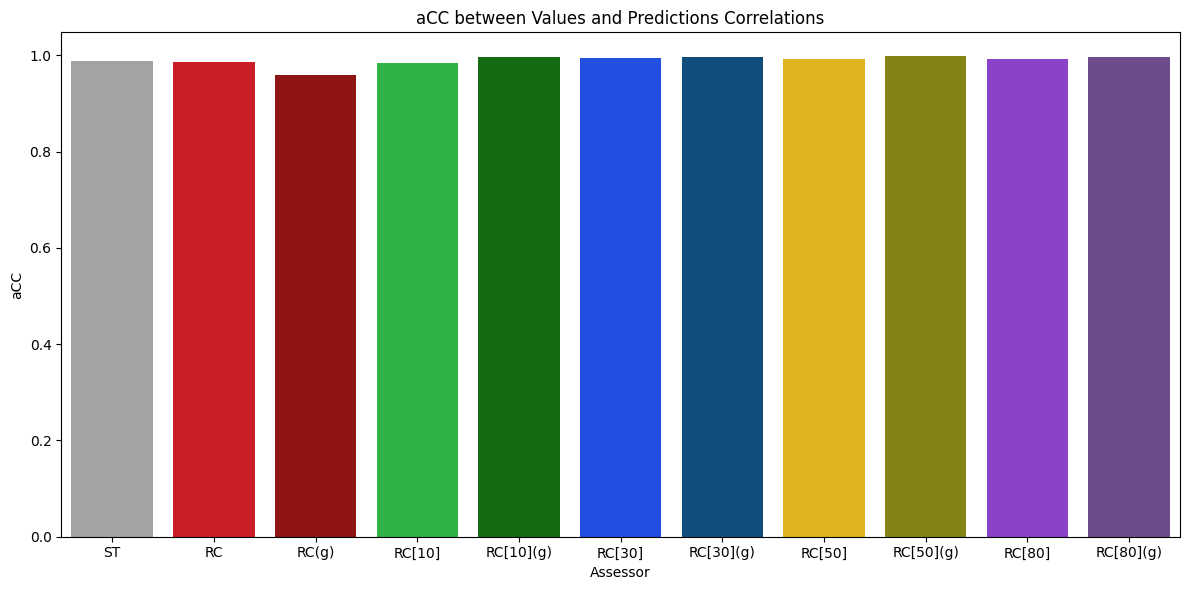

In [90]:
for mt in diff_metrics.columns:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=diff_results.loc[:,['Assessor', mt]], x='Assessor', y=mt, hue='Assessor', palette=class_palette)
    plt.title(f"{mt} between Values and Predictions Correlations")
    plt.tight_layout()
    plt.show(imgplt)
    #imgplt.figure.savefig(f'data/{DIR}/imgs/bardiff_{mt.lower()}.eps', format='eps', dpi=300)

---

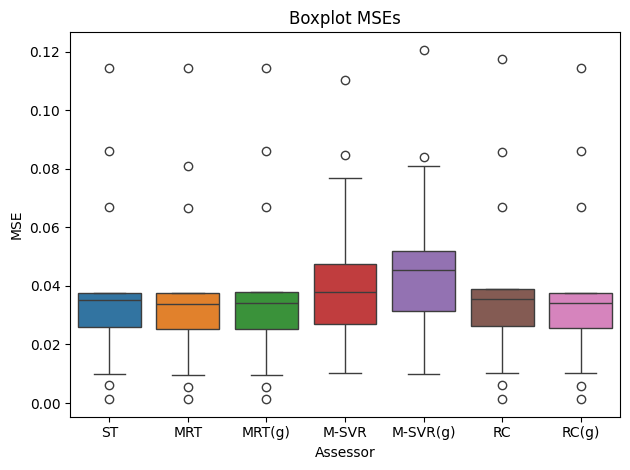

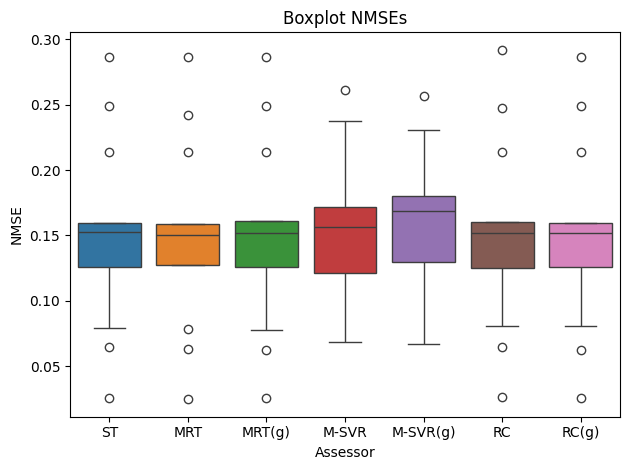

C:\Users\pedro\AppData\Local\Temp\ipykernel_16472\1332952985.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


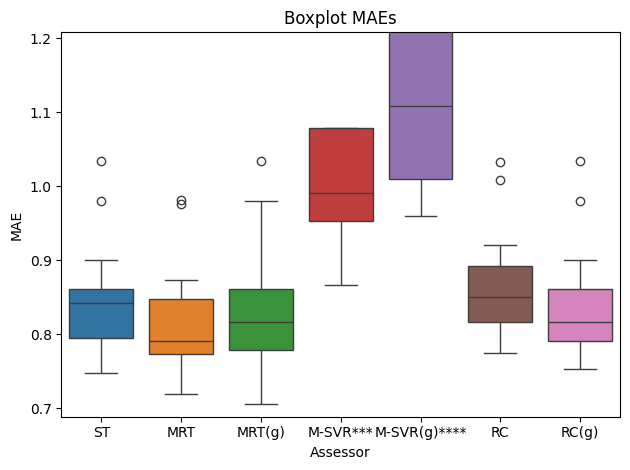

C:\Users\pedro\AppData\Local\Temp\ipykernel_16472\1332952985.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


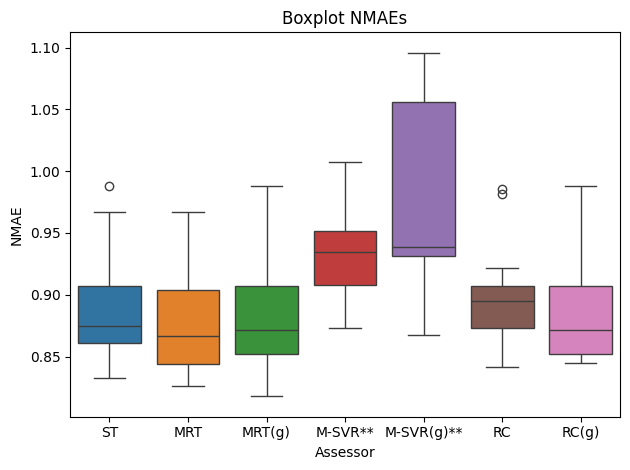

C:\Users\pedro\AppData\Local\Temp\ipykernel_16472\1332952985.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


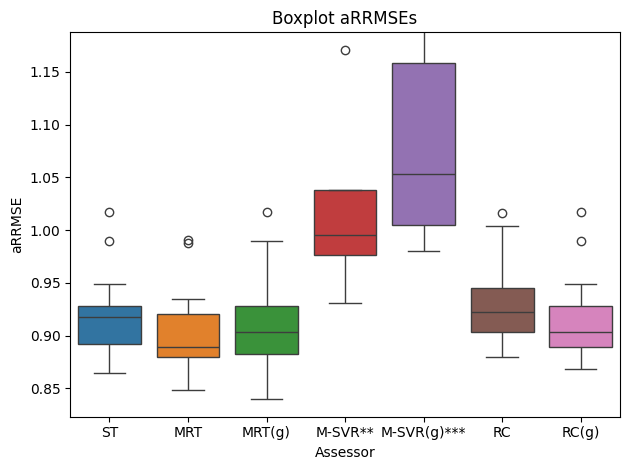

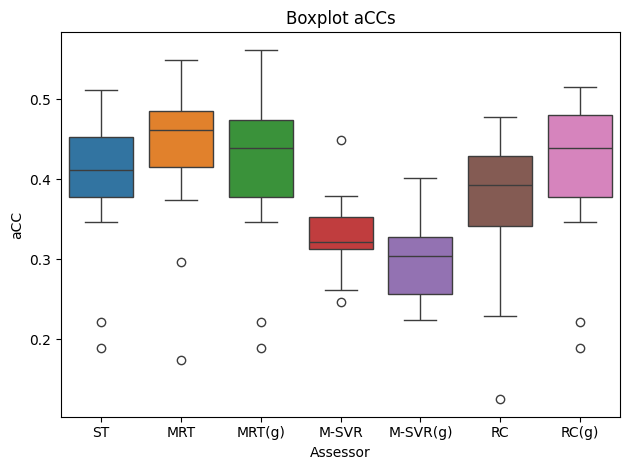

In [58]:
#temp = results_df.drop(index=results_df[results_df['Assessor'].str.contains('M-SVR')].index) #.copy()

for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    plt.title(f'Boxplot {mt}s')
    temp = results_df.loc[:,['Assessor','Model',mt]].copy()
    if((temp[mt] > 1.2).any()):
        dicio = {}
        for a in temp['Assessor'].unique():
            out_limits = (temp.loc[temp["Assessor"]==a,mt]>1.2).sum()
            if(out_limits > 0):
                dicio[a] = a + "*"*out_limits
        temp = temp.replace(dicio)
        plt.ylim(bottom=temp[mt].min()-0.017,top=temp.loc[temp[mt]<1.2,mt].max()+0.017)
    imgplt = sns.boxplot(temp, y=mt, x='Assessor', hue='Assessor', palette=class_palette)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bp_{mt.lower()}.eps', format='eps', dpi=300)

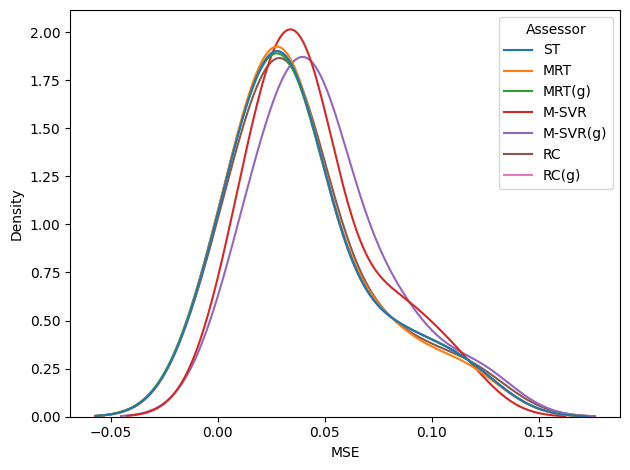

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


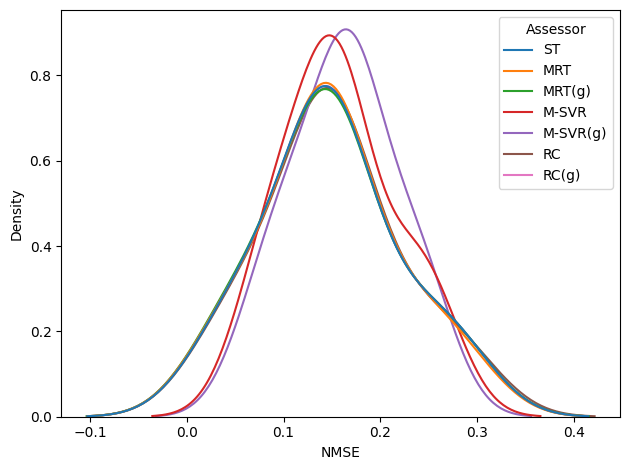

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\pedro\AppData\Local\Temp\ipykernel_16472\1270300147.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


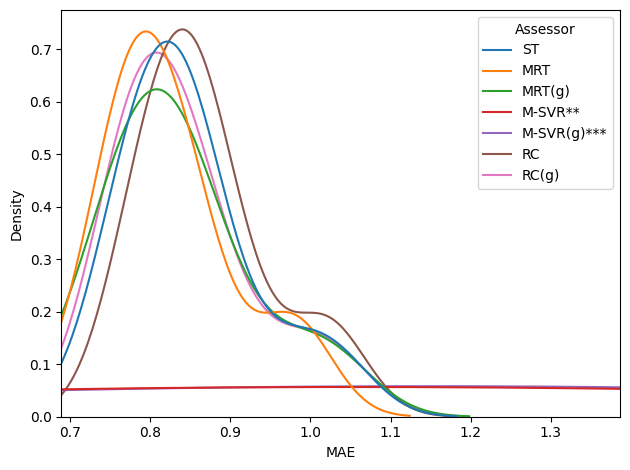

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\pedro\AppData\Local\Temp\ipykernel_16472\1270300147.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


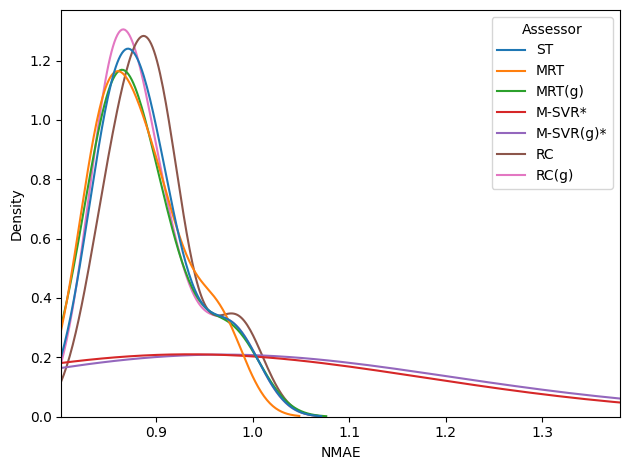

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
C:\Users\pedro\AppData\Local\Temp\ipykernel_16472\1270300147.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.replace(dicio)


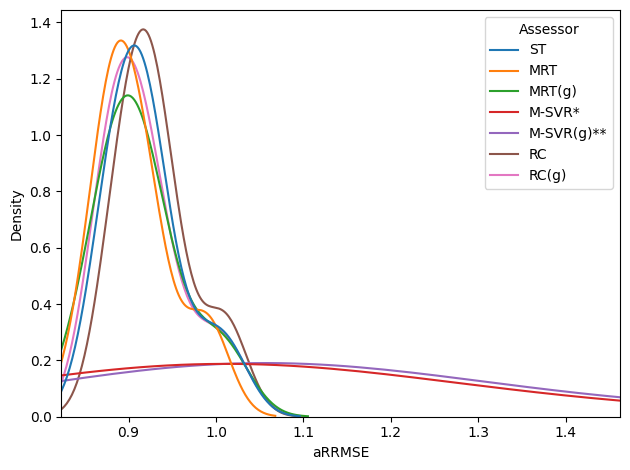

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


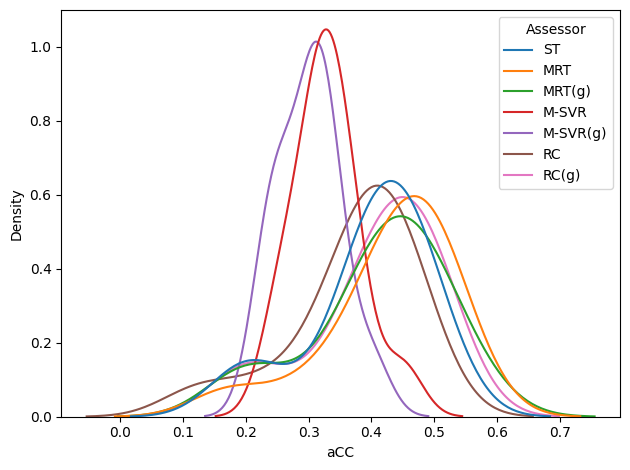

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [59]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    temp = results_df.loc[:,['Assessor','Model',mt]].copy()
    if((temp[mt] > 1.5).any()):
        dicio = {}
        for a in temp['Assessor'].unique():
            out_limits = (temp.loc[temp["Assessor"]==a,mt]>1.5).sum()
            if(out_limits > 0):
                dicio[a] = a + "*"*out_limits
        temp = temp.replace(dicio)
        plt.xlim(temp[mt].min()-0.017,temp.loc[temp[mt]<1.5,mt].max()+0.017)
    imgplt = sns.kdeplot(temp, x=mt, hue='Assessor', palette=class_palette)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/kde_{mt.lower()}.eps', format='eps', dpi=300)

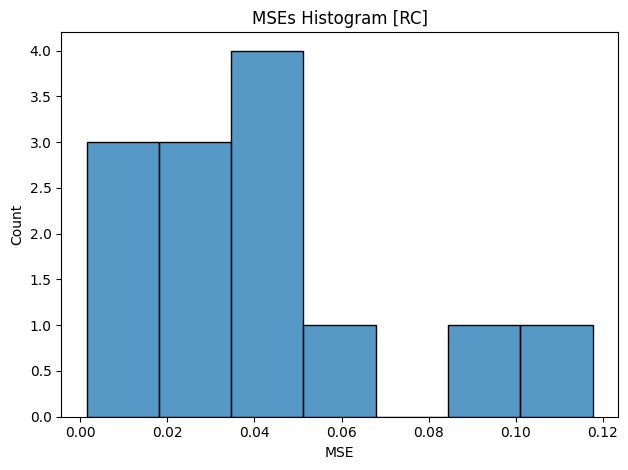

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


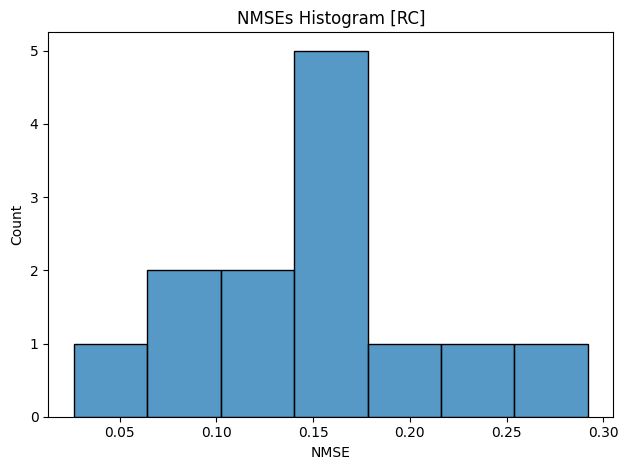

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


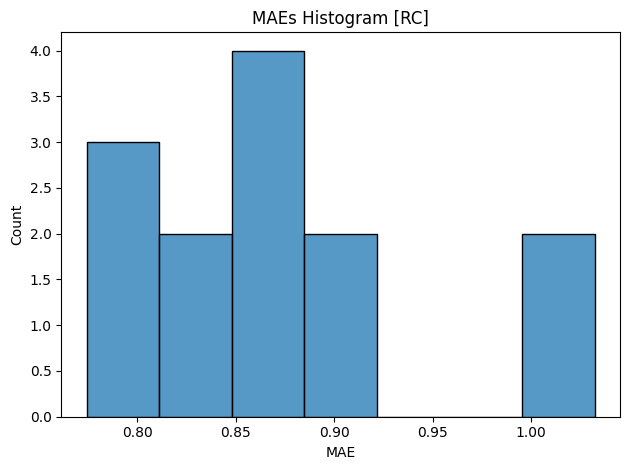

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


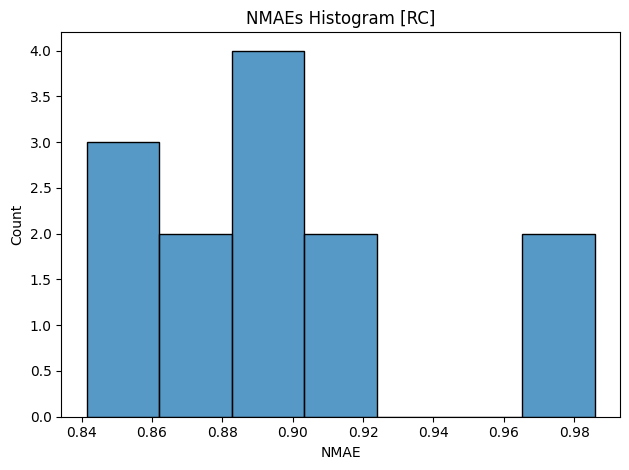

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


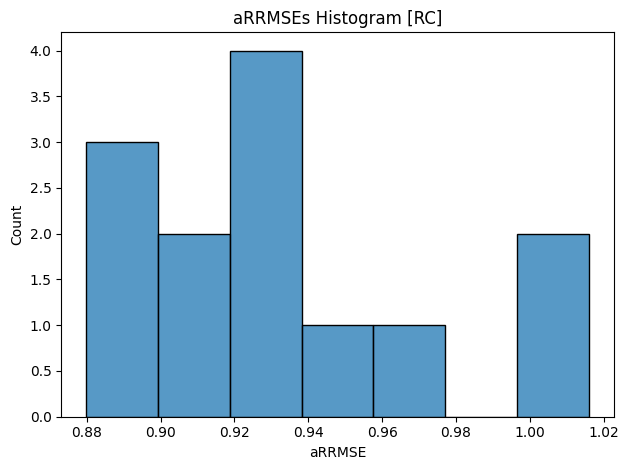

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


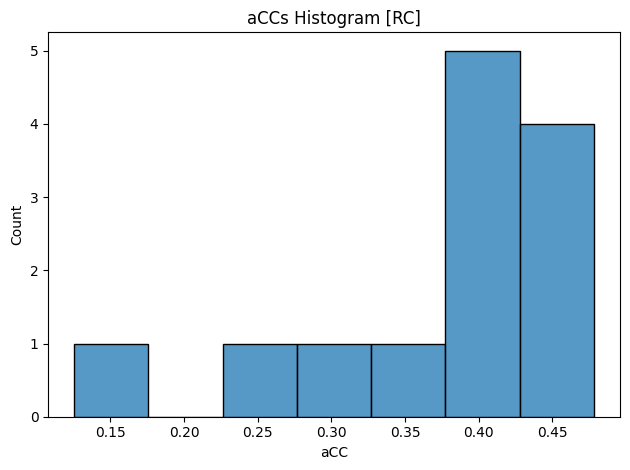

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


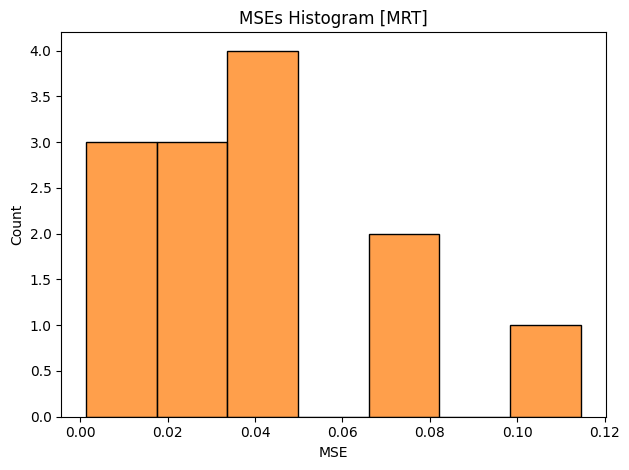

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


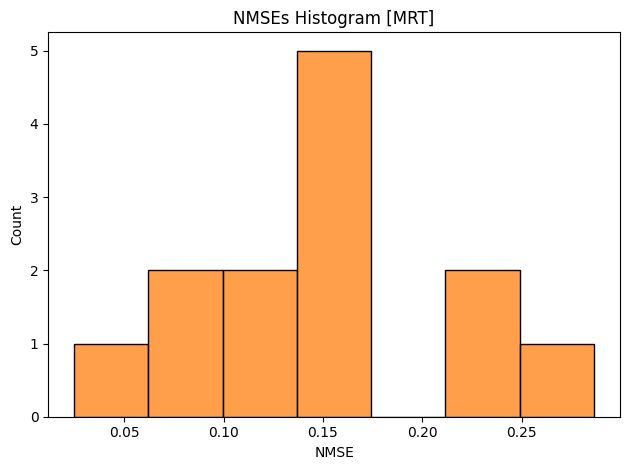

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


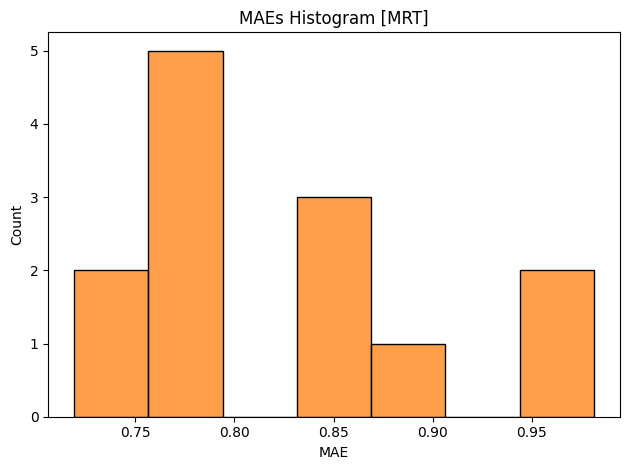

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


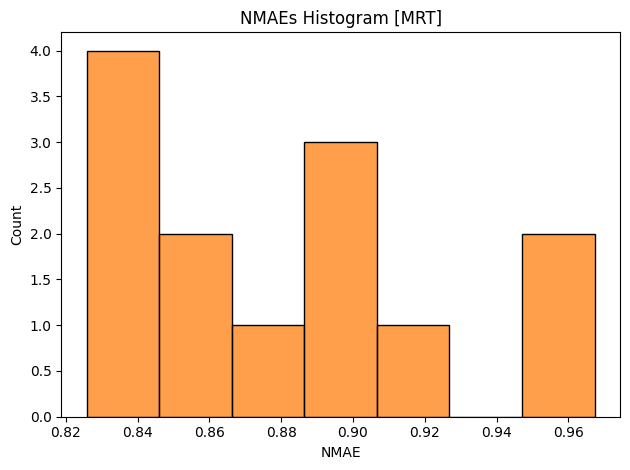

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


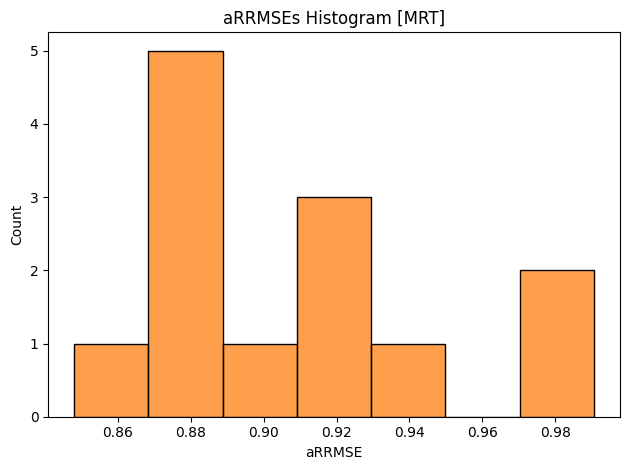

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


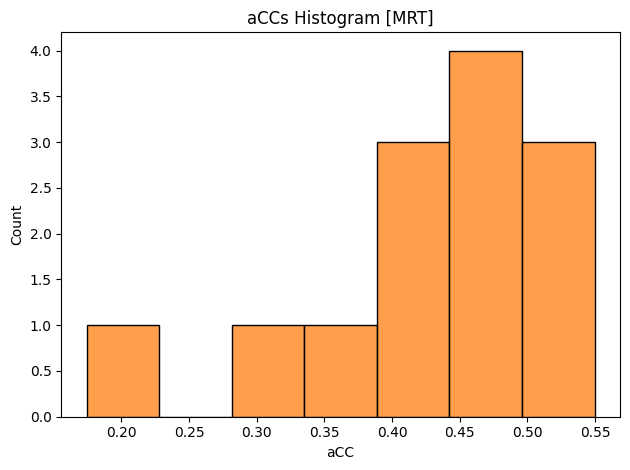

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


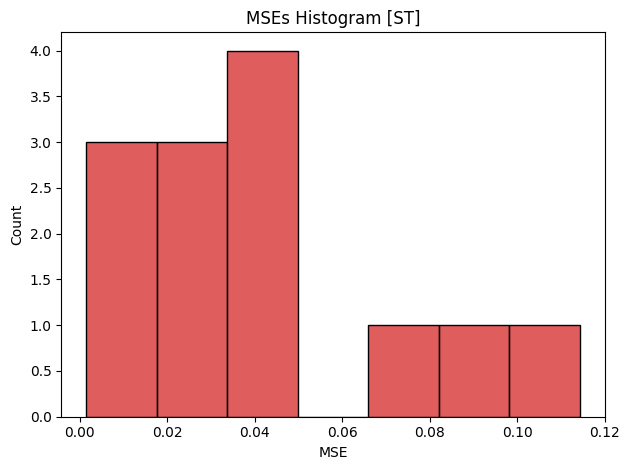

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


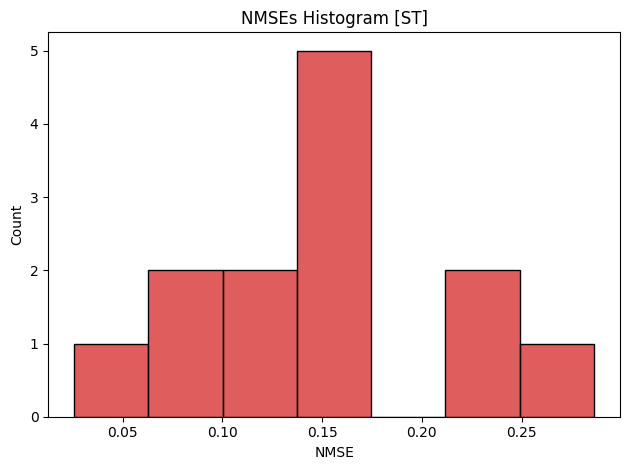

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


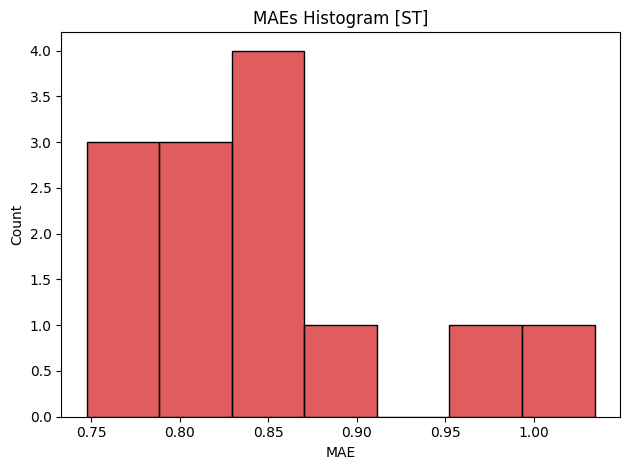

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


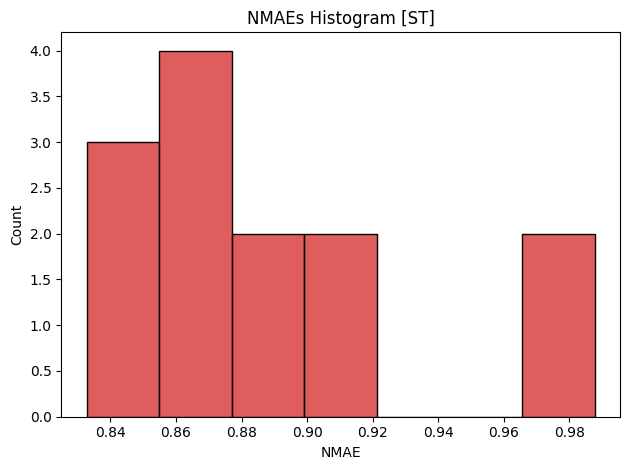

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


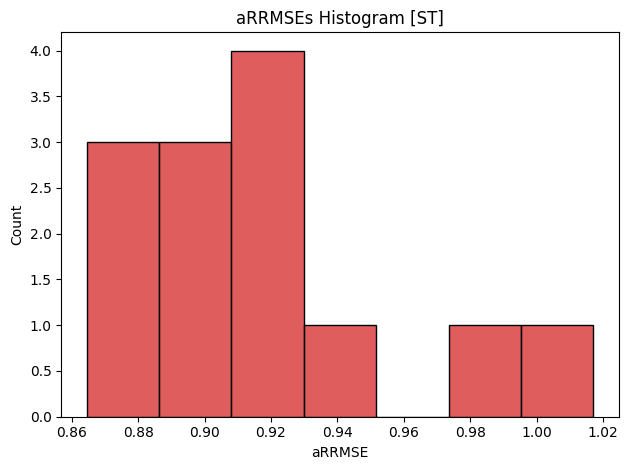

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


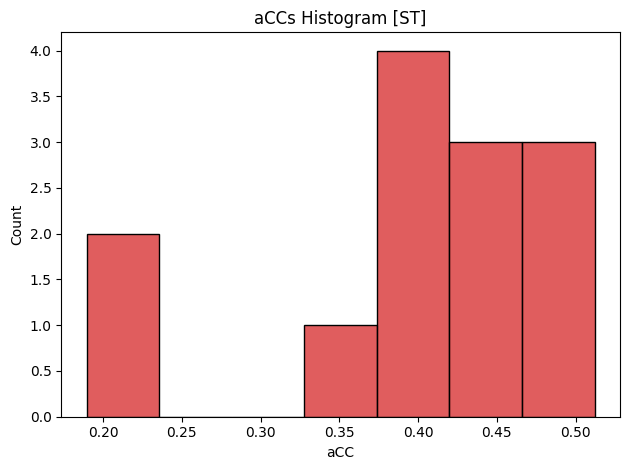

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


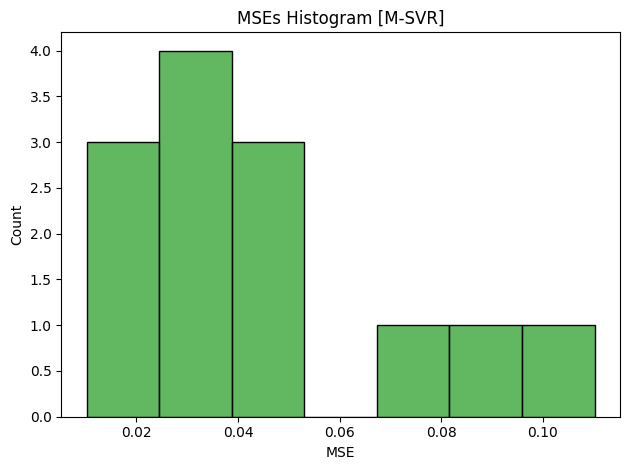

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


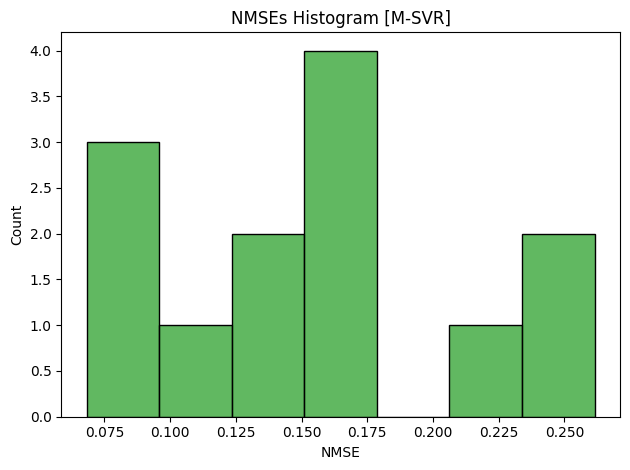

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


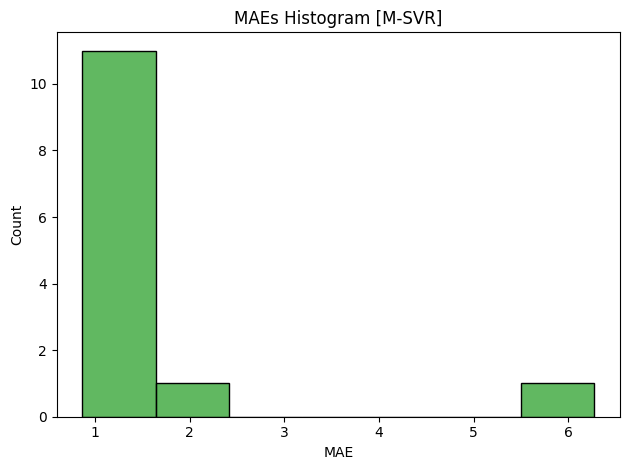

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


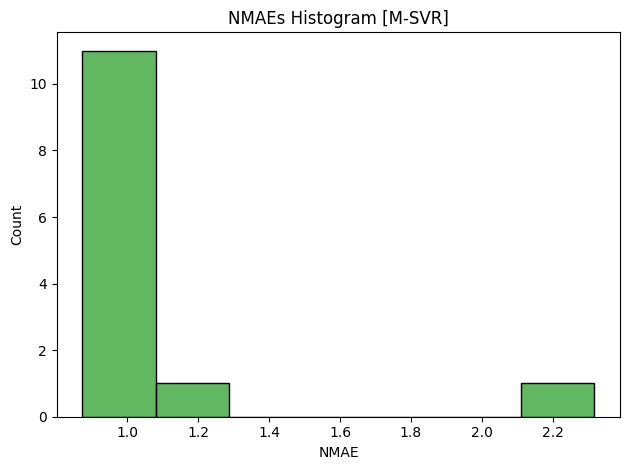

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


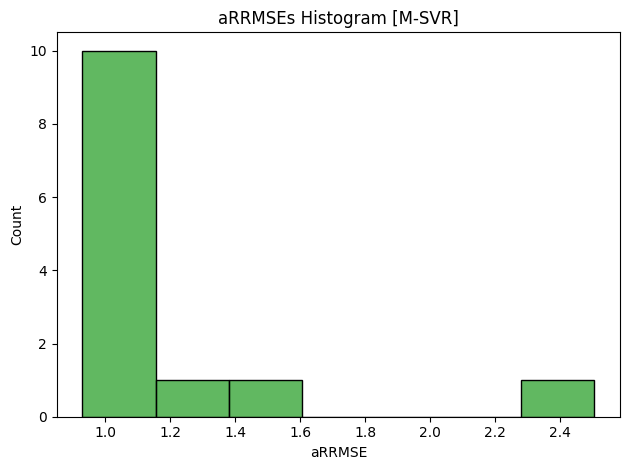

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


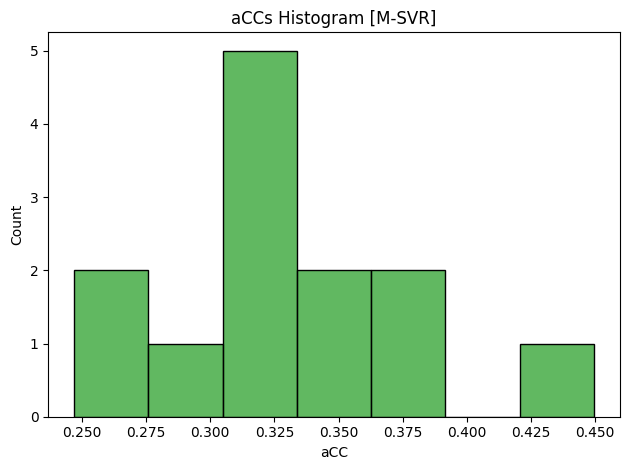

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


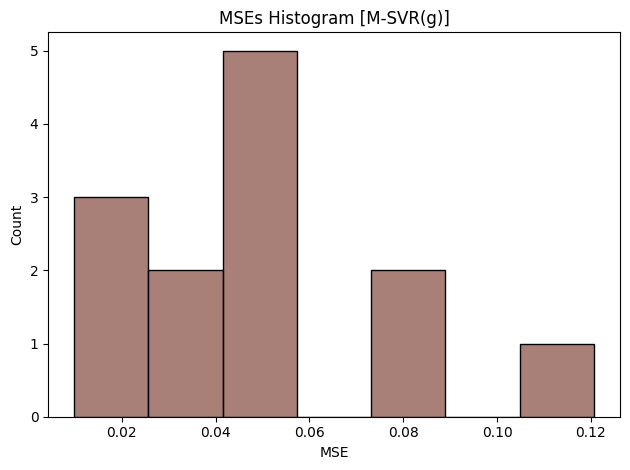

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


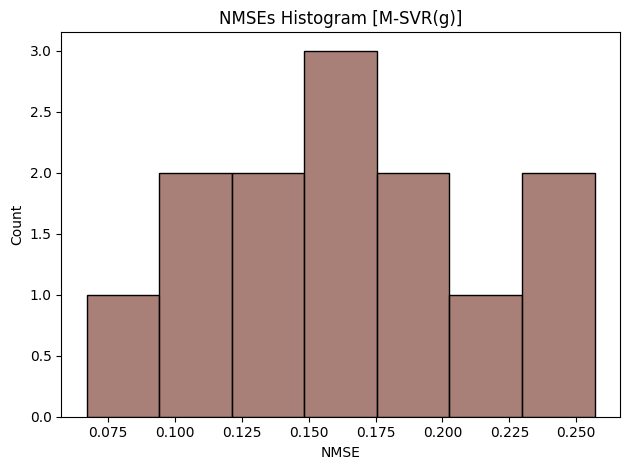

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


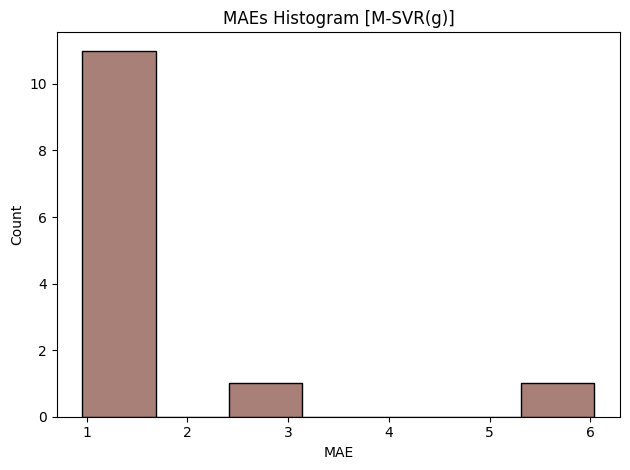

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


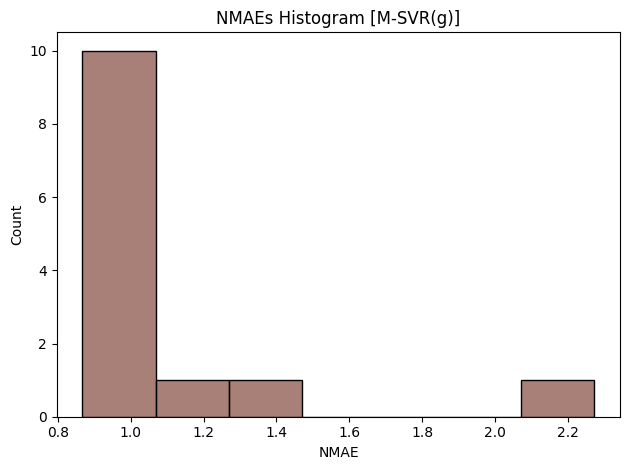

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


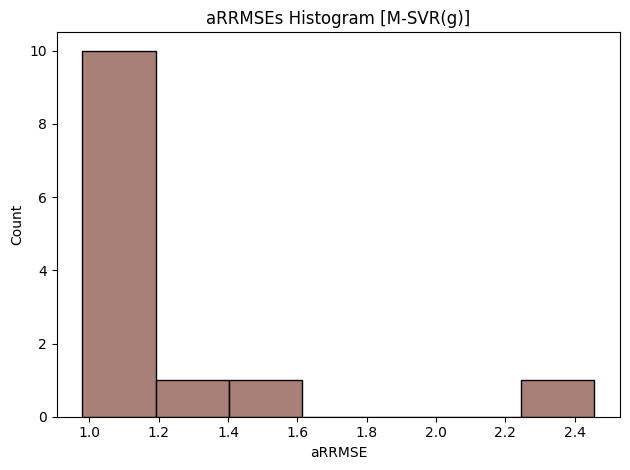

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


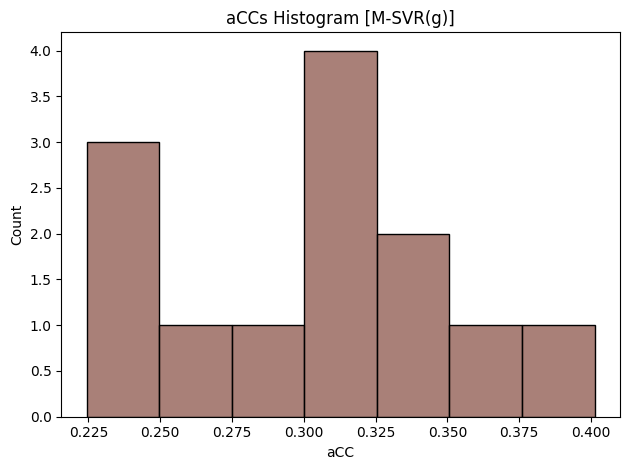

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


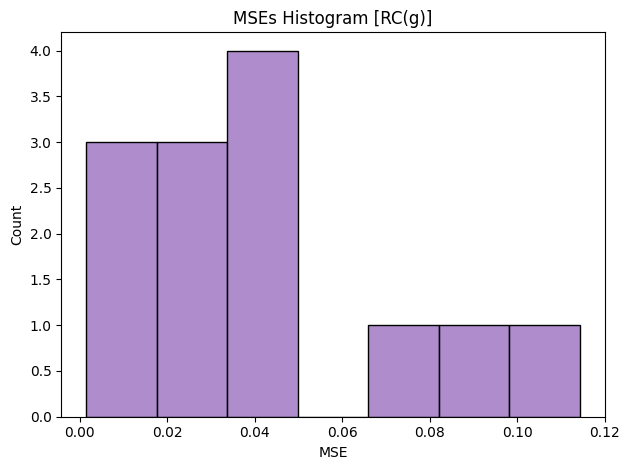

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


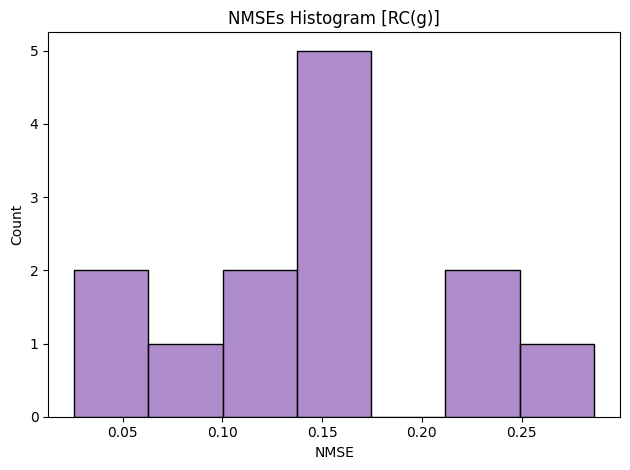

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


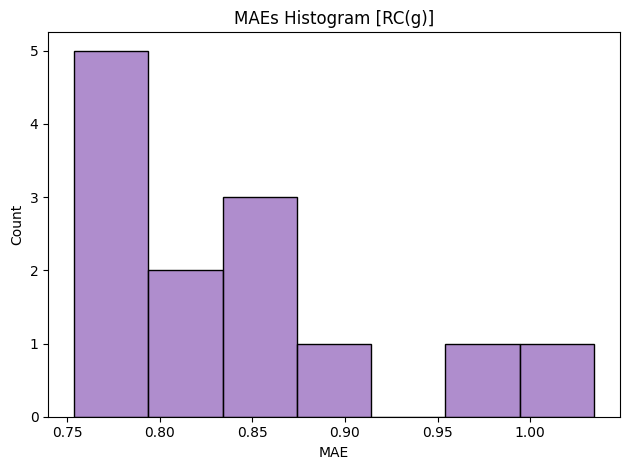

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


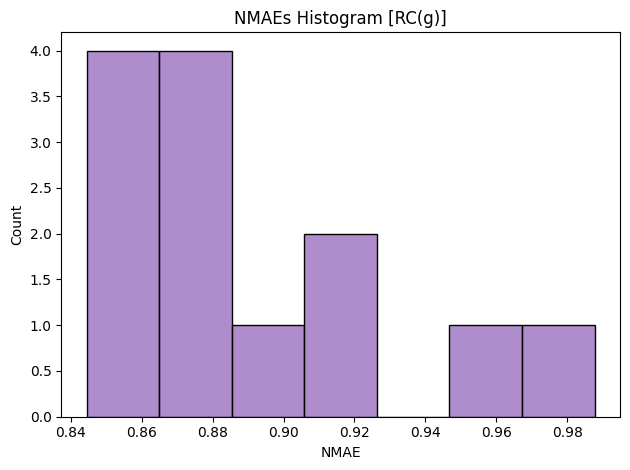

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


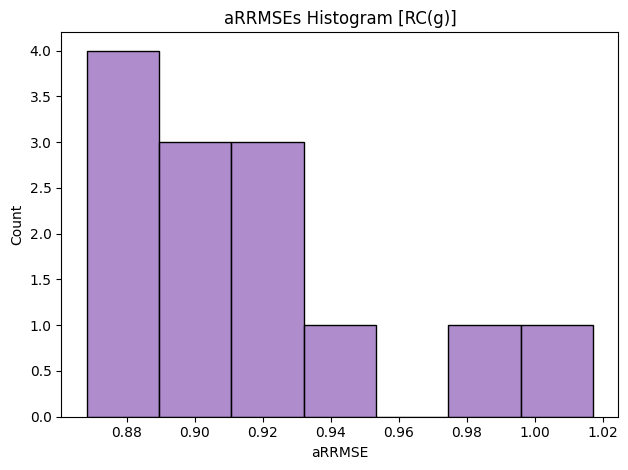

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


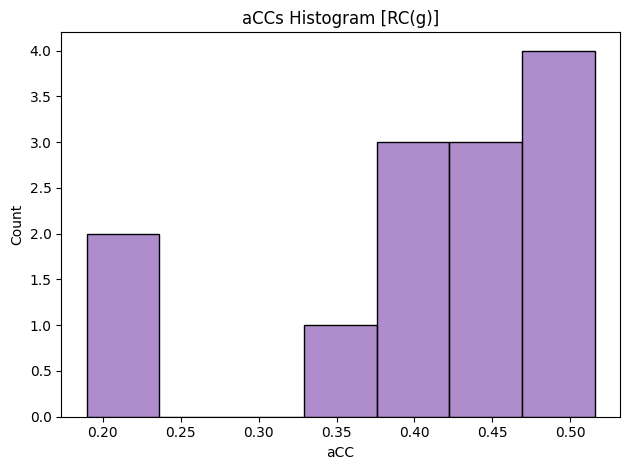

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


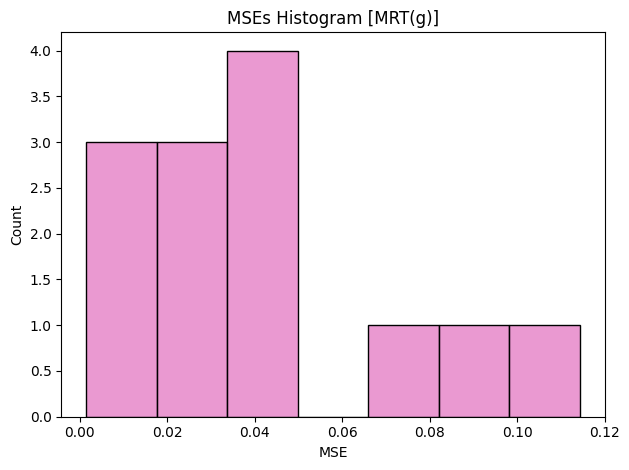

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


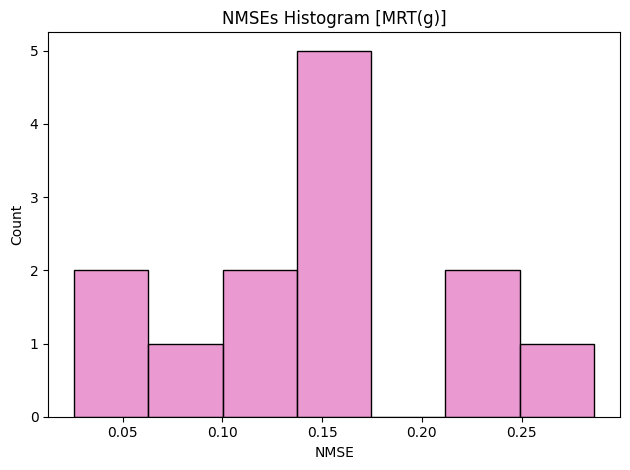

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


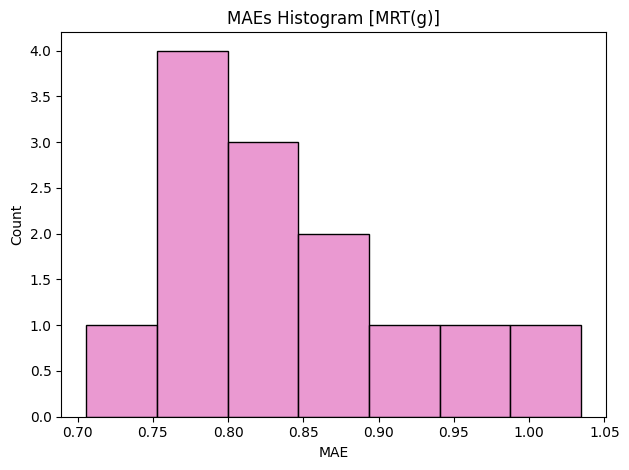

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


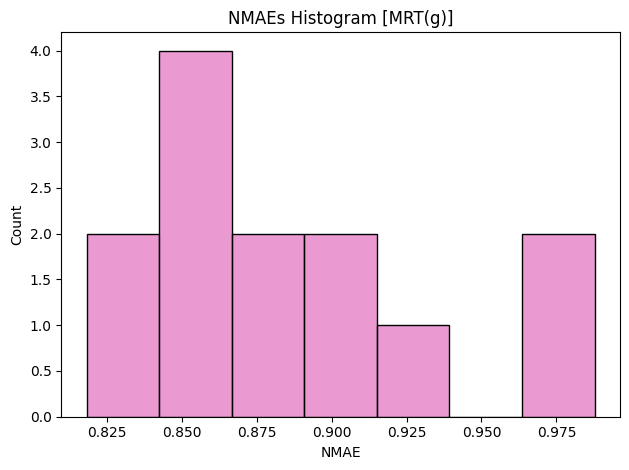

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


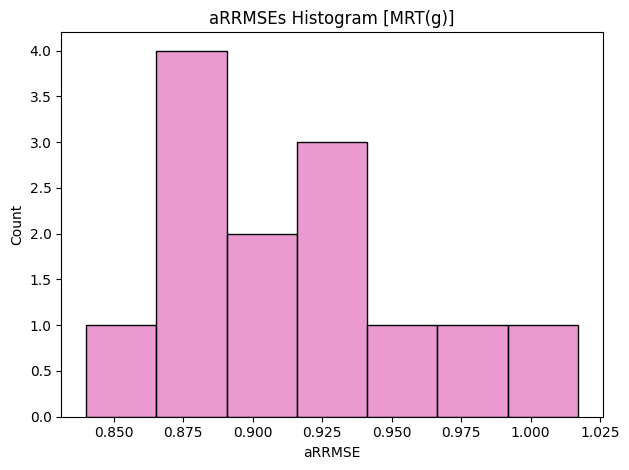

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


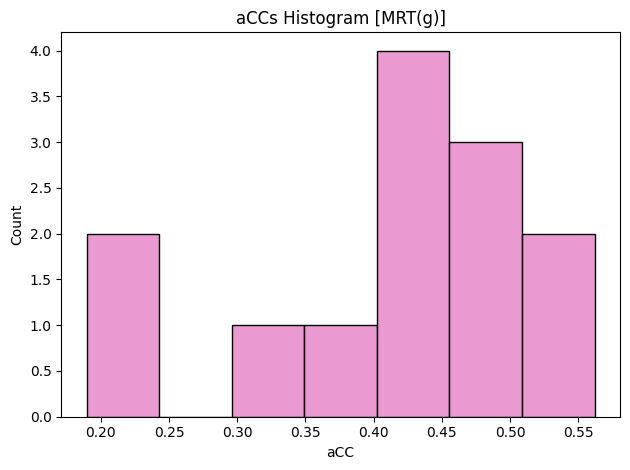

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [60]:
dicio = {'RC': {'color': class_palette[0], 'code': 'RC'},
         'MRT': {'color': class_palette[1], 'code': 'MRT'},
         'ST': {'color': class_palette[3], 'code': 'ST'},
         'M-SVR': {'color': class_palette[2], 'code': 'MSVR'},
         'M-SVR(g)': {'color': class_palette[-2], 'code': 'MSVRG'},
         'RC(g)': {'color': class_palette[-3], 'code': 'RCG'},
         'MRT(g)': {'color': class_palette[-1], 'code': 'MRTG'}}

for a in dicio.keys():
    for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
        plt.title(f'{mt}s Histogram [{a}]')
        imgplt = sns.histplot(results_df.loc[results_df['Assessor']==a,['Assessor','Model',mt]], x=mt, bins=7, color=dicio[a]['color'])
        plt.tight_layout()
        plt.show(imgplt)
        imgplt.figure.savefig(f'data/{DIR}/imgs/hg_{dicio[a]["code"]}_{mt.lower()}.eps', format='eps', dpi=300)

In [61]:
results_df

Assessor       Model       MSE       MAE      NMSE      NMAE    aRRMSE  \
0        ST       dtree  0.066898  0.850712  0.213765  0.894977  0.922341   
1        ST         sgd  0.035082   0.77635  0.152606  0.847468  0.881107   
2        ST          lr   0.01001  0.747281  0.079003  0.832759  0.864454   
3        ST         knn  0.030168  0.813318  0.142208  0.865585  0.901842   
4        ST  svm_linear  0.025841  0.795178  0.129468  0.860798  0.891728   
..      ...         ...       ...       ...       ...       ...       ...   
86    RC(g)         kan  0.114392  0.979948  0.286264  0.966827  0.989923   
87    RC(g)     rforest   0.03503   0.86078  0.153779  0.919298  0.927783   
88    RC(g)          gb  0.085998  1.034548  0.249029  0.987738  1.017127   
89    RC(g)        adab  0.001467  0.900536  0.025751  0.874819  0.948966   
90    RC(g)         xgb  0.035615  0.816694   0.15232  0.871327  0.903711   

         aCC  
0   0.412323  
1   0.476309  
2   0.511993  
3   0.438895  
4   0.452745  
..       ...  
86  0.189614  
87  0.378154  
88  0.221452  
89  0.346271  
90  0.438742  

[91 rows x 8 columns]

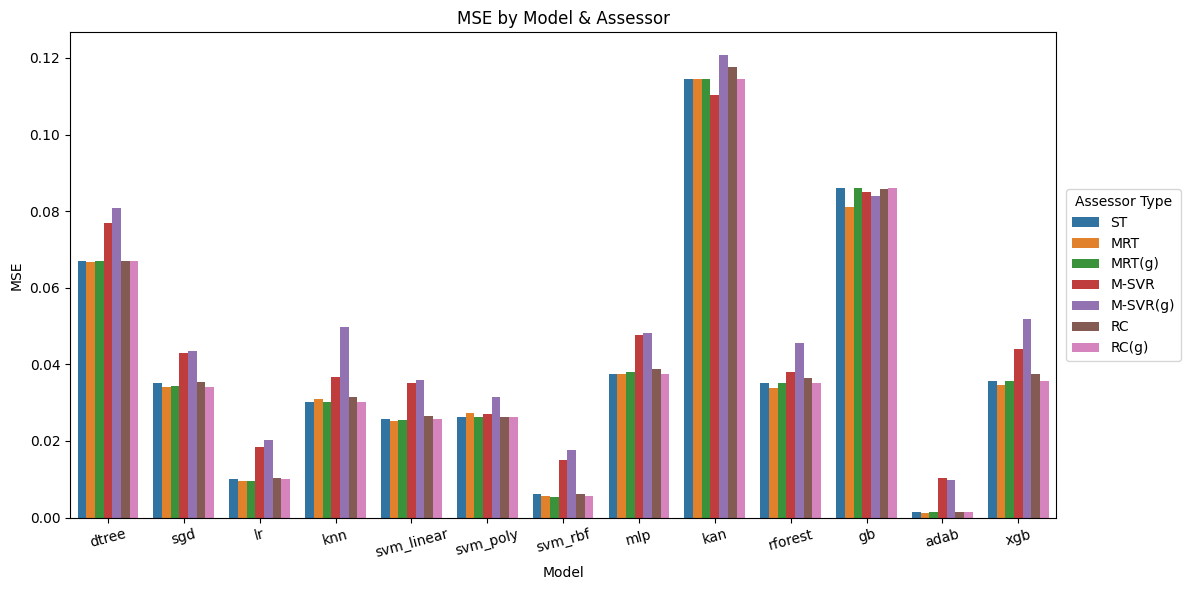

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


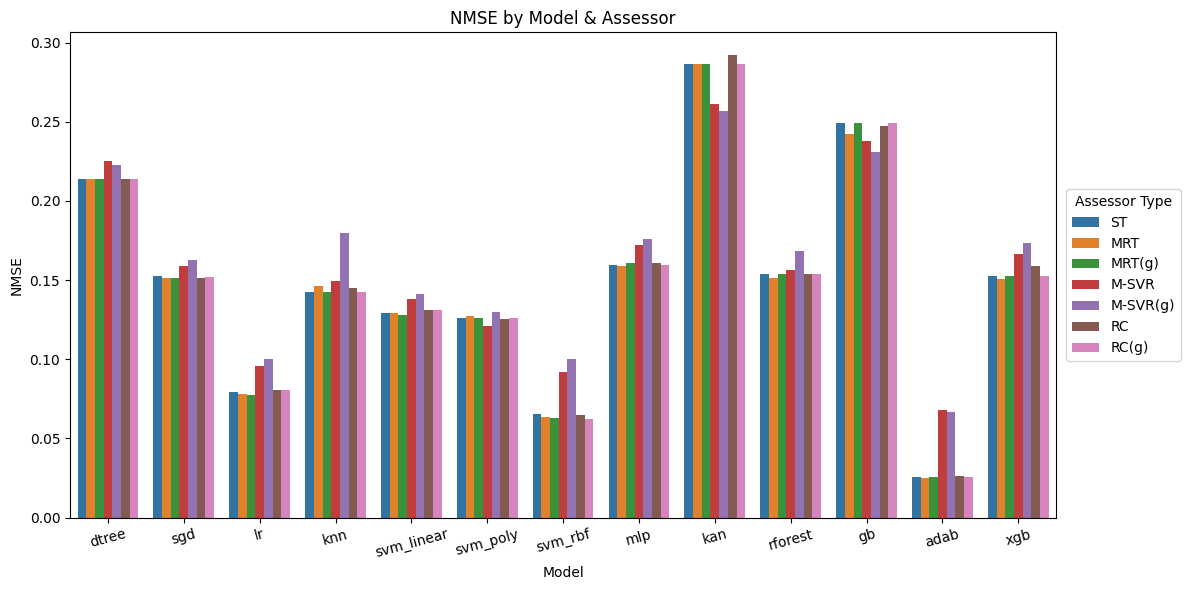

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


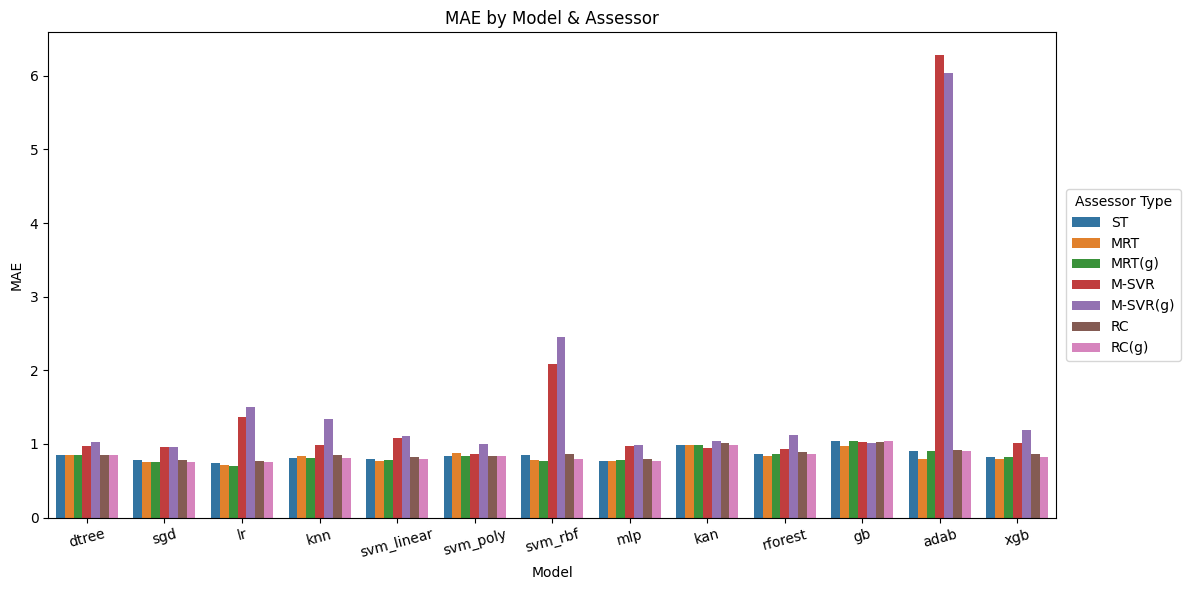

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


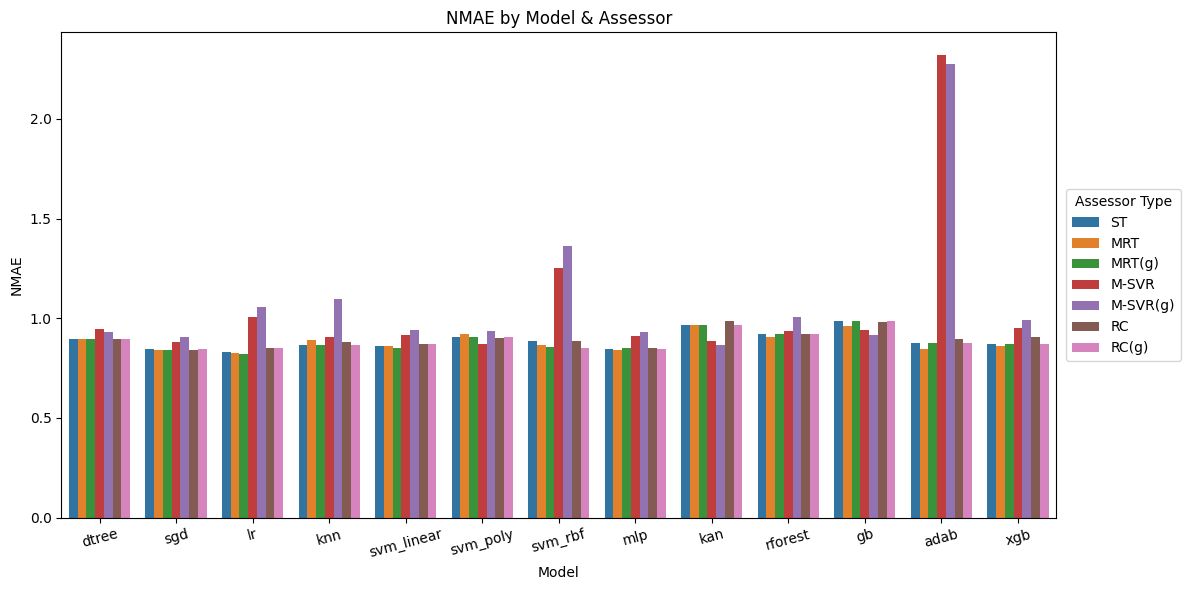

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


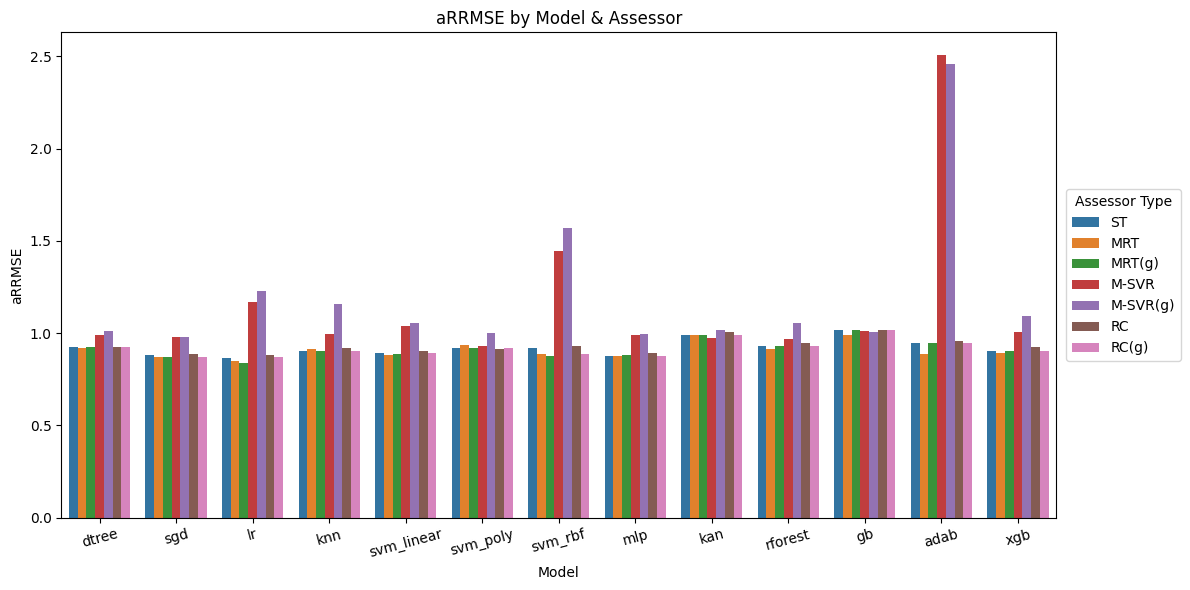

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


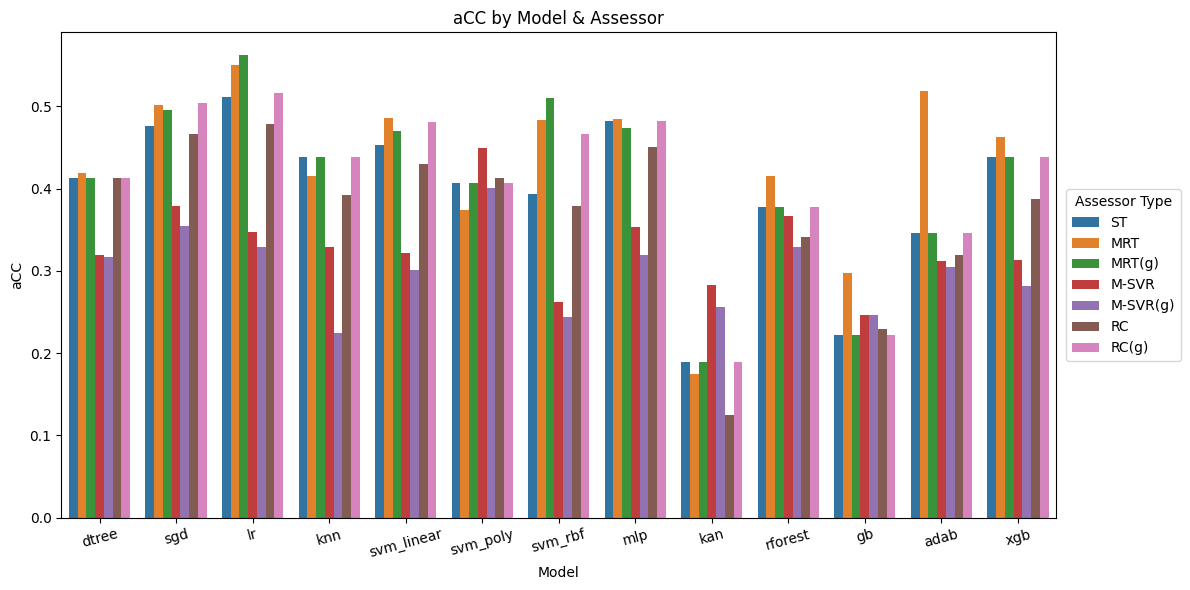

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [62]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE', 'aRRMSE', 'aCC']:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=results_df, x='Model', y=mt, hue='Assessor', palette=class_palette)
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, title='Assessor Type')
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bar_{mt.lower()}.eps', format='eps', dpi=300)

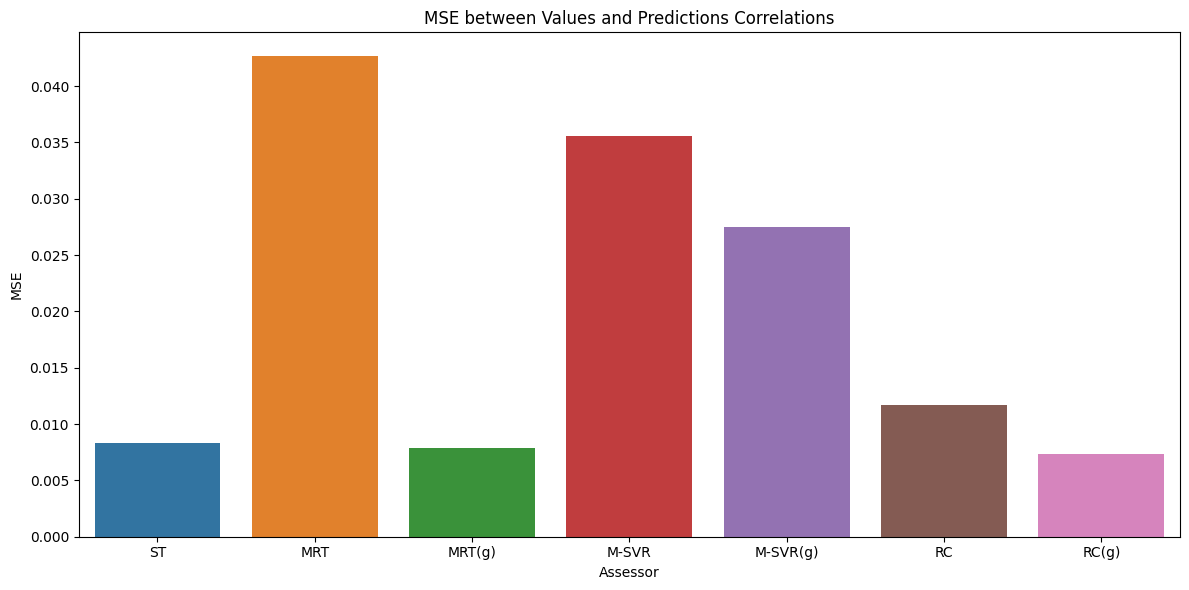

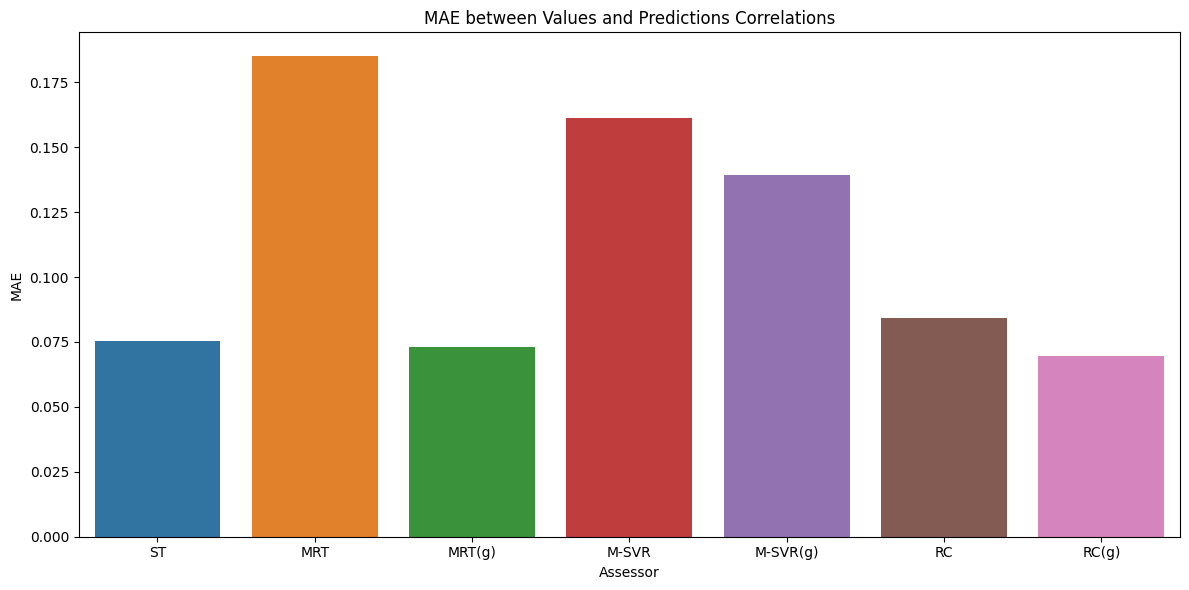

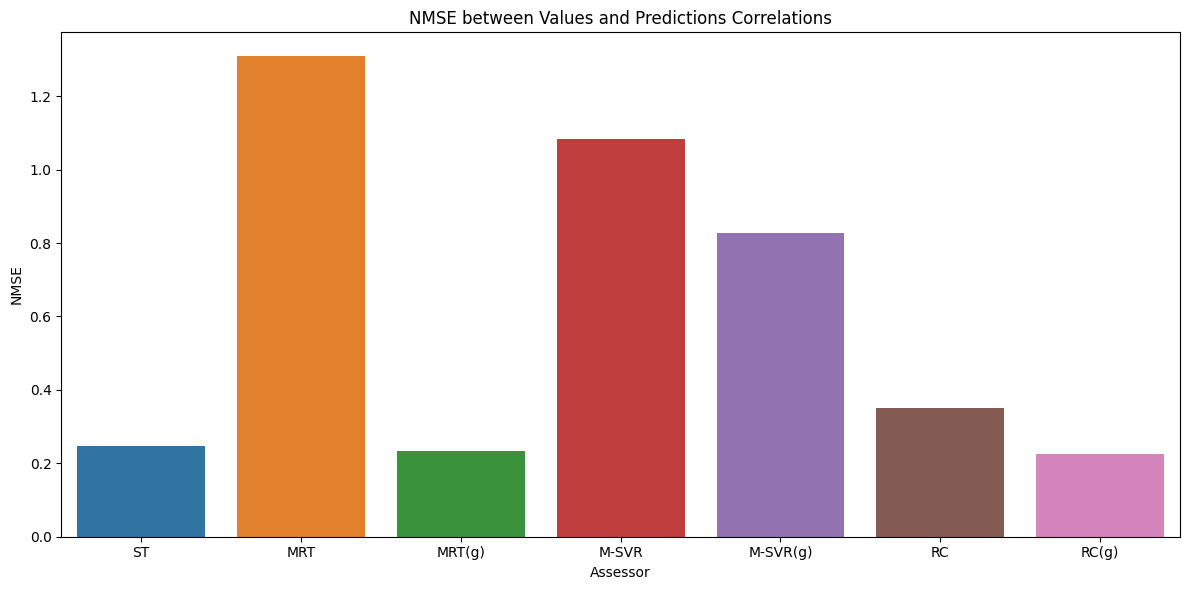

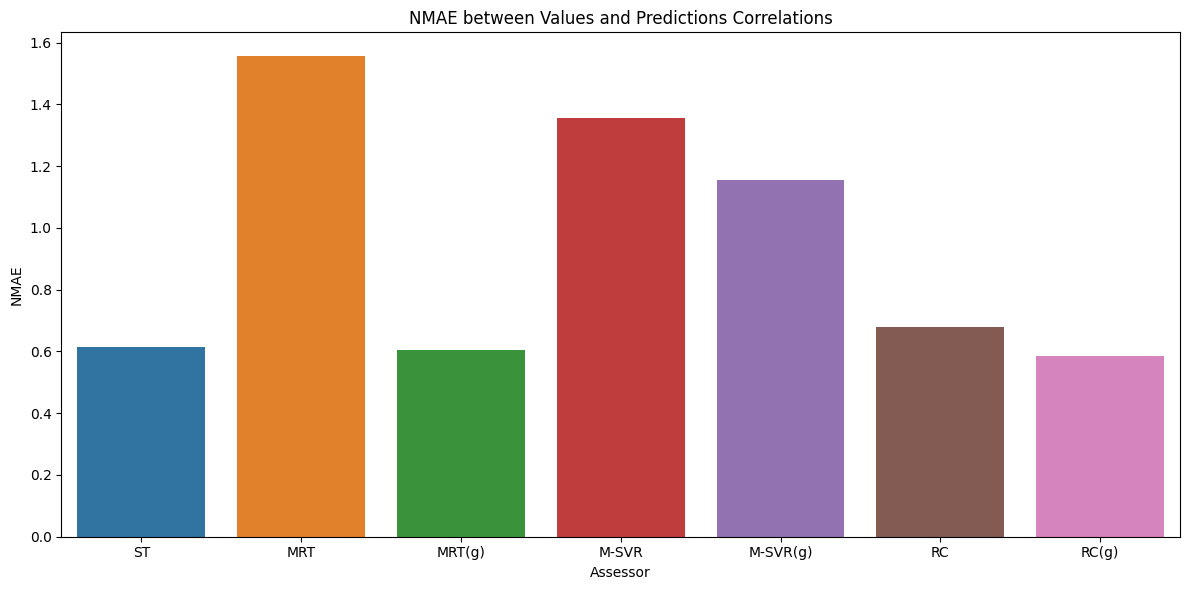

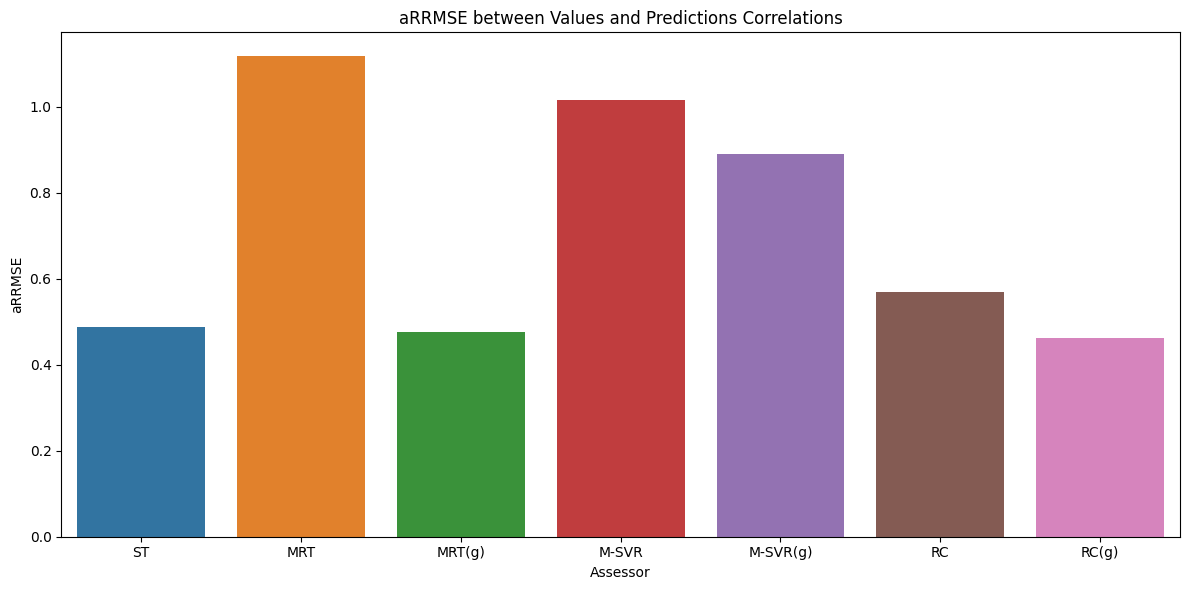

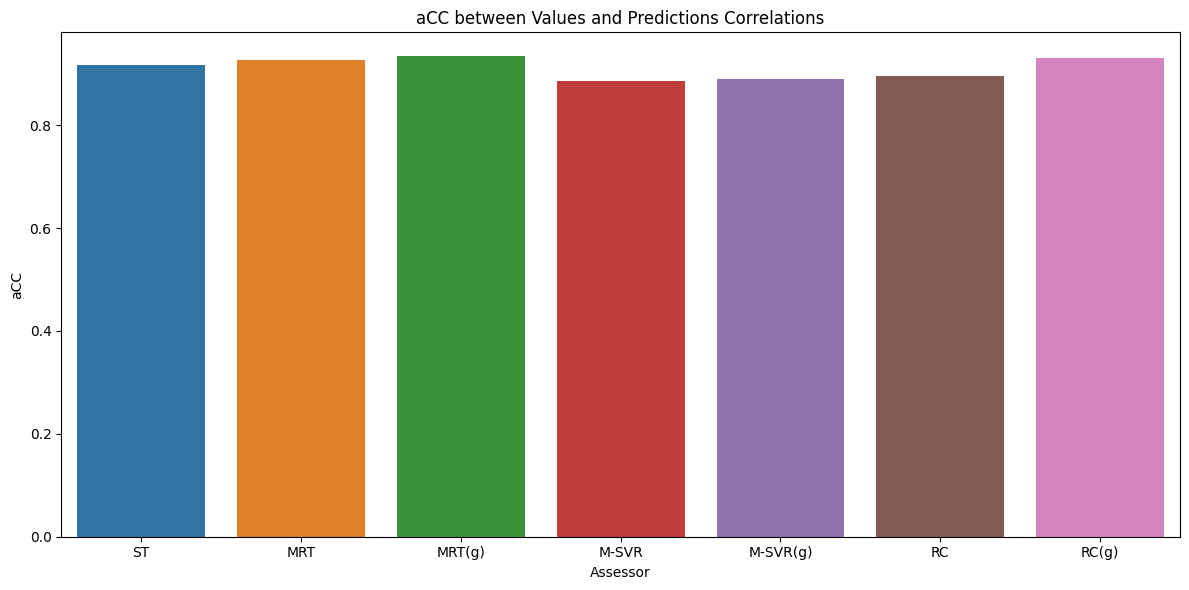

In [63]:
for mt in diff_metrics.columns:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=diff_results.loc[:,['Assessor', mt]], x='Assessor', y=mt, hue='Assessor', palette=class_palette)
    plt.title(f"{mt} between Values and Predictions Correlations")
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bardiff_{mt.lower()}.eps', format='eps', dpi=300)